# IST 718 Final Project - ANALYZING THE AVOCADO INDUSTRY

By Xiangzhen He, Katherine Hurtado-da Silva and Jazmin Logroño

In [1]:
#load required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from matplotlib import rcParams

#import math
import pmdarima as pm

import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px

from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from math import sqrt
from pandas import DataFrame
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%matplotlib inline

In [2]:
#load avocado data set
adf= pd.read_csv('Data/cali_avocados.csv')

In [3]:
#review the records
print(adf.shape)
print(adf[:20])

(420, 11)
    Year   Commodity Code      Crop Name   County Code            County  \
0   2020           221999  AVOCADOS ALL             53         Monterey    
1   2020           221999  AVOCADOS ALL             65        Riverside    
2   2020           221999  AVOCADOS ALL             71   San Bernardino    
3   2020           221999  AVOCADOS ALL             73        San Diego    
4   2020           221999  AVOCADOS ALL             79  San Luis Obispo    
5   2020           221999  AVOCADOS ALL             83    Santa Barbara    
6   2020           221999  AVOCADOS ALL            111          Ventura    
7   2019           221999  AVOCADOS ALL             53         Monterey    
8   2019           221999  AVOCADOS ALL             65        Riverside    
9   2019           221999  AVOCADOS ALL             71   San Bernardino    
10  2019           221999  AVOCADOS ALL             73        San Diego    
11  2019           221999  AVOCADOS ALL             79  San Luis Obispo    
12

In [4]:
#check the data type of each column
adf.dtypes #column names have spaces before names #numerical data types needed

Year                 int64
 Commodity Code      int64
 Crop Name          object
 County Code         int64
 County             object
 Harvested Acres    object
 Yield              object
 Production         object
 Price P/U          object
 Unit               object
 Value              object
dtype: object

In [5]:
#review the column names
print(adf.columns) #found there are extra spaces in the column names

Index(['Year', ' Commodity Code', ' Crop Name', ' County Code', ' County',
       ' Harvested Acres', ' Yield', ' Production', ' Price P/U', ' Unit',
       ' Value'],
      dtype='object')


In [6]:
#Remove whitespace from column name
adf.columns = adf.columns.str.replace(' ', '')

In [7]:
adf.dtypes #column names fixed

Year               int64
CommodityCode      int64
CropName          object
CountyCode         int64
County            object
HarvestedAcres    object
Yield             object
Production        object
PriceP/U          object
Unit              object
Value             object
dtype: object

In [8]:
#removing whitespace from values 
for column in adf.columns[4:]:
    adf[column]=adf[column].str.strip()

In [9]:
print(adf['Year'].unique()) #20 year span
print(adf['CommodityCode'].unique()) #drop it is the same throughout
print(adf['CropName'].unique()) #drop its basically the same
print(adf['CountyCode'].unique()) #keep just in case
print(adf['County'].unique()) #requires strip() to avoid county duplicates
print(adf['Unit'].unique()) #drop basically the same

[2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009 2008 2007
 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995 1994 1993
 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983 1982 1981 1980]
[221999]
['AVOCADOS ALL ' 'AVOCADOS ALL']
[ 53  65  71  73  79  83 111 991  37  59 107  87   7  19  69  99  29  85]
['Monterey' 'Riverside' 'San Bernardino' 'San Diego' 'San Luis Obispo'
 'Santa Barbara' 'Ventura' 'Sum of Others' 'San Luis Obisp' 'Los Angeles'
 'Orange' 'Tulare' 'Santa Cruz' 'Butte' 'Fresno' 'San Benito' 'Stanislaus'
 'Kern' 'Santa Clara']
['Tons' '' 'tons' 'TONS' 'TON']


In [10]:
# San Luis Obispo and San Luis Obisp are the same and need to have their names aligned
adf=adf.replace({'County':{'San Luis Obisp':'San Luis Obispo'}})
print(adf['County'].unique()) 

['Monterey' 'Riverside' 'San Bernardino' 'San Diego' 'San Luis Obispo'
 'Santa Barbara' 'Ventura' 'Sum of Others' 'Los Angeles' 'Orange' 'Tulare'
 'Santa Cruz' 'Butte' 'Fresno' 'San Benito' 'Stanislaus' 'Kern'
 'Santa Clara']


In [11]:
#Drop columms not needed
adf = adf.drop(['CommodityCode','CropName','Unit'], axis=1) 
print(adf.shape)

(420, 8)


In [12]:
#check if there are null values in the data
print(adf.isnull().sum()) #not picking up on empty cells

Year              0
CountyCode        0
County            0
HarvestedAcres    0
Yield             0
Production        0
PriceP/U          0
Value             0
dtype: int64


In [13]:
# Replacing empty cells with NaN
adf = adf.replace(r'^\s*$', np.nan,regex=True)

#Identifying rows with NaN values
print(adf[adf.isnull().any(axis=1)])

#Identifying the number of rows with NaN values
print(len(adf[adf.isnull().any(axis=1)]))

     Year  CountyCode         County HarvestedAcres Yield Production PriceP/U  \
1    2020          65      Riverside           3020   NaN        NaN      NaN   
14   2019         991  Sum of Others           1151   NaN        NaN      NaN   
205  1998         991  Sum of Others             86   NaN        NaN      NaN   
216  1997         991  Sum of Others            108   NaN        NaN      NaN   
247  1994         991  Sum of Others              4   NaN        NaN      NaN   
258  1993         991  Sum of Others             13   NaN        NaN      NaN   
260  1992          53       Monterey            NaN   NaN        NaN      NaN   
270  1991          53       Monterey            NaN   NaN        NaN      NaN   
277  1991          87     Santa Cruz            NaN   NaN        NaN      NaN   
278  1991         107         Tulare            NaN   NaN        NaN      NaN   
291  1990         991  Sum of Others             10   NaN        NaN      NaN   
303  1989         991  Sum o

In [14]:
# Adjust data types 
for column in ['HarvestedAcres','Yield','Production','PriceP/U','Value']:
    adf[column]=adf[column].astype('float64',errors='raise')
print(adf.dtypes)

Year                int64
CountyCode          int64
County             object
HarvestedAcres    float64
Yield             float64
Production        float64
PriceP/U          float64
Value             float64
dtype: object


In [15]:
#check null values in the data again
print(adf.isnull().sum())

Year               0
CountyCode         0
County             0
HarvestedAcres    18
Yield             26
Production        26
PriceP/U          26
Value             18
dtype: int64


In [16]:
#dropping rows that has any missing values
droprows=adf[adf.isna().any(axis=1)].index
adf.drop(droprows , inplace=True)

#adf = adf.interpolate()

### Exploratory Data Analysis: Main Data Set

In [17]:
#number of counties
len(adf['County'].unique())

14

In [18]:
#print(sb.color_palette("mako").as_hex())

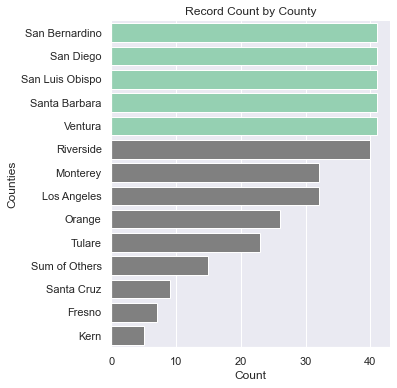

In [19]:
# Countplot of Counties for each year
sb.set(font_scale=1)
sb.set_style('darkgrid')
plt.gcf().set_size_inches(5, 6)

Sentdist=sb.countplot(data=adf, y='County',palette=['#8bdab2','#8bdab2','#8bdab2','#8bdab2','#8bdab2','#808080','#808080',
                                            '#808080','#808080','#808080','#808080','#808080','#808080','#808080'],
                      order = adf['County'].value_counts().index)

plt.title('Record Count by County')
plt.xlabel('Count')
plt.ylabel('Counties')
sb.despine()
plt.show()

In [20]:
# exploratory data analysis: plot of values over the years
# perform groupby
grouped_df = adf.groupby(['Year']).agg({"Yield": ['mean','sum'],"Production": ['mean','sum'], 
                                       "PriceP/U" : 'mean', "Value": "mean",
                                       "HarvestedAcres": ['sum']})
grouped_df.columns = ['Average_Yield','Total_Yield','Average_Production','Total_Production', 'Average_PriceP/U', 'Average_Value', 'Total_HarvestedAcres']
grouped_df = grouped_df.reset_index()

#set Year column as index
grouped_df['Year'] = grouped_df['Year'].astype(str)
grouped_df = grouped_df.set_index('Year')
print(grouped_df)

      Average_Yield  Total_Yield  Average_Production  Total_Production  \
Year                                                                     
1980       2.030909        22.34         8635.636364           94992.0   
1981       3.712727        40.84        19750.363636          217254.0   
1982       3.008333        36.10        18671.500000          224058.0   
1983       3.045833        36.55        21358.583333          256303.0   
1984       2.452500        29.43        24024.083333          288289.0   
1985       2.607273        28.68        21003.636364          231040.0   
1986       2.200000        24.20        19128.363636          210412.0   
1987       3.138182        34.52        25755.727273          283313.0   
1988       2.684545        29.53        18919.181818          208111.0   
1989       2.132727        23.46        14894.181818          163836.0   
1990       1.958182        21.54        10707.454545          117782.0   
1991       1.996250        15.97      

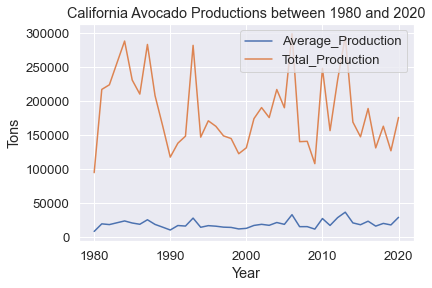

In [21]:
# Line plots of time series for Production
sb.set(font_scale=1.2)
grouped_df[['Average_Production','Total_Production']].plot()
plt.title('California Avocado Productions between 1980 and 2020')
plt.ylabel('Tons')
plt.show()

<Figure size 576x720 with 0 Axes>

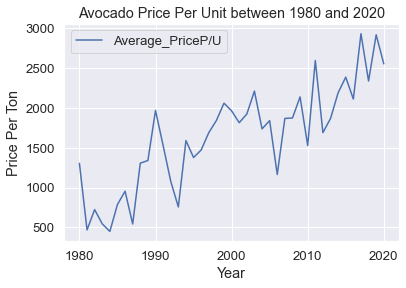

In [22]:
sb.set(font_scale=1.2)
plt.gcf().set_size_inches(8, 10)

# Line plots of time series for Average P/U
grouped_df[['Average_PriceP/U']].plot()
plt.title('Avocado Price Per Unit between 1980 and 2020')
plt.ylabel('Price Per Ton')
plt.show()

## Reading, Merging & Cleaning California County Weather Data

#### Weather by Region Data Source 1980-2020
https://www.weather.gov/wrh/Climate?wfo=mtr

Product Description: MONTHLY SUMMARIZED DATA - calculates averages, totals, daily extremes or frequencies for the selected variable for each month of the year for the selected range of years. Note: trace precipition/snowfall/snow depth amounts are treated as zero in sums, mean, and number of days counts. Annual average temperatures are the average of the twelve monthly values. Temperatures are reported in degrees F; precipitation, snowfall and snow depth are reported in inches.

Areas counties fell in for data collection: Kern is in Bakersfield CA area Fresno is in Fresno CA area Tulare is in Visalia-Porterville CA area San Bernardino is in Riverside CA area Riverside is in Riverside CA area San Diego is in San Diego CA area Los Angeles refers to Santa Monica which is in the Long Beach Area Orange is in the Long Beach Area Santa Barbara is in the Long Beach Area San Luis Obispo is in the Long Beach Area Ventura is in the Long Beach Area Santa Cruz is in the Long Beach Area Monterey is in San Francisco, Monterey WFO area

In [23]:
#Monthly Weather Data
fresno=pd.read_csv('Data/Fresno_Weather.csv')
kern=pd.read_csv('Data/Kern_Weather.csv')
LA=pd.read_csv('Data/LA_O_SB_SLO_V_SC_Weather.csv')
mntrey=pd.read_csv('Data/Monterey_Weather.csv')
sanbern=pd.read_csv('Data/SanBernardino_Riverside_Weather.csv')
SD=pd.read_csv('Data/SanDiego_Weather.csv')
tulare=pd.read_csv('Data/Tulare_Weather.csv')

In [24]:
adf_kern=adf.loc[adf['County']=='Kern'] #subset of Kern data
#merged on left, only need weather data for years where avocado production data is available
#dates wil nas will be 0, indicative of none of these grants being issues
adf_kern=adf_kern.merge(kern, on='Year', how='left') 
adf_kern

Year  CountyCode County  HarvestedAcres  Yield  Production  PriceP/U  \
0  1984          29   Kern           172.0   0.67       116.0     441.0   
1  1983          29   Kern           180.0   3.27       588.0     520.0   
2  1982          29   Kern           241.0   3.53       851.0     530.0   
3  1981          29   Kern           186.0   2.68       498.0     482.0   
4  1980          29   Kern           240.0   3.28       788.0     500.0   

      Value  Avg_Temp  Avg_Prec  
0   51200.0      64.1      0.01  
1  306000.0      64.7      0.03  
2  451000.0      66.2      0.02  
3  240000.0      67.7      0.02  
4  394000.0      66.0      0.02

In [25]:
#Repeat creation of subsets for remaining counties
adf_la=adf.loc[(adf['County']=='Los Angeles')|(adf['County']=='Orange')|(adf['County']=='Santa Barbara')|(adf['County']=='San Luis Obispo')|(adf['County']=='Ventura')|(adf['County']=='Santa Cruz')]
adf_fres=adf.loc[adf['County']=='Fresno']
adf_mon=adf.loc[adf['County']=='Monterey']
adf_sbrs=adf.loc[(adf['County']=='San Bernardino')|(adf['County']=='Riverside')]
adf_sd=adf.loc[adf['County']=='San Diego']
adf_tul=adf.loc[adf['County']=='Tulare']
#Repeat mergining of these subsets with weather data
adf_la=adf_la.merge(LA, on='Year', how='left') 
adf_fres=adf_fres.merge(fresno, on='Year', how='left') 
adf_mon=adf_mon.merge(mntrey, on='Year', how='left') 
adf_sbrs=adf_sbrs.merge(sanbern, on='Year', how='left') 
adf_sd=adf_sd.merge(SD, on='Year', how='left') 
adf_tul=adf_tul.merge(tulare, on='Year', how='left') 

In [26]:
adf_mon # only county with missing data
#interpolation needed for missing values

Year  CountyCode    County  HarvestedAcres  Yield  Production  PriceP/U  \
0   2020          53  Monterey           223.0   5.56      1240.0   2379.84   
1   2019          53  Monterey           225.0   6.58      1480.0   2500.00   
2   2018          53  Monterey           256.0   4.53      1160.0   2250.00   
3   2017          53  Monterey           383.0   3.08      1180.0   3239.83   
4   2016          53  Monterey           245.0   5.39      1320.0   2430.30   
5   2015          53  Monterey           229.0   2.20       503.0   2910.54   
6   2014          53  Monterey           229.0   2.51       575.0   2120.00   
7   2013          53  Monterey           237.0   5.99      1420.0   2114.08   
8   2012          53  Monterey           226.0   1.67       377.0   1527.85   
9   2011          53  Monterey           226.0   2.07       468.0   2403.85   
10  2010          53  Monterey           227.0   3.50       795.0   1540.88   
11  2009          53  Monterey           221.0   0.50       111.0   2198.20   
12  2008          53  Monterey           221.0   1.58       350.0   1948.57   
13  2007          53  Monterey           221.0   1.07       237.0   2160.34   
14  2006          53  Monterey           221.0   2.82       623.0   1505.62   
15  2005          53  Monterey           175.0   1.98       346.0   2326.59   
16  2004          53  Monterey           134.0   2.05       275.0   1607.27   
17  2003          53  Monterey           135.0   1.42       192.0   2625.00   
18  2002          53  Monterey           135.0   1.51       204.0   2397.00   
19  2001          53  Monterey           142.0   2.97       422.0   2137.00   
20  2000          53  Monterey           157.0   0.54        85.0    765.00   
21  1999          53  Monterey           104.0   0.92        96.0    760.00   
22  1998          53  Monterey            92.0   5.62       517.0   3193.00   
23  1997          53  Monterey            92.0   7.16       659.0   2263.00   
24  1996          53  Monterey            95.0   2.88       274.0   1299.00   
25  1995          53  Monterey            95.0   2.95       280.0    961.00   
26  1994          53  Monterey            95.0   3.48       331.0   1202.00   
27  1993          53  Monterey            89.0   2.11       188.0    681.00   
28  1990          53  Monterey            40.0   1.10        44.0   1255.00   
29  1989          53  Monterey            31.0   2.48        77.0    691.00   
30  1988          53  Monterey            55.0   3.44       189.0    937.00   
31  1987          53  Monterey            55.0   1.40        77.0    429.00   

        Value Avg_Temp Avg_Prec  
0   2951000.0        M        M  
1   3700000.0     52.6     0.16  
2   2610000.0     56.9     0.04  
3   3823000.0       57     0.05  
4   3208000.0     57.3     0.05  
5   1464000.0     58.3     0.03  
6   1219000.0     58.4     0.05  
7   3002000.0     55.4     0.01  
8    576000.0     55.1     0.04  
9   1125000.0     54.9     0.05  
10  1225000.0     55.6     0.06  
11   244000.0     55.7     0.04  
12   682000.0     55.1     0.04  
13   512000.0     55.2     0.02  
14   938000.0     56.4     0.05  
15   805000.0     57.9     0.06  
16   442000.0     58.1     0.04  
17   504000.0     58.2     0.04  
18   489000.0     56.9     0.03  
19   902000.0       57     0.05  
20    65000.0     57.6     0.06  
21    73000.0     56.4     0.04  
22  1651000.0     57.3      0.1  
23  1491000.0     59.5     0.05  
24   356000.0     58.5     0.06  
25   269000.0       61     0.01  
26   398000.0        M        M  
27   128000.0        M        M  
28    55200.0        M        M  
29    53200.0        M        M  
30   177000.0        M        M  
31    33000.0        M        M

In [27]:
# Replacing empty cells with NaN
adf_mon=adf_mon.replace('M', np.nan)

In [28]:
# Adjust data types 
for column in ['Avg_Temp','Avg_Prec']:
    adf_mon[column]=adf_mon[column].astype('float64',errors='raise')
adf_mon.dtypes

Year                int64
CountyCode          int64
County             object
HarvestedAcres    float64
Yield             float64
Production        float64
PriceP/U          float64
Value             float64
Avg_Temp          float64
Avg_Prec          float64
dtype: object

In [29]:
adf_mon=adf_mon.interpolate(limit_direction='both') #allows the NaN in the first row to be interpolated
adf_mon

Year  CountyCode    County  HarvestedAcres  Yield  Production  PriceP/U  \
0   2020          53  Monterey           223.0   5.56      1240.0   2379.84   
1   2019          53  Monterey           225.0   6.58      1480.0   2500.00   
2   2018          53  Monterey           256.0   4.53      1160.0   2250.00   
3   2017          53  Monterey           383.0   3.08      1180.0   3239.83   
4   2016          53  Monterey           245.0   5.39      1320.0   2430.30   
5   2015          53  Monterey           229.0   2.20       503.0   2910.54   
6   2014          53  Monterey           229.0   2.51       575.0   2120.00   
7   2013          53  Monterey           237.0   5.99      1420.0   2114.08   
8   2012          53  Monterey           226.0   1.67       377.0   1527.85   
9   2011          53  Monterey           226.0   2.07       468.0   2403.85   
10  2010          53  Monterey           227.0   3.50       795.0   1540.88   
11  2009          53  Monterey           221.0   0.50       111.0   2198.20   
12  2008          53  Monterey           221.0   1.58       350.0   1948.57   
13  2007          53  Monterey           221.0   1.07       237.0   2160.34   
14  2006          53  Monterey           221.0   2.82       623.0   1505.62   
15  2005          53  Monterey           175.0   1.98       346.0   2326.59   
16  2004          53  Monterey           134.0   2.05       275.0   1607.27   
17  2003          53  Monterey           135.0   1.42       192.0   2625.00   
18  2002          53  Monterey           135.0   1.51       204.0   2397.00   
19  2001          53  Monterey           142.0   2.97       422.0   2137.00   
20  2000          53  Monterey           157.0   0.54        85.0    765.00   
21  1999          53  Monterey           104.0   0.92        96.0    760.00   
22  1998          53  Monterey            92.0   5.62       517.0   3193.00   
23  1997          53  Monterey            92.0   7.16       659.0   2263.00   
24  1996          53  Monterey            95.0   2.88       274.0   1299.00   
25  1995          53  Monterey            95.0   2.95       280.0    961.00   
26  1994          53  Monterey            95.0   3.48       331.0   1202.00   
27  1993          53  Monterey            89.0   2.11       188.0    681.00   
28  1990          53  Monterey            40.0   1.10        44.0   1255.00   
29  1989          53  Monterey            31.0   2.48        77.0    691.00   
30  1988          53  Monterey            55.0   3.44       189.0    937.00   
31  1987          53  Monterey            55.0   1.40        77.0    429.00   

        Value  Avg_Temp  Avg_Prec  
0   2951000.0      52.6      0.16  
1   3700000.0      52.6      0.16  
2   2610000.0      56.9      0.04  
3   3823000.0      57.0      0.05  
4   3208000.0      57.3      0.05  
5   1464000.0      58.3      0.03  
6   1219000.0      58.4      0.05  
7   3002000.0      55.4      0.01  
8    576000.0      55.1      0.04  
9   1125000.0      54.9      0.05  
10  1225000.0      55.6      0.06  
11   244000.0      55.7      0.04  
12   682000.0      55.1      0.04  
13   512000.0      55.2      0.02  
14   938000.0      56.4      0.05  
15   805000.0      57.9      0.06  
16   442000.0      58.1      0.04  
17   504000.0      58.2      0.04  
18   489000.0      56.9      0.03  
19   902000.0      57.0      0.05  
20    65000.0      57.6      0.06  
21    73000.0      56.4      0.04  
22  1651000.0      57.3      0.10  
23  1491000.0      59.5      0.05  
24   356000.0      58.5      0.06  
25   269000.0      61.0      0.01  
26   398000.0      61.0      0.01  
27   128000.0      61.0      0.01  
28    55200.0      61.0      0.01  
29    53200.0      61.0      0.01  
30   177000.0      61.0      0.01  
31    33000.0      61.0      0.01

In [30]:
#Concatenate county subsets
adf=pd.concat([adf_kern,adf_la,adf_fres,adf_mon,adf_sbrs,adf_sd,adf_tul])
print(adf.head(20))

    Year  CountyCode           County  HarvestedAcres  Yield  Production  \
0   1984          29             Kern           172.0   0.67       116.0   
1   1983          29             Kern           180.0   3.27       588.0   
2   1982          29             Kern           241.0   3.53       851.0   
3   1981          29             Kern           186.0   2.68       498.0   
4   1980          29             Kern           240.0   3.28       788.0   
0   2020          79  San Luis Obispo          4240.0   5.90     25000.0   
1   2020          83    Santa Barbara          5770.0   4.89     28200.0   
2   2020         111          Ventura         16400.0   4.29     70300.0   
3   2019          79  San Luis Obispo          4440.0   2.75     12200.0   
4   2019          83    Santa Barbara          5410.0   1.98     10700.0   
5   2019         111          Ventura         16500.0   3.02     49800.0   
6   2018          79  San Luis Obispo          4160.0   4.62     19200.0   
7   2018    

## Reading, Merging & Cleaning California Wildfire Data
https://hub-calfire-forestry.hub.arcgis.com/search?categories=cal%20fire%20public%20data&tags=Fire%20and%20Fuels



Counties most vulnerable to wildfires
https://www.sacbee.com/news/california/fires/article261493087.html

In [31]:
#load cali wild fire data set
wildfire = pd.read_csv('Data/California_Wildland_Fire_Perimeters_(All).csv')
wildfire

OBJECTID   YEAR_ STATE AGENCY UNIT_ID  FIRE_NAME   INC_NUM  \
0         21440  2020.0    CA    CDF     NEU     NELSON  00013212   
1         21441  2020.0    CA    CDF     NEU    AMORUSO  00011799   
2         21442  2020.0    CA    CDF     NEU     ATHENS  00018493   
3         21443  2020.0    CA    CDF     NEU    FLEMING  00007619   
4         21444  2020.0    CA    CDF     NEU   MELANESE  00008471   
...         ...     ...   ...    ...     ...        ...       ...   
21683     43191  2008.0    CA    USF     SHF       EAST       NaN   
21684     43192  2008.0    CA    USF     SNF       STAR  00000715   
21685     43195  2008.0    CA    CDF     SHU  COLEMAN 1  00001108   
21686     43196  2008.0    CA    USF     SHF    DEDRICK       NaN   
21687     43197  2021.0    CA    USF     PNF      DOTTA  00001010   

                   ALARM_DATE               CONT_DATE  CAUSE COMMENTS  \
0      2020/06/18 00:00:00+00  2020/06/23 00:00:00+00   11.0      NaN   
1      2020/06/01 00:00:00+00  2020/06/04 00:00:00+00    2.0      NaN   
2      2020/08/10 00:00:00+00  2020/03/01 00:00:00+00   14.0      NaN   
3      2020/03/31 00:00:00+00  2020/04/01 00:00:00+00    9.0      NaN   
4      2020/04/14 00:00:00+00  2020/04/19 00:00:00+00   18.0      NaN   
...                       ...                     ...    ...      ...   
21683                     NaN  2008/06/29 00:00:00+00    1.0      NaN   
21684  2008/06/21 00:00:00+00  2008/07/14 00:00:00+00    1.0      NaN   
21685                     NaN                     NaN   14.0      NaN   
21686                     NaN  2008/06/29 00:00:00+00    1.0      NaN   
21687  2021/06/30 00:00:00+00  2021/07/22 00:00:00+00   14.0      NaN   

       REPORT_AC   GIS_ACRES  C_METHOD  OBJECTIVE  FIRE_NUM   Shape__Area  \
0          110.0  109.602280       1.0        1.0       NaN  7.331347e+05   
1          670.0  685.585022       1.0        1.0       NaN  4.578172e+06   
2           26.0   27.300480       1.0        1.0       NaN  1.823876e+05   
3           13.0   12.931545       1.0        1.0       NaN  8.667942e+04   
4           10.3   10.315964       1.0        1.0       NaN  7.017912e+04   
...          ...         ...       ...        ...       ...           ...   
21683        NaN   39.796280       7.0        1.0       NaN  2.817346e+05   
21684      250.0  267.612793       8.0        1.0  00000018  1.724713e+06   
21685        NaN  155.260223       8.0        1.0       NaN  1.084790e+06   
21686        NaN   38.873161       7.0        1.0       NaN  2.751917e+05   
21687        NaN  531.909973       8.0        1.0       NaN  3.664169e+06   

       Shape__Length        COMPLEX_NAME COMPLEX_INCNUM  
0        4179.743142                 NaN            NaN  
1       12399.375391                 NaN            NaN  
2        2119.194120                 NaN            NaN  
3        2029.524881                 NaN            NaN  
4        1342.742903                 NaN            NaN  
...              ...                 ...            ...  
21683    2009.785182        IRON COMPLEX       00001057  
21684   20027.055552      SILVER COMPLEX       00000715  
21685    4968.611848                 NaN            NaN  
21686    2484.561959        IRON COMPLEX       00001057  
21687   16139.457040  BECKWOURTH COMPLEX       00001064  

[21688 rows x 20 columns]

In [32]:
#keep only relevent columns
wildfire = wildfire[['YEAR_', 'FIRE_NAME']]

wildfire = wildfire.rename(columns={"YEAR_": "Year"})

print(wildfire.dtypes)

Year         float64
FIRE_NAME     object
dtype: object


In [33]:
#check null values
print(wildfire.isnull().sum())


wildfire = wildfire.dropna(subset= ["Year"], axis=0)

Year          77
FIRE_NAME    124
dtype: int64


In [34]:
# perform groupby for each year
wildfire_grouped_df = wildfire.groupby(['Year']).agg({"FIRE_NAME": 'count'})
wildfire_grouped_df.columns = ['Fire_Count']
wildfire_grouped_df = wildfire_grouped_df.reset_index()
wildfire_grouped_df = wildfire_grouped_df.loc[(wildfire_grouped_df['Year'] > 1979.0) & (wildfire_grouped_df['Year'] < 2021.0) ]
print(wildfire_grouped_df)
print(wildfire_grouped_df.dtypes)

       Year  Fire_Count
82   1980.0         313
83   1981.0         271
84   1982.0         145
85   1983.0         159
86   1984.0         217
87   1985.0         209
88   1986.0         172
89   1987.0         286
90   1988.0         257
91   1989.0         181
92   1990.0         175
93   1991.0          89
94   1992.0         197
95   1993.0         172
96   1994.0         217
97   1995.0         208
98   1996.0         319
99   1997.0         187
100  1998.0         163
101  1999.0         279
102  2000.0         192
103  2001.0         207
104  2002.0         243
105  2003.0         341
106  2004.0         277
107  2005.0         306
108  2006.0         316
109  2007.0         347
110  2008.0         440
111  2009.0         254
112  2010.0         209
113  2011.0         316
114  2012.0         352
115  2013.0         298
116  2014.0         238
117  2015.0         309
118  2016.0         349
119  2017.0         607
120  2018.0         410
121  2019.0         312
122  2020.0     

In [35]:
# Adjust data type for Year
wildfire_grouped_df['Year']=wildfire_grouped_df['Year'].astype('int64',errors='raise')

adf=adf.merge(wildfire_grouped_df, on='Year', how='left') 
print(adf.head())

   Year  CountyCode County  HarvestedAcres  Yield  Production  PriceP/U  \
0  1984          29   Kern           172.0   0.67       116.0     441.0   
1  1983          29   Kern           180.0   3.27       588.0     520.0   
2  1982          29   Kern           241.0   3.53       851.0     530.0   
3  1981          29   Kern           186.0   2.68       498.0     482.0   
4  1980          29   Kern           240.0   3.28       788.0     500.0   

      Value  Avg_Temp Avg_Prec  Fire_Count  
0   51200.0      64.1     0.01         217  
1  306000.0      64.7     0.03         159  
2  451000.0      66.2     0.02         145  
3  240000.0      67.7     0.02         271  
4  394000.0      66.0     0.02         313  


In [36]:
print(adf.dtypes)

Year                int64
CountyCode          int64
County             object
HarvestedAcres    float64
Yield             float64
Production        float64
PriceP/U          float64
Value             float64
Avg_Temp          float64
Avg_Prec           object
Fire_Count          int64
dtype: object


### Aggregated Avocado Yearly Trends for all of CA 

adf includes data for every year by county
adf_grouped aggregates the data for all of CA by year

In [37]:
# perform groupby
# perform groupby
adf_grouped = adf.groupby(['Year']).agg({"HarvestedAcres": ["mean","sum"]
                                         ,"Yield": ["mean","sum"]
                                         ,"Production": ["mean","sum"]
                                         ,"PriceP/U" : "mean"
                                         , "Value": "mean"
                                         ,"Fire_Count":"mean"})
adf_grouped.columns = ['Avg_HarvestedAcres','Total_HarvestedAcres','Avg_Yield'
                       ,'Total_Yield','Avg_Production','Total_Production'
                       ,'Avg_PriceP/U', 'Avg_Value','Fire_Count']
adf_grouped = adf_grouped.reset_index()
adf_grouped

Year  Avg_HarvestedAcres  Total_HarvestedAcres  Avg_Yield  Total_Yield  \
0   1980         4656.000000               51216.0   2.030909        22.34   
1   1981         5109.090909               56200.0   3.712727        40.84   
2   1982         5171.500000               62058.0   3.008333        36.10   
3   1983         5860.083333               70321.0   3.045833        36.55   
4   1984         6065.750000               72789.0   2.452500        29.43   
5   1985         6684.818182               73533.0   2.607273        28.68   
6   1986         6793.818182               74732.0   2.200000        24.20   
7   1987         6845.181818               75297.0   3.138182        34.52   
8   1988         6940.909091               76350.0   2.684545        29.53   
9   1989         6803.545455               74839.0   2.132727        23.46   
10  1990         6512.545455               71638.0   1.958182        21.54   
11  1991         8159.500000               65276.0   1.996250        15.97   
12  1992         7539.000000               67851.0   2.137778        19.24   
13  1993         6588.800000               65888.0   3.880000        38.80   
14  1994         6620.100000               66201.0   2.714000        27.14   
15  1995         6161.400000               61614.0   3.607000        36.07   
16  1996         5633.500000               56335.0   3.632000        36.32   
17  1997         5671.700000               56717.0   3.813000        38.13   
18  1998         6181.500000               61815.0   3.382000        33.82   
19  1999         6104.000000               61040.0   1.945000        19.45   
20  2000         6098.400000               60984.0   2.400000        24.00   
21  2001         6062.600000               60626.0   3.149000        31.49   
22  2002         6418.000000               64180.0   2.929000        29.29   
23  2003         6402.200000               64022.0   2.819000        28.19   
24  2004         7365.666667               66291.0   3.095556        27.86   
25  2005         7503.777778               67534.0   2.368889        21.32   
26  2006         7830.125000               62641.0   4.053750        32.43   
27  2007         7876.875000               63015.0   2.015000        16.12   
28  2008         8084.500000               64676.0   2.440000        19.52   
29  2009         7650.250000               61202.0   1.773750        14.19   
30  2010         7055.875000               56447.0   3.983750        31.87   
31  2011         6664.375000               53315.0   2.645000        21.16   
32  2012         8645.571429               60519.0   3.448571        24.14   
33  2013         8598.571429               60190.0   4.777143        33.44   
34  2014         8018.428571               56129.0   3.098571        21.69   
35  2015         7683.428571               53784.0   2.674286        18.72   
36  2016         7161.428571               50130.0   4.162857        29.14   
37  2017         6590.000000               46130.0   2.901429        20.31   
38  2018         6981.857143               48873.0   3.870000        27.09   
39  2019         6401.714286               44812.0   3.674286        25.72   
40  2020         6900.500000               41403.0   4.385000        26.31   

    Avg_Production  Total_Production  Avg_PriceP/U     Avg_Value  Fire_Count  
0      8635.636364           94992.0   1304.454545  1.329897e+07       313.0  
1     19750.363636          217254.0    469.818182  1.053825e+07       271.0  
2     18671.500000          224058.0    724.500000  1.219723e+07       145.0  
3     21358.583333          256303.0    545.583333  1.171902e+07       159.0  
4     24024.083333          288289.0    450.833333  1.063543e+07       217.0  
5     21003.636364          231040.0    788.545455  1.581260e+07       209.0  
6     19128.363636          210412.0    954.727273  1.843477e+07       172.0  
7     25755.727273          283313.0    544.272727  1.402362e+07       286.0  
8     18919.1818

## Time Series Plots by California County- All Available Data

In [38]:
# Function that generates time series plots using groupby 
## Intended to generate trends by county over 20-year span
#Reference: https://stackoverflow.com/questions/30942755/plotting-multiple-time-series-after-a-groupby-in-pandas

def plot_gb_time_series(df, date_name, gb_name, value_name, figsize=(15,12), title=None):
#Runs groupby on Pandas dataframe and produces a time series chart.

#Parameters:

#df : Pandas dataframe
##date_name : string
###The name of the df column that has the year

#g b_name : string
## The name of the df column to perform group-by on

# value_name : string
## The name of the df column for the y-axis.


#title : string
## Optional title

   
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df.groupby([gb_name]):
        ax = grp.plot(ax=ax, kind='line', x=date_name, y=value_name, label=key, marker='o')

    ax.autoscale_view()
    ax.legend(bbox_to_anchor=(1.05, 1),loc='upper left') #moves legend outside of graph
    plt.xticks(rotation=45, )
    plt.grid()
    plt.xlabel('')
    plt.ylim(0, df[value_name].max() * 1.25)
    plt.ylabel(value_name)
    if title is not None:
        plt.title(title)
        ax.set_title(title, pad=30) #Adds space between title & plot
    plt.show()

### Exploratory Data Analysis: Wild Fires

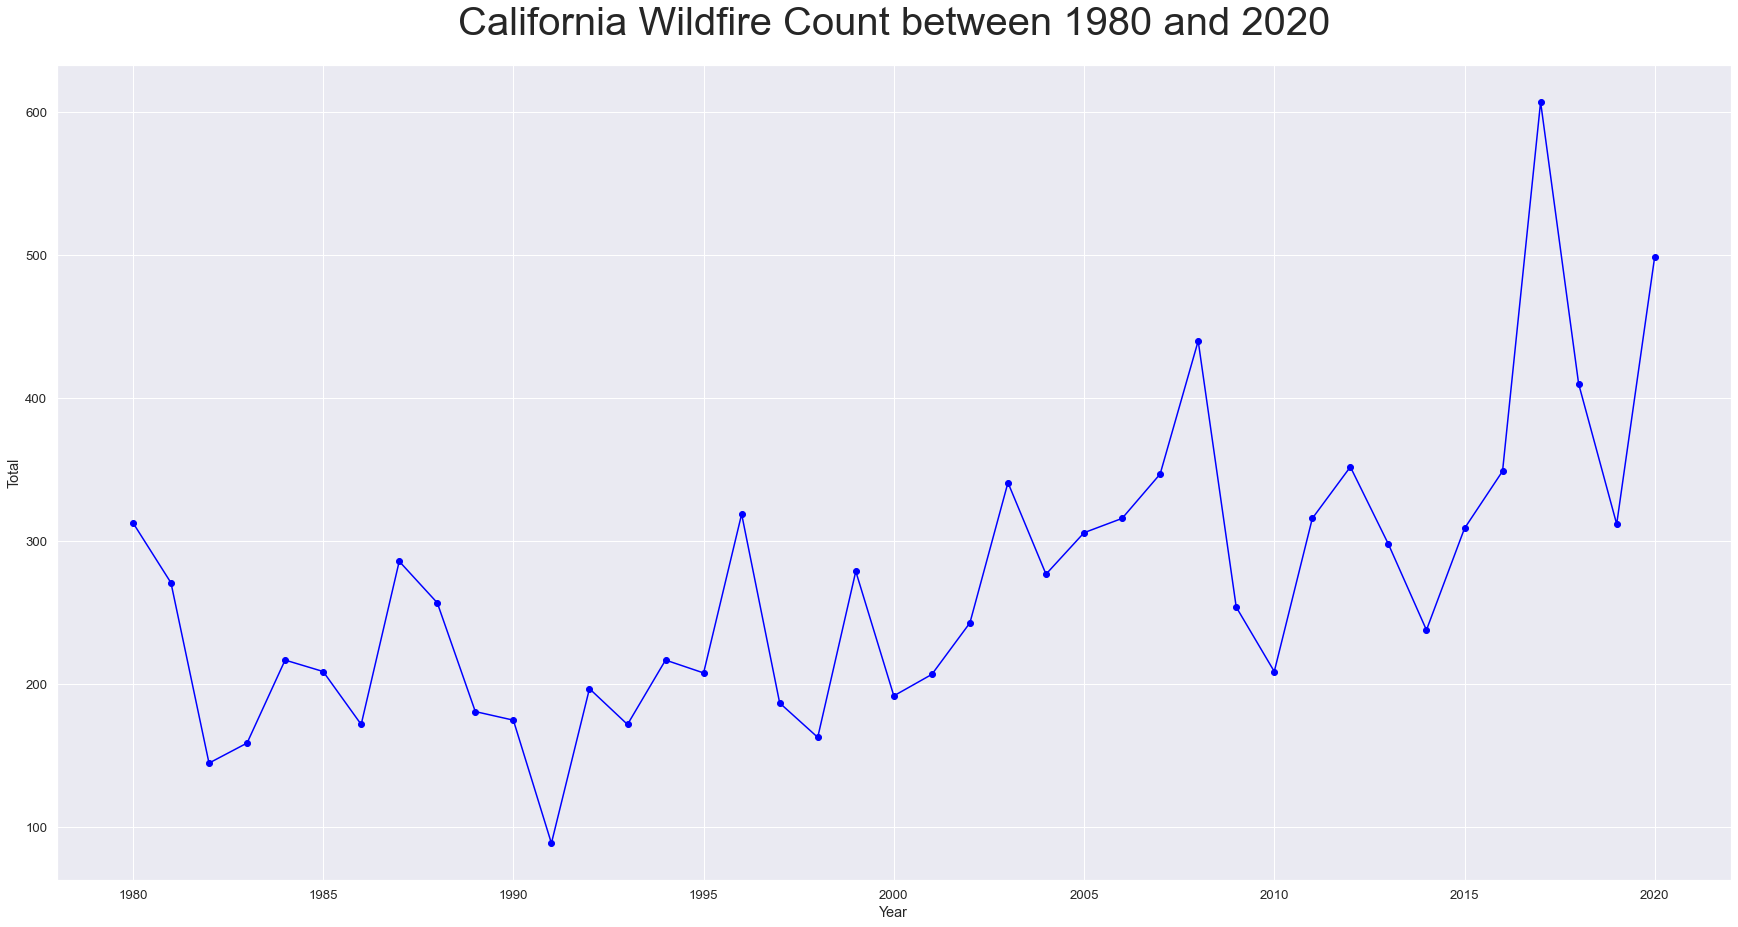

In [39]:
# Line plots of time series for Wild Fires

fig, ax = plt.subplots(figsize=(30, 15))
ax.plot(adf_grouped['Year'], adf_grouped['Fire_Count'],color='blue',marker='o')

plt.rc('axes', titlesize=40)#fontsize of title
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

ax.set_title('California Wildfire Count between 1980 and 2020', pad=30)
plt.xlabel('Year')
plt.ylabel('Total')
plt.show()

### Exploratory Data Analysis: Temperature and Precipitation

In [40]:
# Making a Dataset with Counties that have complete 41-year records
adf_complete=adf.loc[(adf['County']=='San Luis Obispo')
                     |(adf['County']=='Santa Barbara')
                     |(adf['County']=='Ventura')
                     |(adf['County']=='San Bernardino')
                     |(adf['County']=='San Diego')]
adf_complete

Year  CountyCode           County  HarvestedAcres  Yield  Production  \
5    2020          79  San Luis Obispo          4240.0   5.90     25000.0   
6    2020          83    Santa Barbara          5770.0   4.89     28200.0   
7    2020         111          Ventura         16400.0   4.29     70300.0   
8    2019          79  San Luis Obispo          4440.0   2.75     12200.0   
9    2019          83    Santa Barbara          5410.0   1.98     10700.0   
..    ...         ...              ...             ...    ...         ...   
351  1984          73        San Diego         35683.0   4.50    160574.0   
352  1983          73        San Diego         34500.0   4.10    141450.0   
353  1982          73        San Diego         31320.0   4.20    131554.0   
354  1981          73        San Diego         27050.0   3.00     81150.0   
355  1980          73        San Diego         24820.0   2.00     49640.0   

     PriceP/U        Value  Avg_Temp Avg_Prec  Fire_Count  
5     1886.76   47169000.0      65.8     0.02         499  
6     2842.59   80161000.0      65.8     0.02         499  
7     2556.57  179727000.0      65.8     0.02         499  
8     3186.48   38875000.0      65.5     0.06         312  
9     3309.44   35411000.0      65.5     0.06         312  
..        ...          ...       ...      ...         ...  
351    370.00   59412000.0      67.2     0.02         217  
352    540.00   76383000.0      67.0     0.05         159  
353    520.00   68403000.0      65.2     0.04         145  
354    553.00   44876000.0      67.1     0.03         271  
355   1300.00   64532000.0      65.9     0.04         313  

[205 rows x 11 columns]

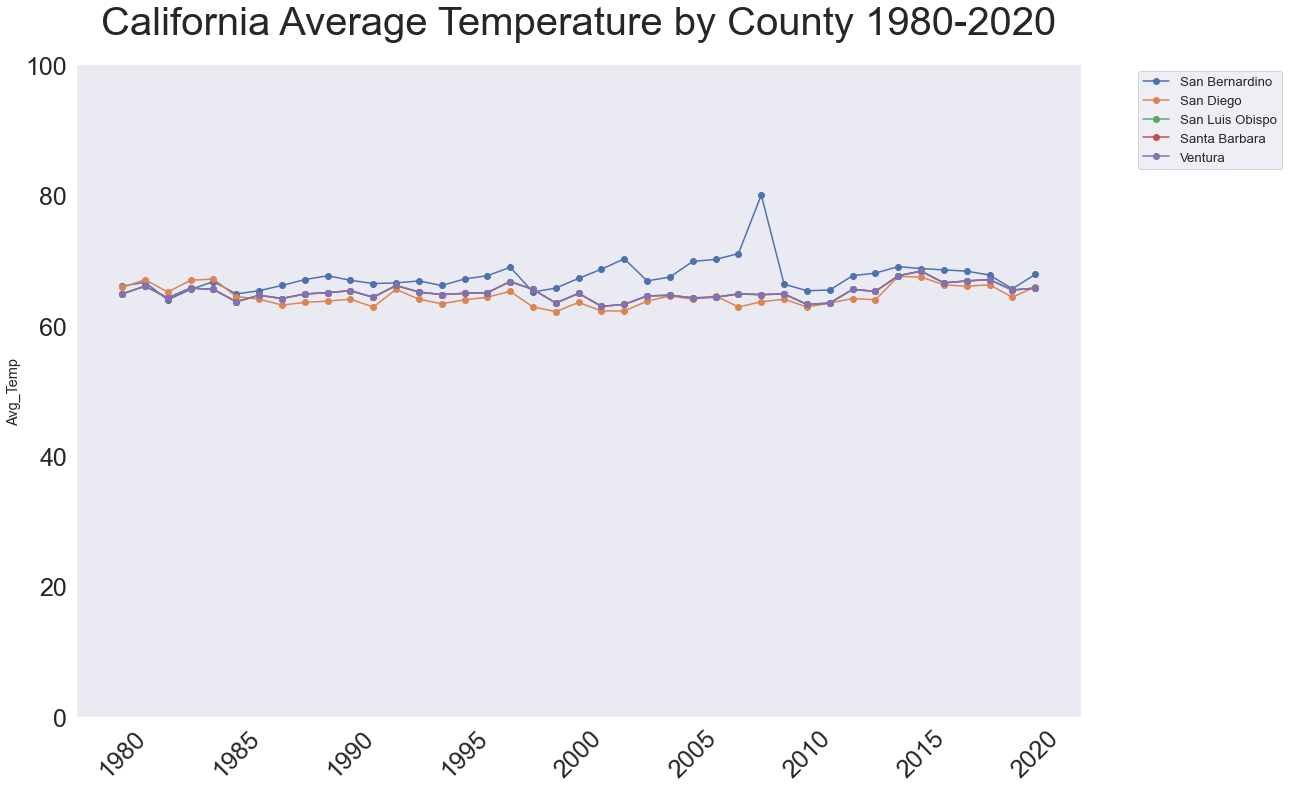

In [41]:
plot_gb_time_series(adf_complete, 'Year', 'County', 'Avg_Temp',
                    figsize=(18, 12), title='California Average Temperature by County 1980-2020')

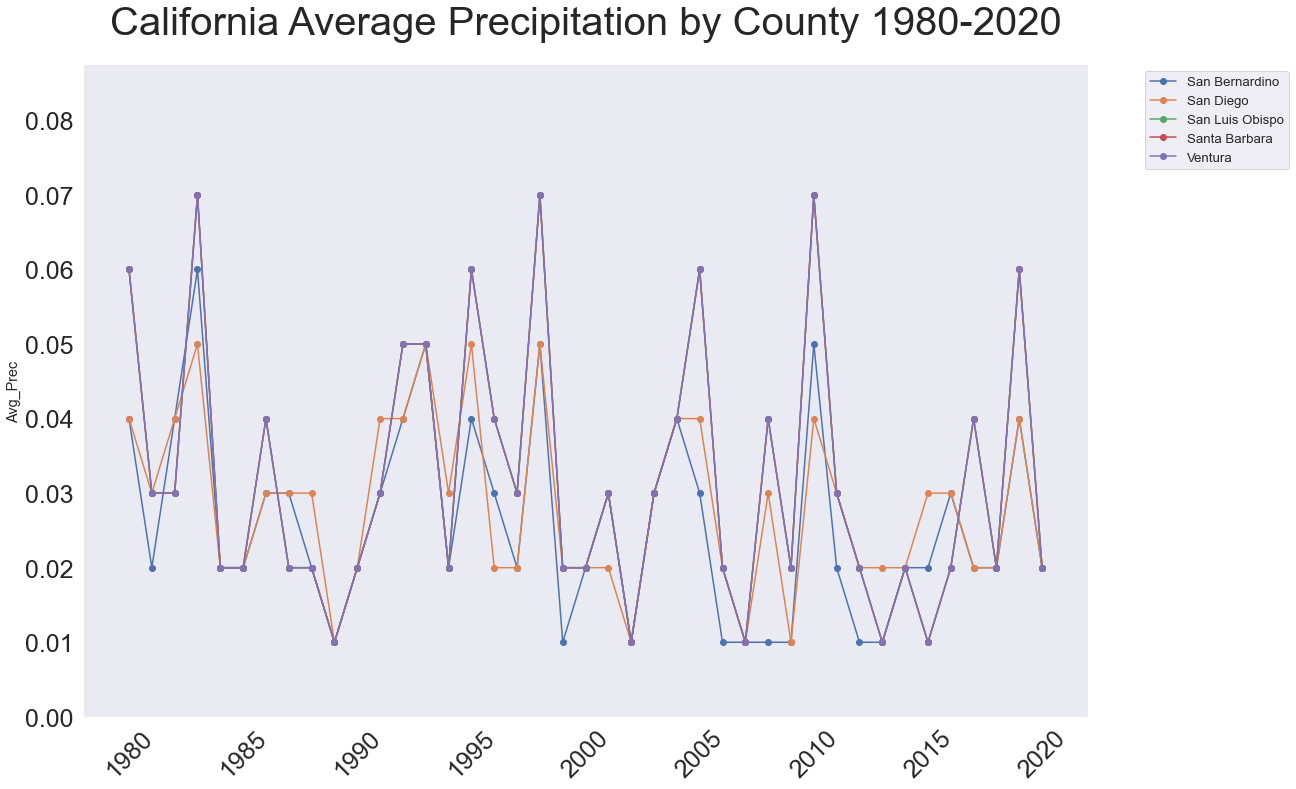

In [42]:
plot_gb_time_series(adf_complete, 'Year', 'County', 'Avg_Prec',
                    figsize=(18, 12), title='California Average Precipitation by County 1980-2020')

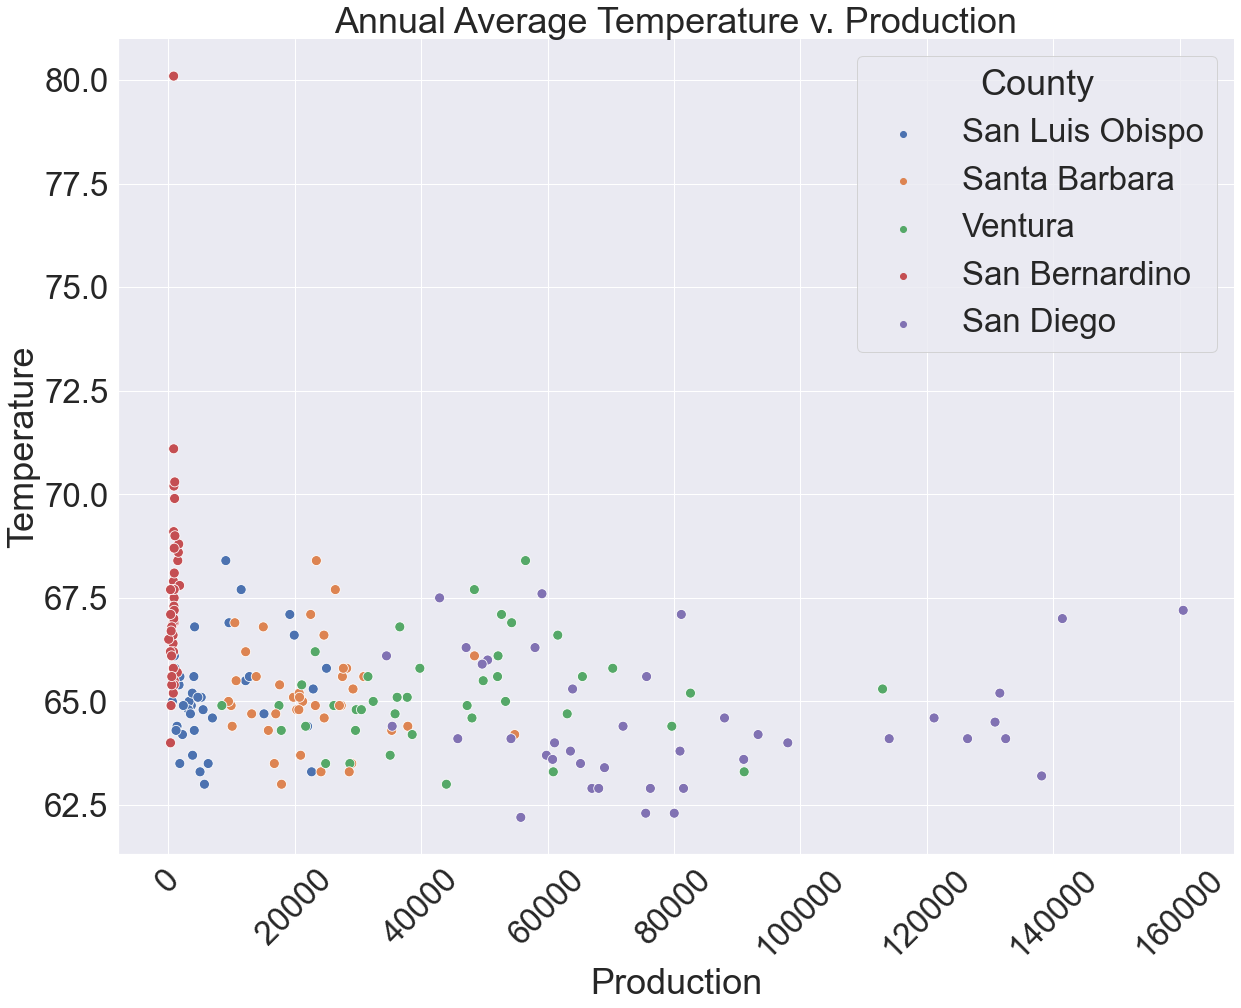

In [43]:
# Scatterplot of production and precipitation/temp by County
sb.set_style('darkgrid')
sb.set_palette('Set2')
sb.set(font_scale=3)
plt.gcf().set_size_inches(20, 15)
sb.scatterplot(x='Production', y='Avg_Temp', data=adf_complete, hue='County',s=100)


plt.title('Annual Average Temperature v. Production')
plt.xlabel('Production')
plt.ylabel('Temperature')
plt.xticks(rotation = 45)
sb.despine()
plt.show()   


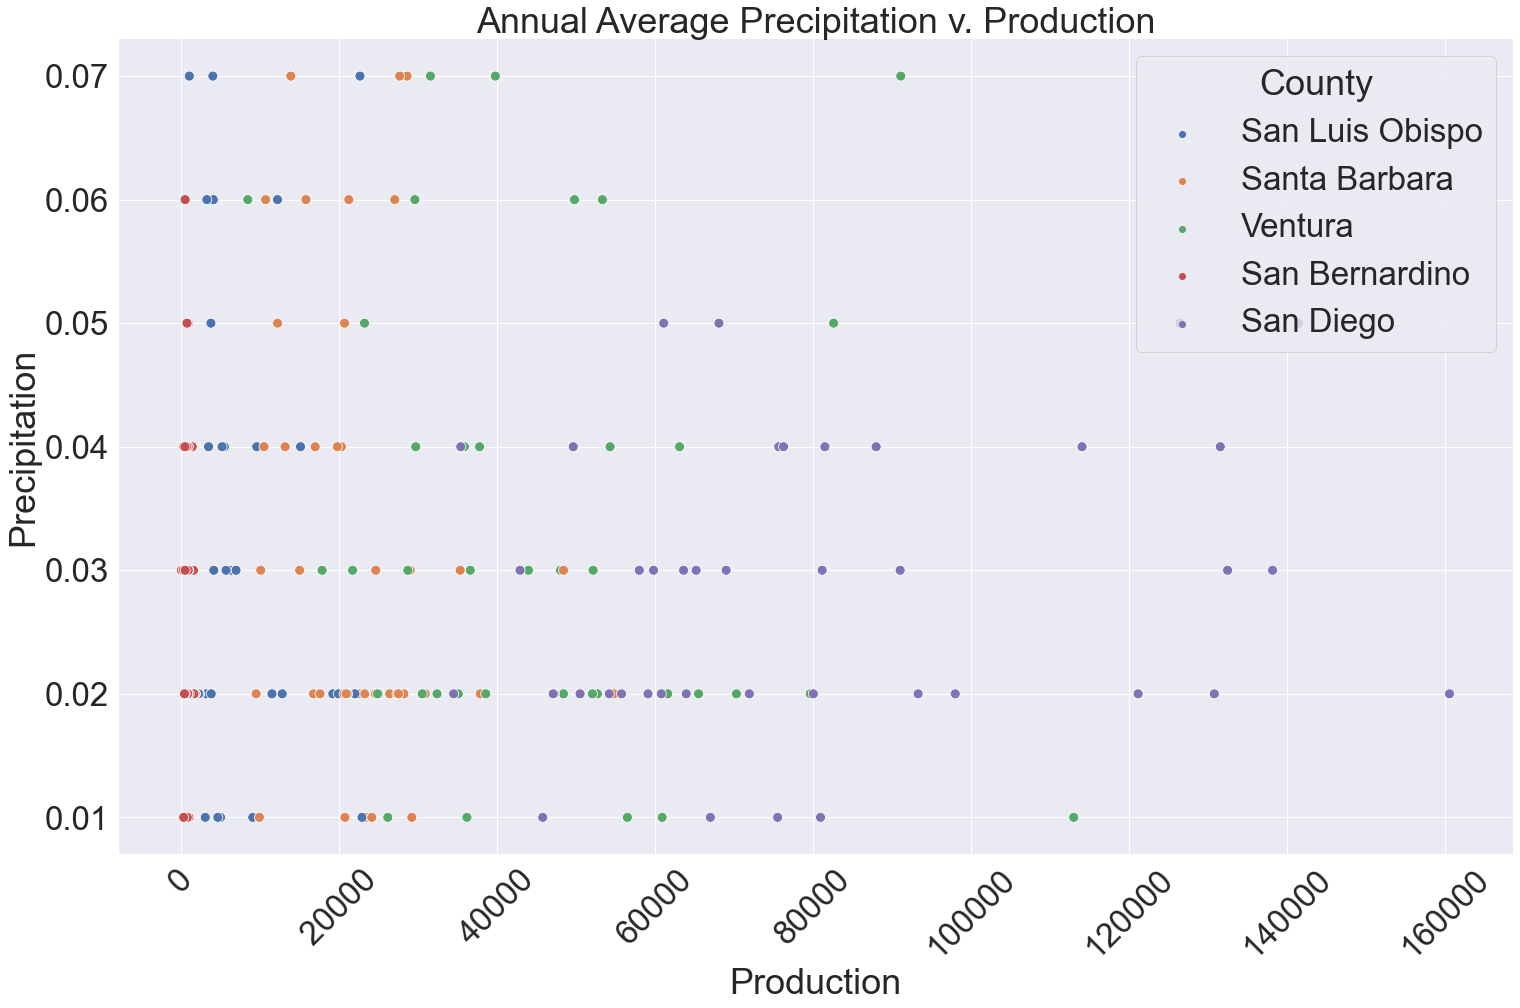

In [44]:
# Scatterplot of production and precipitation/temp by County
sb.set_style('darkgrid')
sb.set_palette('Set2')
sb.set(font_scale=3)
plt.gcf().set_size_inches(25, 15)
sb.scatterplot(x='Production', y='Avg_Prec', data=adf_complete, hue='County',s=100)


plt.title('Annual Average Precipitation v. Production')
plt.xlabel('Production')
plt.ylabel('Precipitation')
plt.xticks(rotation = 45)
sb.despine()
plt.show()  

## Correlation by County & State-wide

In [45]:
ventura=adf_complete.loc[adf_complete['County']=='Ventura']
ventura=ventura.sort_values('Year')
ventura=ventura.drop(['County'],axis=1)
ventura.head()

Year  CountyCode  HarvestedAcres  Yield  Production  PriceP/U  \
194  1980         111         10917.0   0.77      8440.0    1881.0   
189  1981         111         12100.0   4.31     52151.0     520.0   
184  1982         111         12748.0   1.40     17847.0     900.0   
178  1983         111         15636.0   2.54     39778.0     624.0   
172  1984         111         16251.0   3.20     52070.0     543.0   

          Value  Avg_Temp Avg_Prec  Fire_Count  
194  15879000.0      64.9     0.06         313  
189  27100000.0      66.1     0.03         271  
184  16063000.0      64.3     0.03         145  
178  24822000.0      65.8     0.07         159  
172  28258000.0      65.6     0.02         217

In [46]:
SanBern=adf_complete.loc[adf_complete['County']=='San Bernardino']
SanBern=SanBern.sort_values('Year')
SanBern=SanBern.drop(['County'],axis=1)
SanBern.head()

Year  CountyCode  HarvestedAcres  Yield  Production  PriceP/U     Value  \
314  1980          71           120.0   4.06       487.0     528.0  257000.0   
312  1981          71           105.0   4.00       420.0     252.0  106000.0   
310  1982          71           110.0   2.91       320.0     215.0   68800.0   
308  1983          71           120.0   4.30       516.0     242.0  125000.0   
306  1984          71           145.0   3.52       510.0     180.0   91800.0   

     Avg_Temp Avg_Prec  Fire_Count  
314      66.1     0.04         313  
312      66.7     0.02         271  
310      64.0     0.04         145  
308      65.6     0.06         159  
306      66.8     0.02         217

In [47]:
SanBarb=adf_complete.loc[adf_complete['County']=='Santa Barbara']
SanBarb=SanBarb.sort_values('Year')
SanBarb=SanBarb.drop(['County'],axis=1)
SanBarb.head()

Year  CountyCode  HarvestedAcres  Yield  Production  PriceP/U  \
193  1980          83          5367.0   5.04     27050.0    2050.0   
188  1981          83          5630.0   8.60     48418.0     580.0   
182  1982          83          5652.0   6.25     35325.0     940.0   
176  1983          83          6716.0   4.12     27670.0     540.0   
170  1984          83          6863.0   4.01     27521.0     524.0   

          Value  Avg_Temp Avg_Prec  Fire_Count  
193  55452500.0      64.9     0.06         313  
188  28082440.0      66.1     0.03         271  
182  33205500.0      64.3     0.03         145  
176  14941800.0      65.8     0.07         159  
170  14426508.0      65.6     0.02         217

In [48]:
SanLO=adf_complete.loc[adf_complete['County']=='San Luis Obispo']
SanLO=SanLO.sort_values('Year')
SanLO=SanLO.drop(['County'],axis=1)
SanLO.head()

Year  CountyCode  HarvestedAcres  Yield  Production  PriceP/U      Value  \
192  1980          79           737.0   0.54       398.0    1930.0   768000.0   
187  1981          79           833.0   1.12       933.0     520.0   485000.0   
181  1982          79           843.0   1.42      1197.0     930.0  1113000.0   
175  1983          79          1523.0   0.68      1036.0     624.0   646500.0   
169  1984          79          1523.0   1.19      1812.0     540.0   978500.0   

     Avg_Temp Avg_Prec  Fire_Count  
192      64.9     0.06         313  
187      66.1     0.03         271  
181      64.3     0.03         145  
175      65.8     0.07         159  
169      65.6     0.02         217

In [49]:
SanDie=adf_complete.loc[adf_complete['County']=='San Diego']
SanDie=SanDie.sort_values('Year')
SanDie=SanDie.drop(['County'],axis=1)
SanDie.head()

Year  CountyCode  HarvestedAcres  Yield  Production  PriceP/U  \
355  1980          73         24820.0    2.0     49640.0    1300.0   
354  1981          73         27050.0    3.0     81150.0     553.0   
353  1982          73         31320.0    4.2    131554.0     520.0   
352  1983          73         34500.0    4.1    141450.0     540.0   
351  1984          73         35683.0    4.5    160574.0     370.0   

          Value  Avg_Temp Avg_Prec  Fire_Count  
355  64532000.0      65.9     0.04         313  
354  44876000.0      67.1     0.03         271  
353  68403000.0      65.2     0.04         145  
352  76383000.0      67.0     0.05         159  
351  59412000.0      67.2     0.02         217

/var/folders/9j/4y0rr5217t16n6j3w89t3yp80000gn/T/ipykernel_2006/3997594420.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(fcorr, dtype=np.bool)


<AxesSubplot:title={'center':'Ventura County Correlation Plot'}>

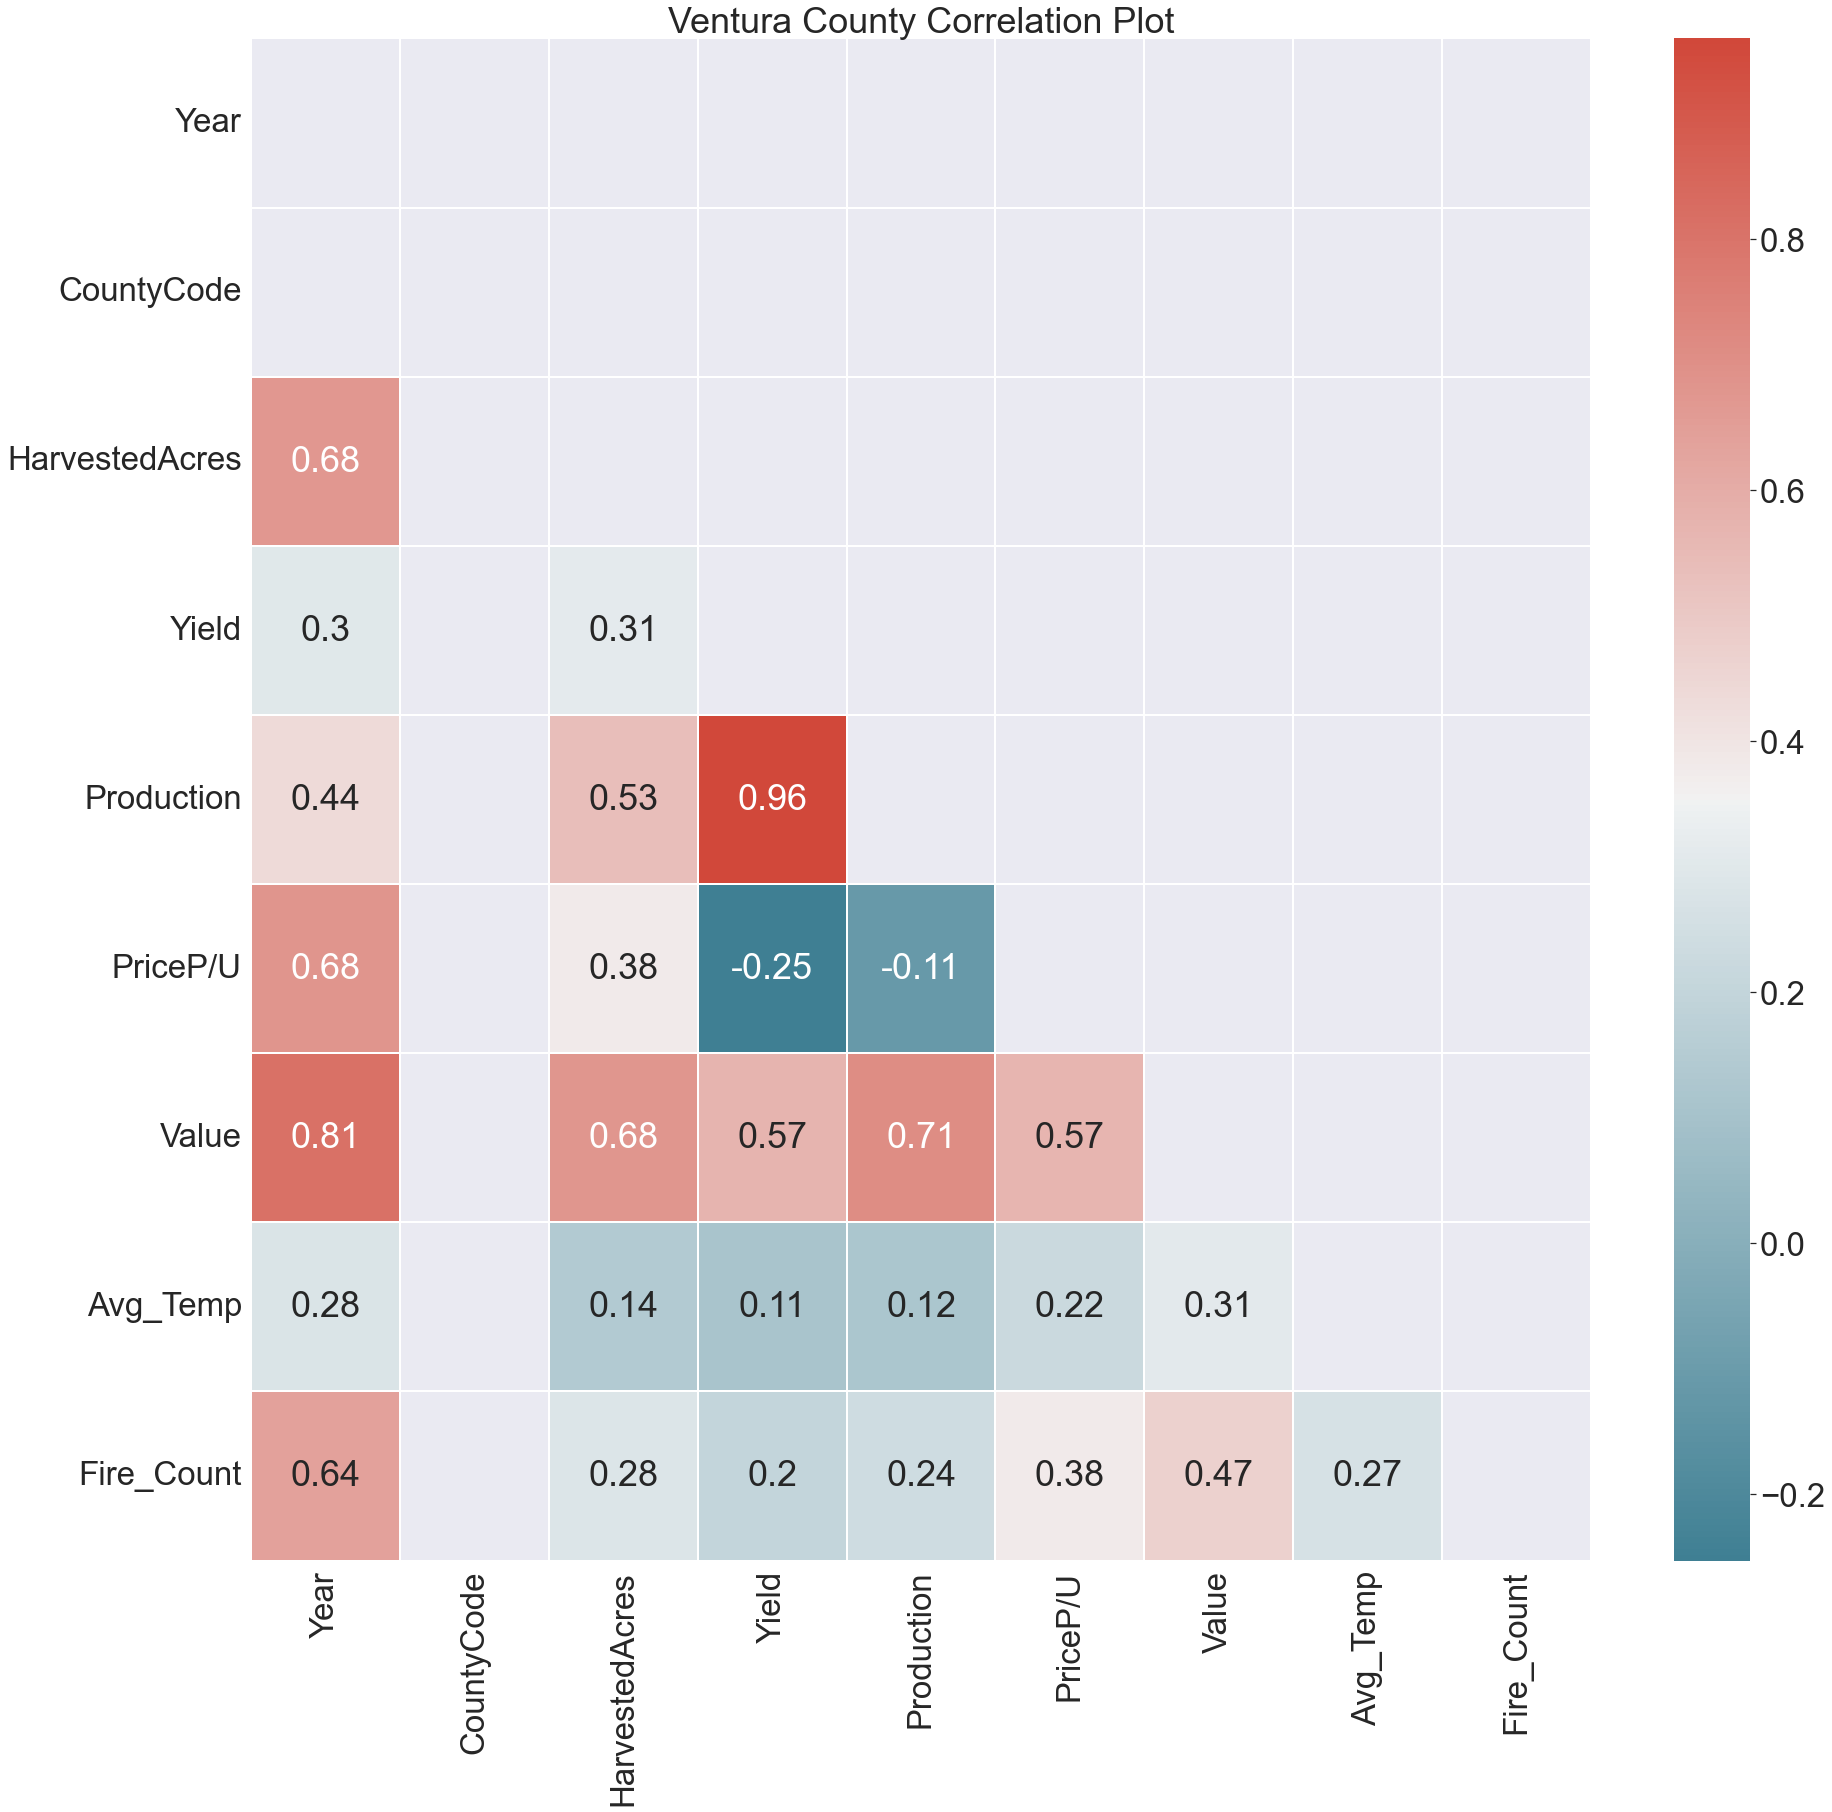

In [50]:
#plotting the heatmap for correlation
cmap = sb.diverging_palette(220, 15,as_cmap=True)
sb.set_style('darkgrid')
sb.set_palette('Set2')
sb.set(font_scale=3)
plt.title('Ventura County Correlation Plot')
plt.gcf().set_size_inches(30, 28)
# Generate a mask for the upper triangle
fcorr=ventura.corr()
mask = np.zeros_like(fcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sb.heatmap(fcorr, annot=True,cmap=cmap,mask=mask,linewidths=.25)

/var/folders/9j/4y0rr5217t16n6j3w89t3yp80000gn/T/ipykernel_2006/1792843231.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(fcorr, dtype=np.bool)


<AxesSubplot:title={'center':'San Bernardino County Correlation Plot'}>

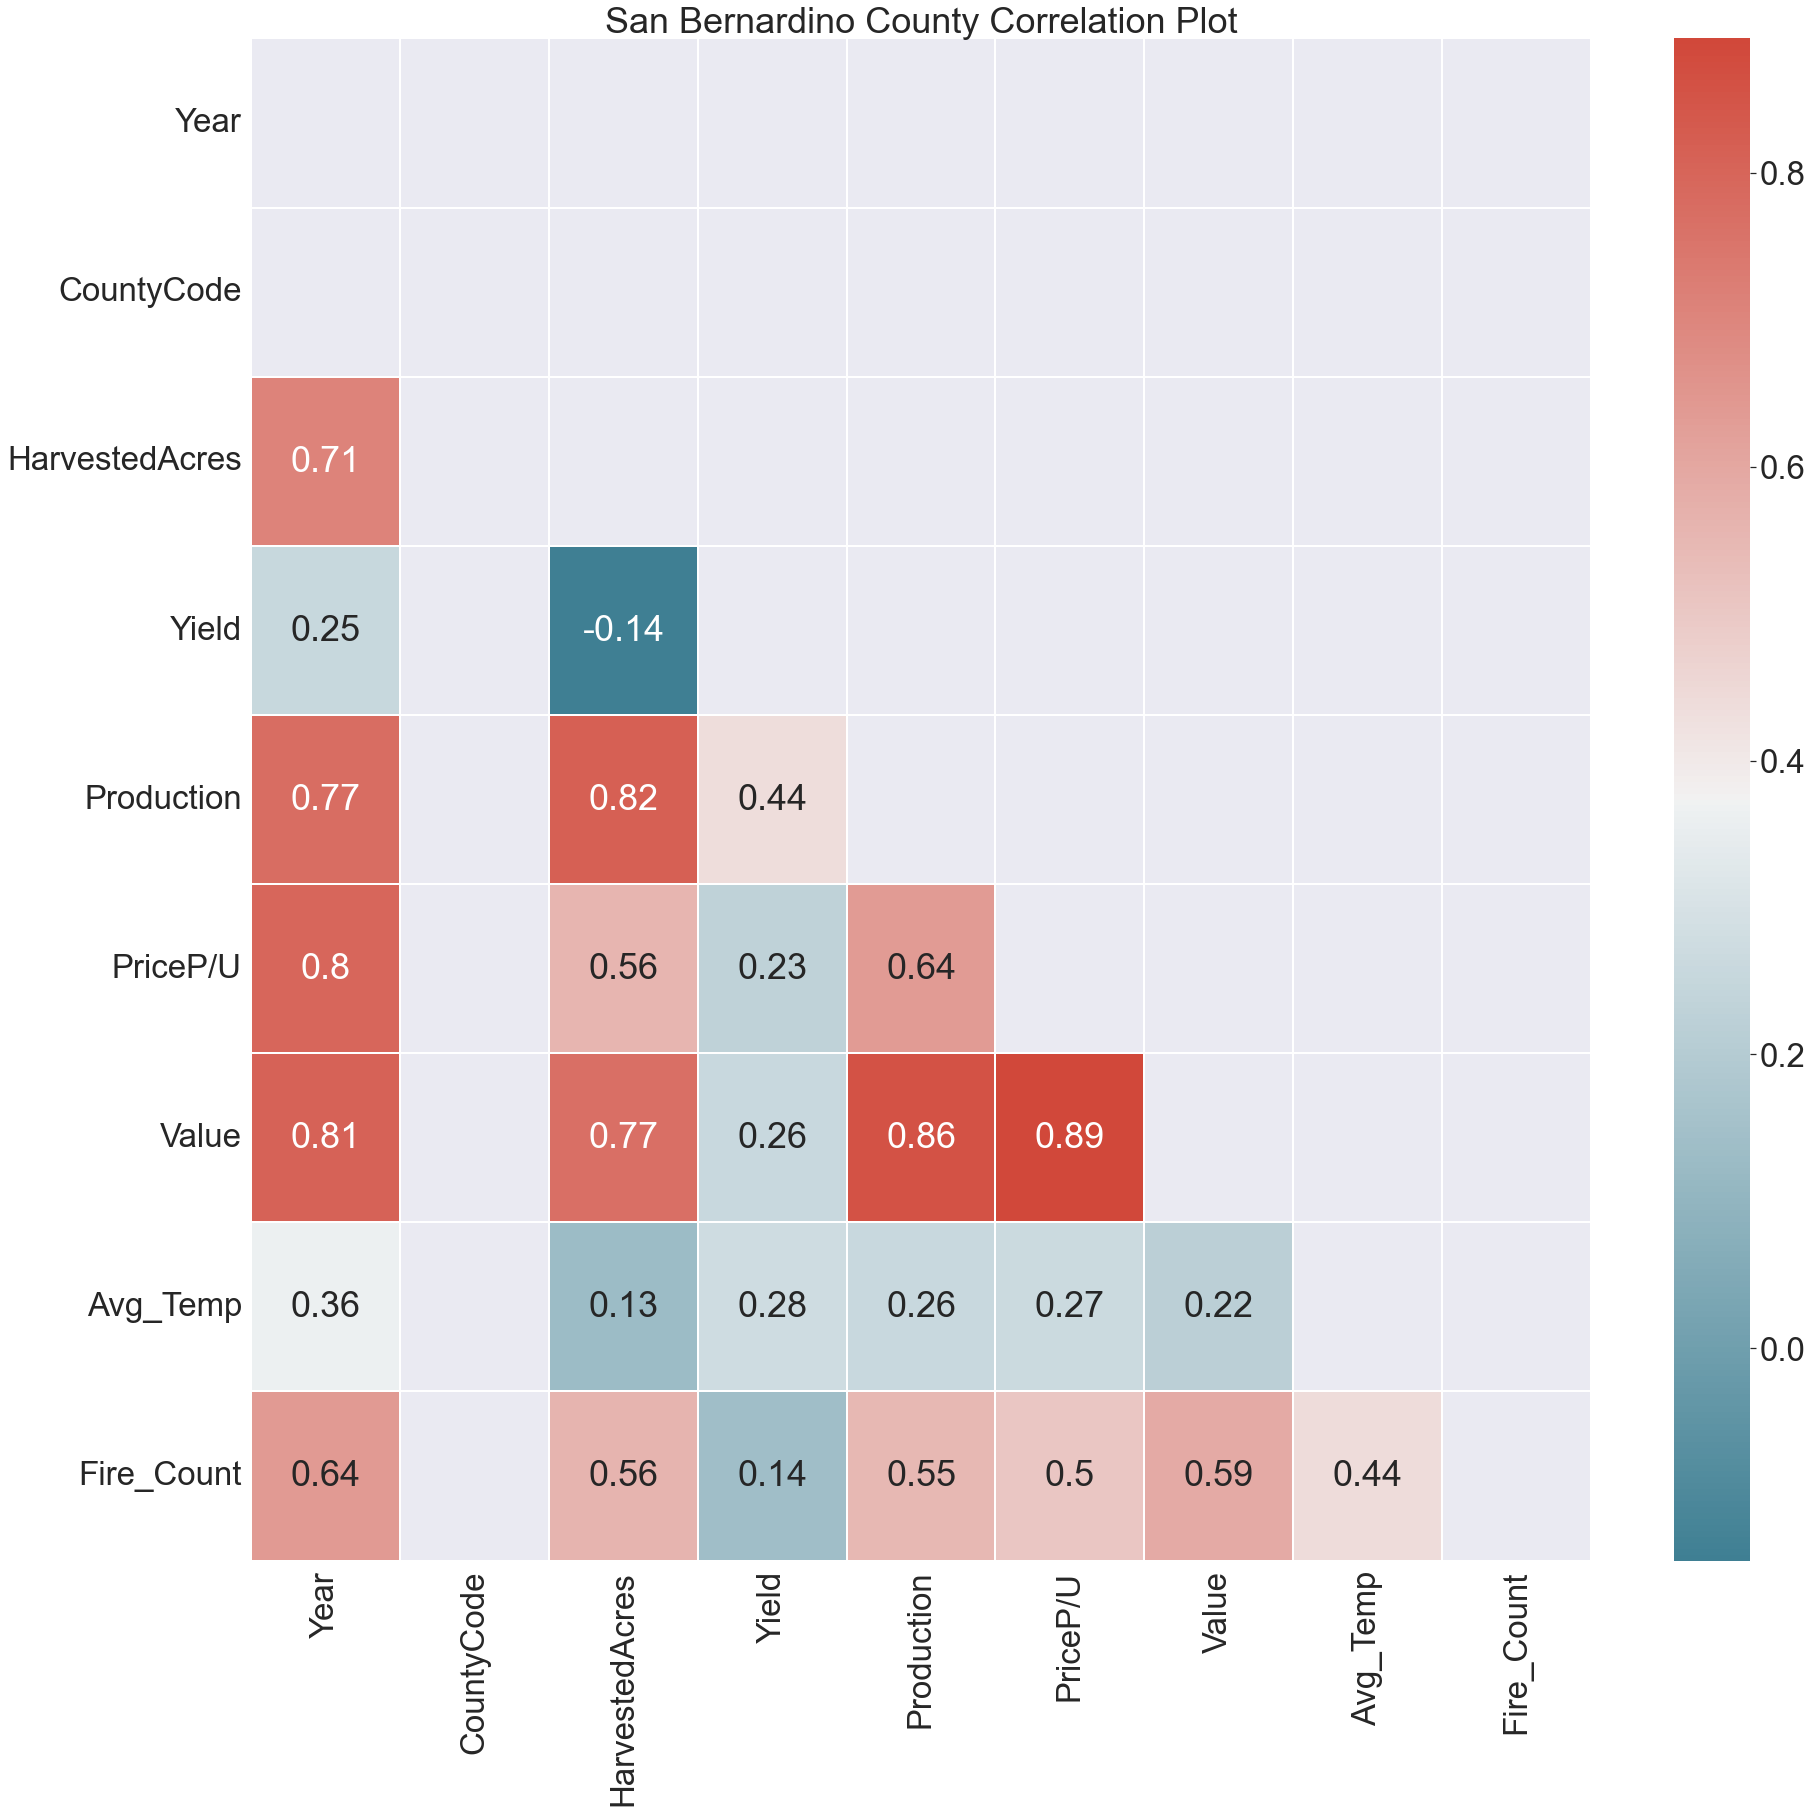

In [51]:
#plotting the heatmap for correlation
cmap = sb.diverging_palette(220, 15,as_cmap=True)
sb.set_style('darkgrid')
sb.set_palette('Set2')
sb.set(font_scale=3)
plt.title('San Bernardino County Correlation Plot')
plt.gcf().set_size_inches(30, 28)
# Generate a mask for the upper triangle
fcorr=SanBern.corr()
mask = np.zeros_like(fcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sb.heatmap(fcorr, annot=True,cmap=cmap,mask=mask,linewidths=.25)

/var/folders/9j/4y0rr5217t16n6j3w89t3yp80000gn/T/ipykernel_2006/902707302.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(fcorr, dtype=np.bool)


<AxesSubplot:title={'center':'Santa Barbara County Correlation Plot'}>

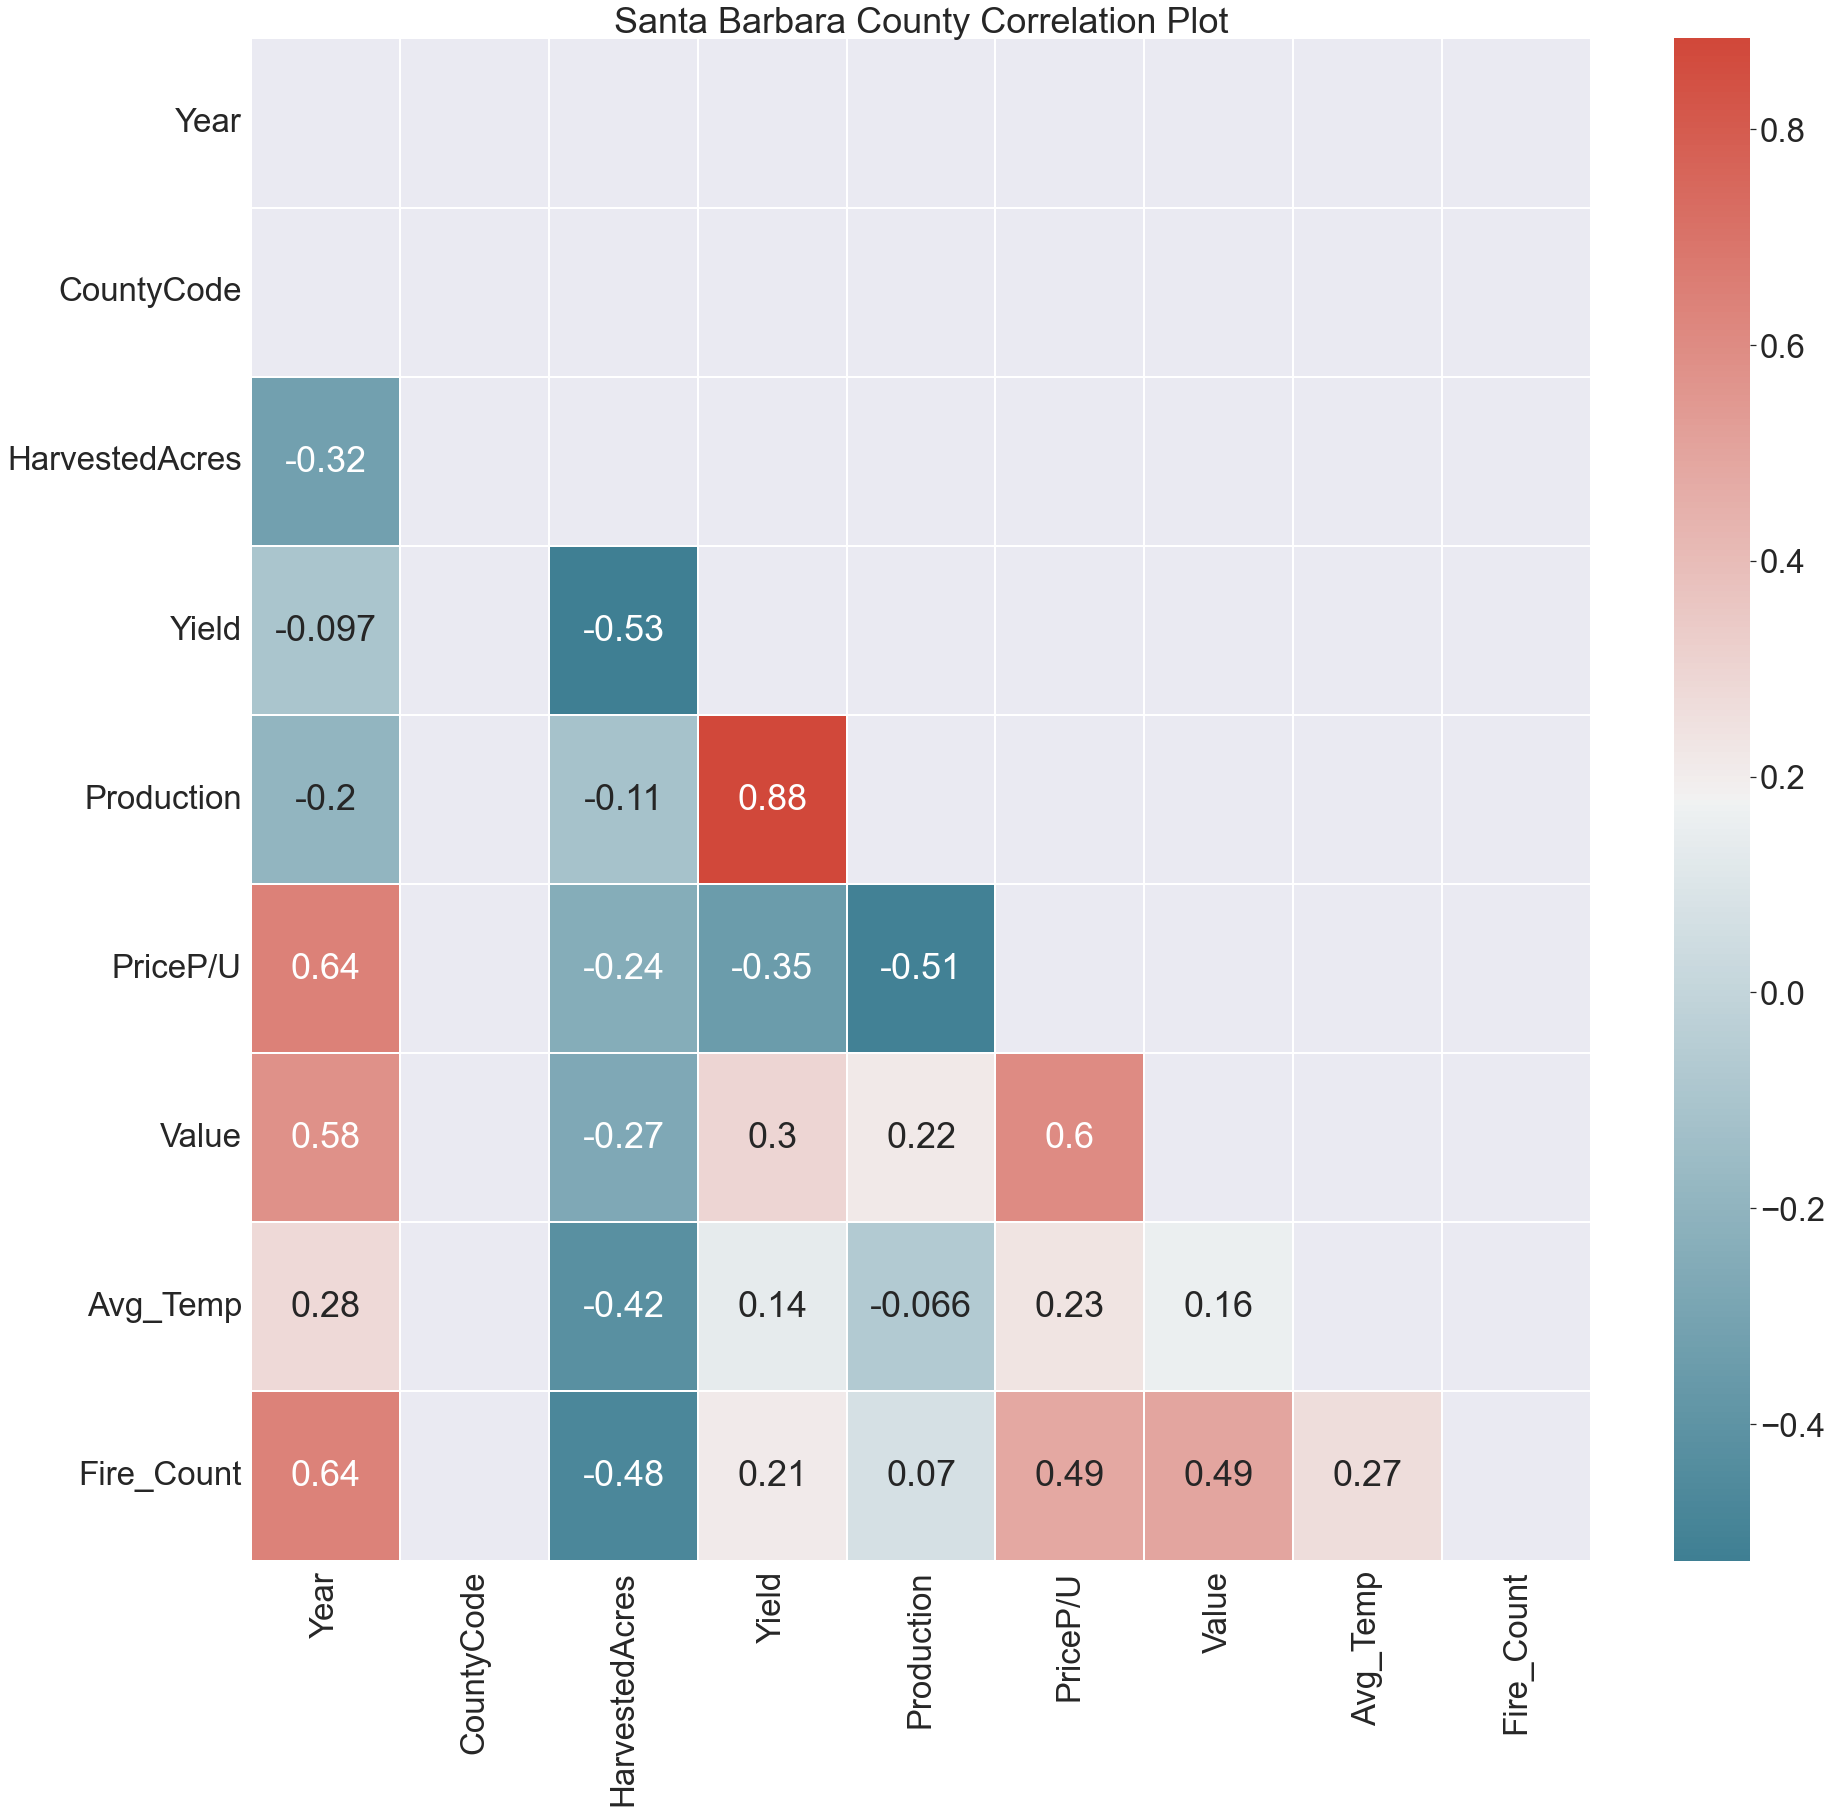

In [52]:
#plotting the heatmap for correlation
cmap = sb.diverging_palette(220, 15,as_cmap=True)
sb.set_style('darkgrid')
sb.set_palette('Set2')
sb.set(font_scale=3)
plt.title('Santa Barbara County Correlation Plot')
plt.gcf().set_size_inches(30, 28)
# Generate a mask for the upper triangle
fcorr=SanBarb.corr()
mask = np.zeros_like(fcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sb.heatmap(fcorr, annot=True,cmap=cmap,mask=mask,linewidths=.25)

/var/folders/9j/4y0rr5217t16n6j3w89t3yp80000gn/T/ipykernel_2006/4145904812.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(fcorr, dtype=np.bool)


<AxesSubplot:title={'center':'San Luis Obispo County Correlation Plot'}>

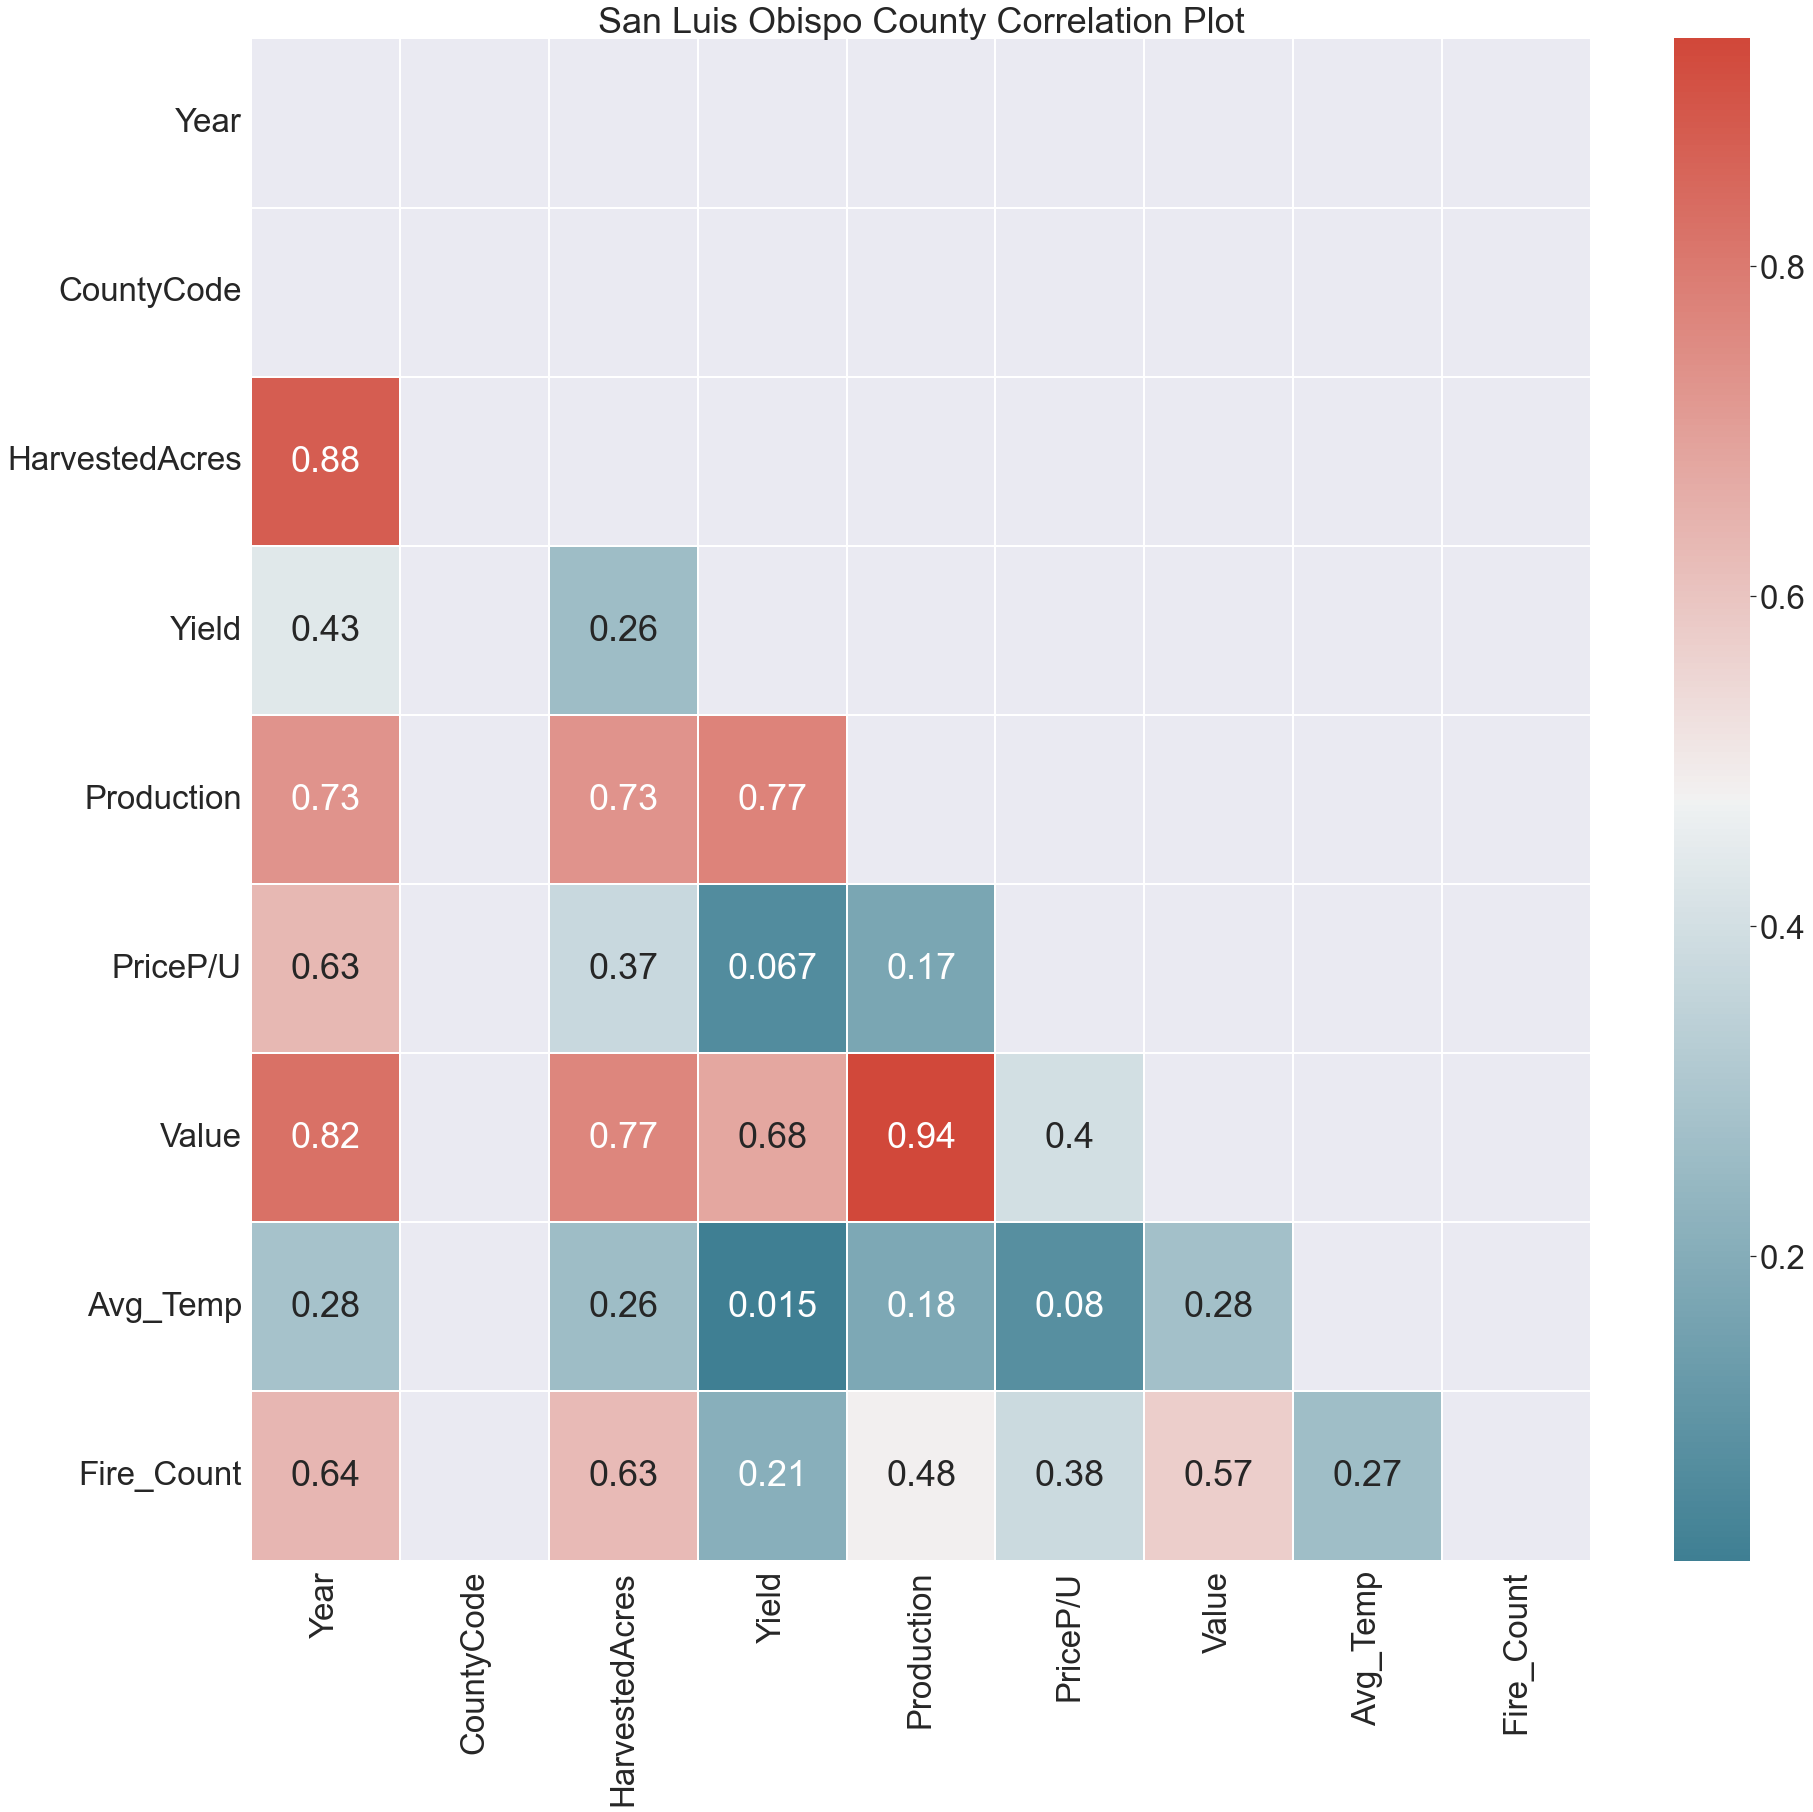

In [53]:
#plotting the heatmap for correlation
cmap = sb.diverging_palette(220, 15,as_cmap=True)
sb.set_style('darkgrid')
sb.set_palette('Set2')
sb.set(font_scale=3)
plt.title('San Luis Obispo County Correlation Plot')
plt.gcf().set_size_inches(30, 28)
# Generate a mask for the upper triangle
fcorr=SanLO.corr()
mask = np.zeros_like(fcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sb.heatmap(fcorr, annot=True,cmap=cmap,mask=mask,linewidths=.25)

/var/folders/9j/4y0rr5217t16n6j3w89t3yp80000gn/T/ipykernel_2006/3583422902.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(fcorr, dtype=np.bool)


<AxesSubplot:title={'center':'San Diego County Correlation Plot'}>

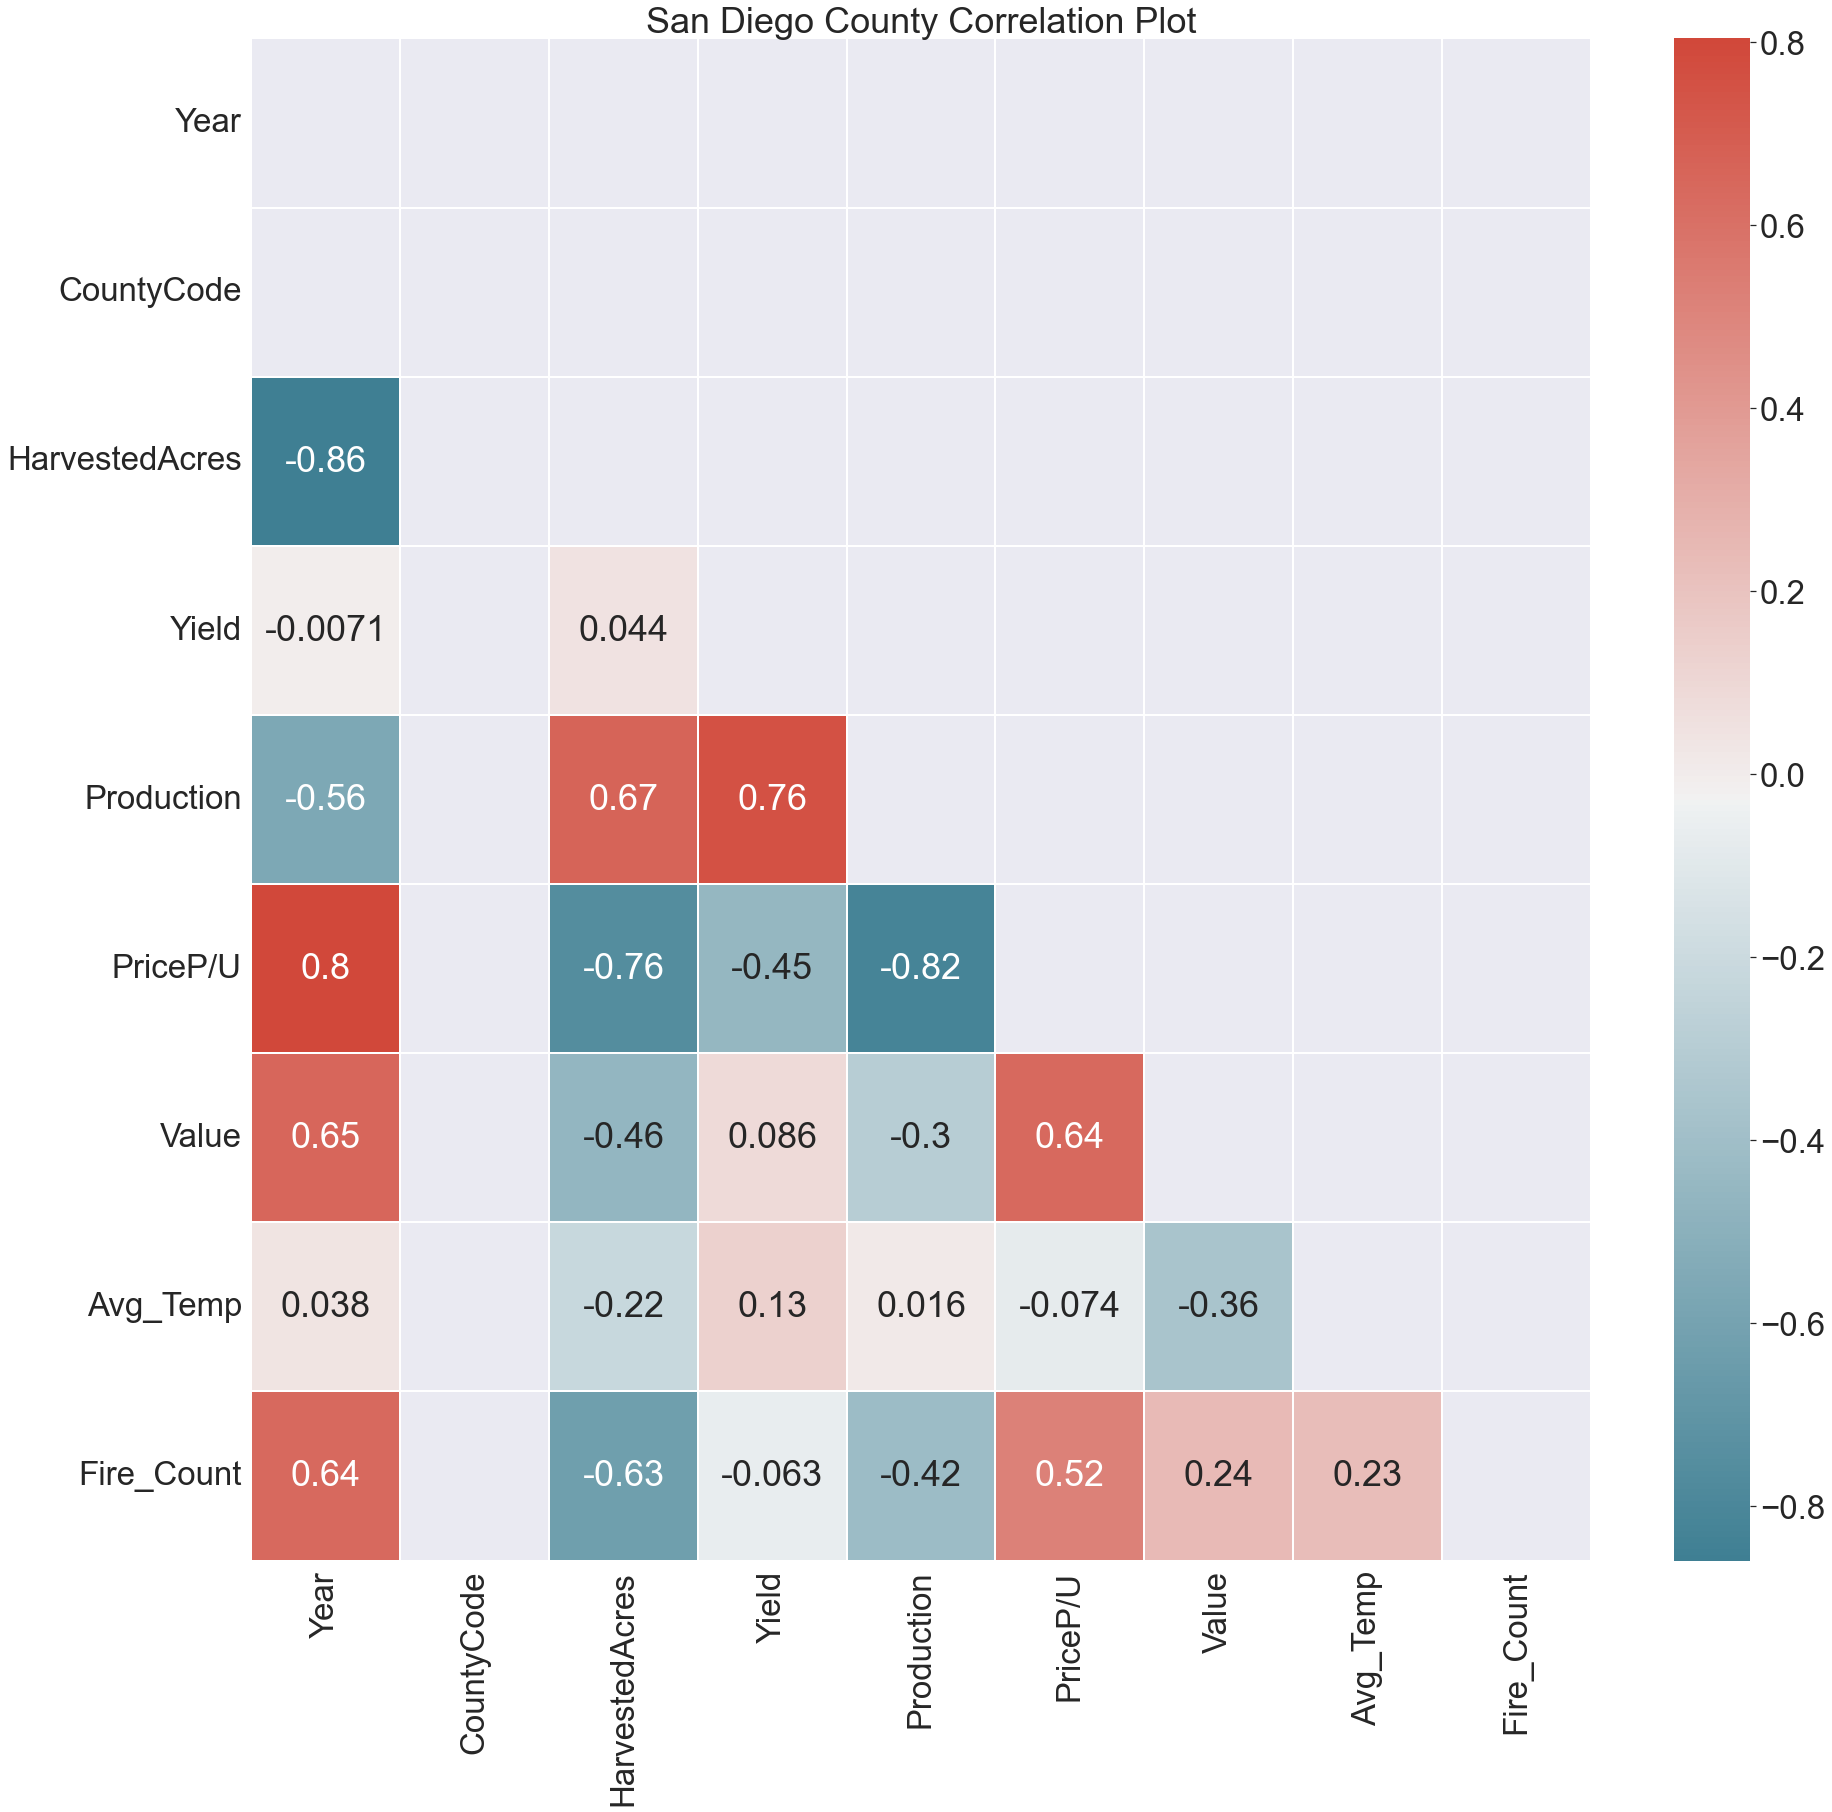

In [54]:
#plotting the heatmap for correlation
cmap = sb.diverging_palette(220, 15,as_cmap=True)
sb.set_style('darkgrid')
sb.set_palette('Set2')
sb.set(font_scale=3)
plt.title('San Diego County Correlation Plot')
plt.gcf().set_size_inches(30, 28)
# Generate a mask for the upper triangle
fcorr=SanDie.corr()
mask = np.zeros_like(fcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sb.heatmap(fcorr, annot=True,cmap=cmap,mask=mask,linewidths=.25)

/var/folders/9j/4y0rr5217t16n6j3w89t3yp80000gn/T/ipykernel_2006/131572020.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(fcorr, dtype=np.bool)


<AxesSubplot:title={'center':'California Correlation Plot'}>

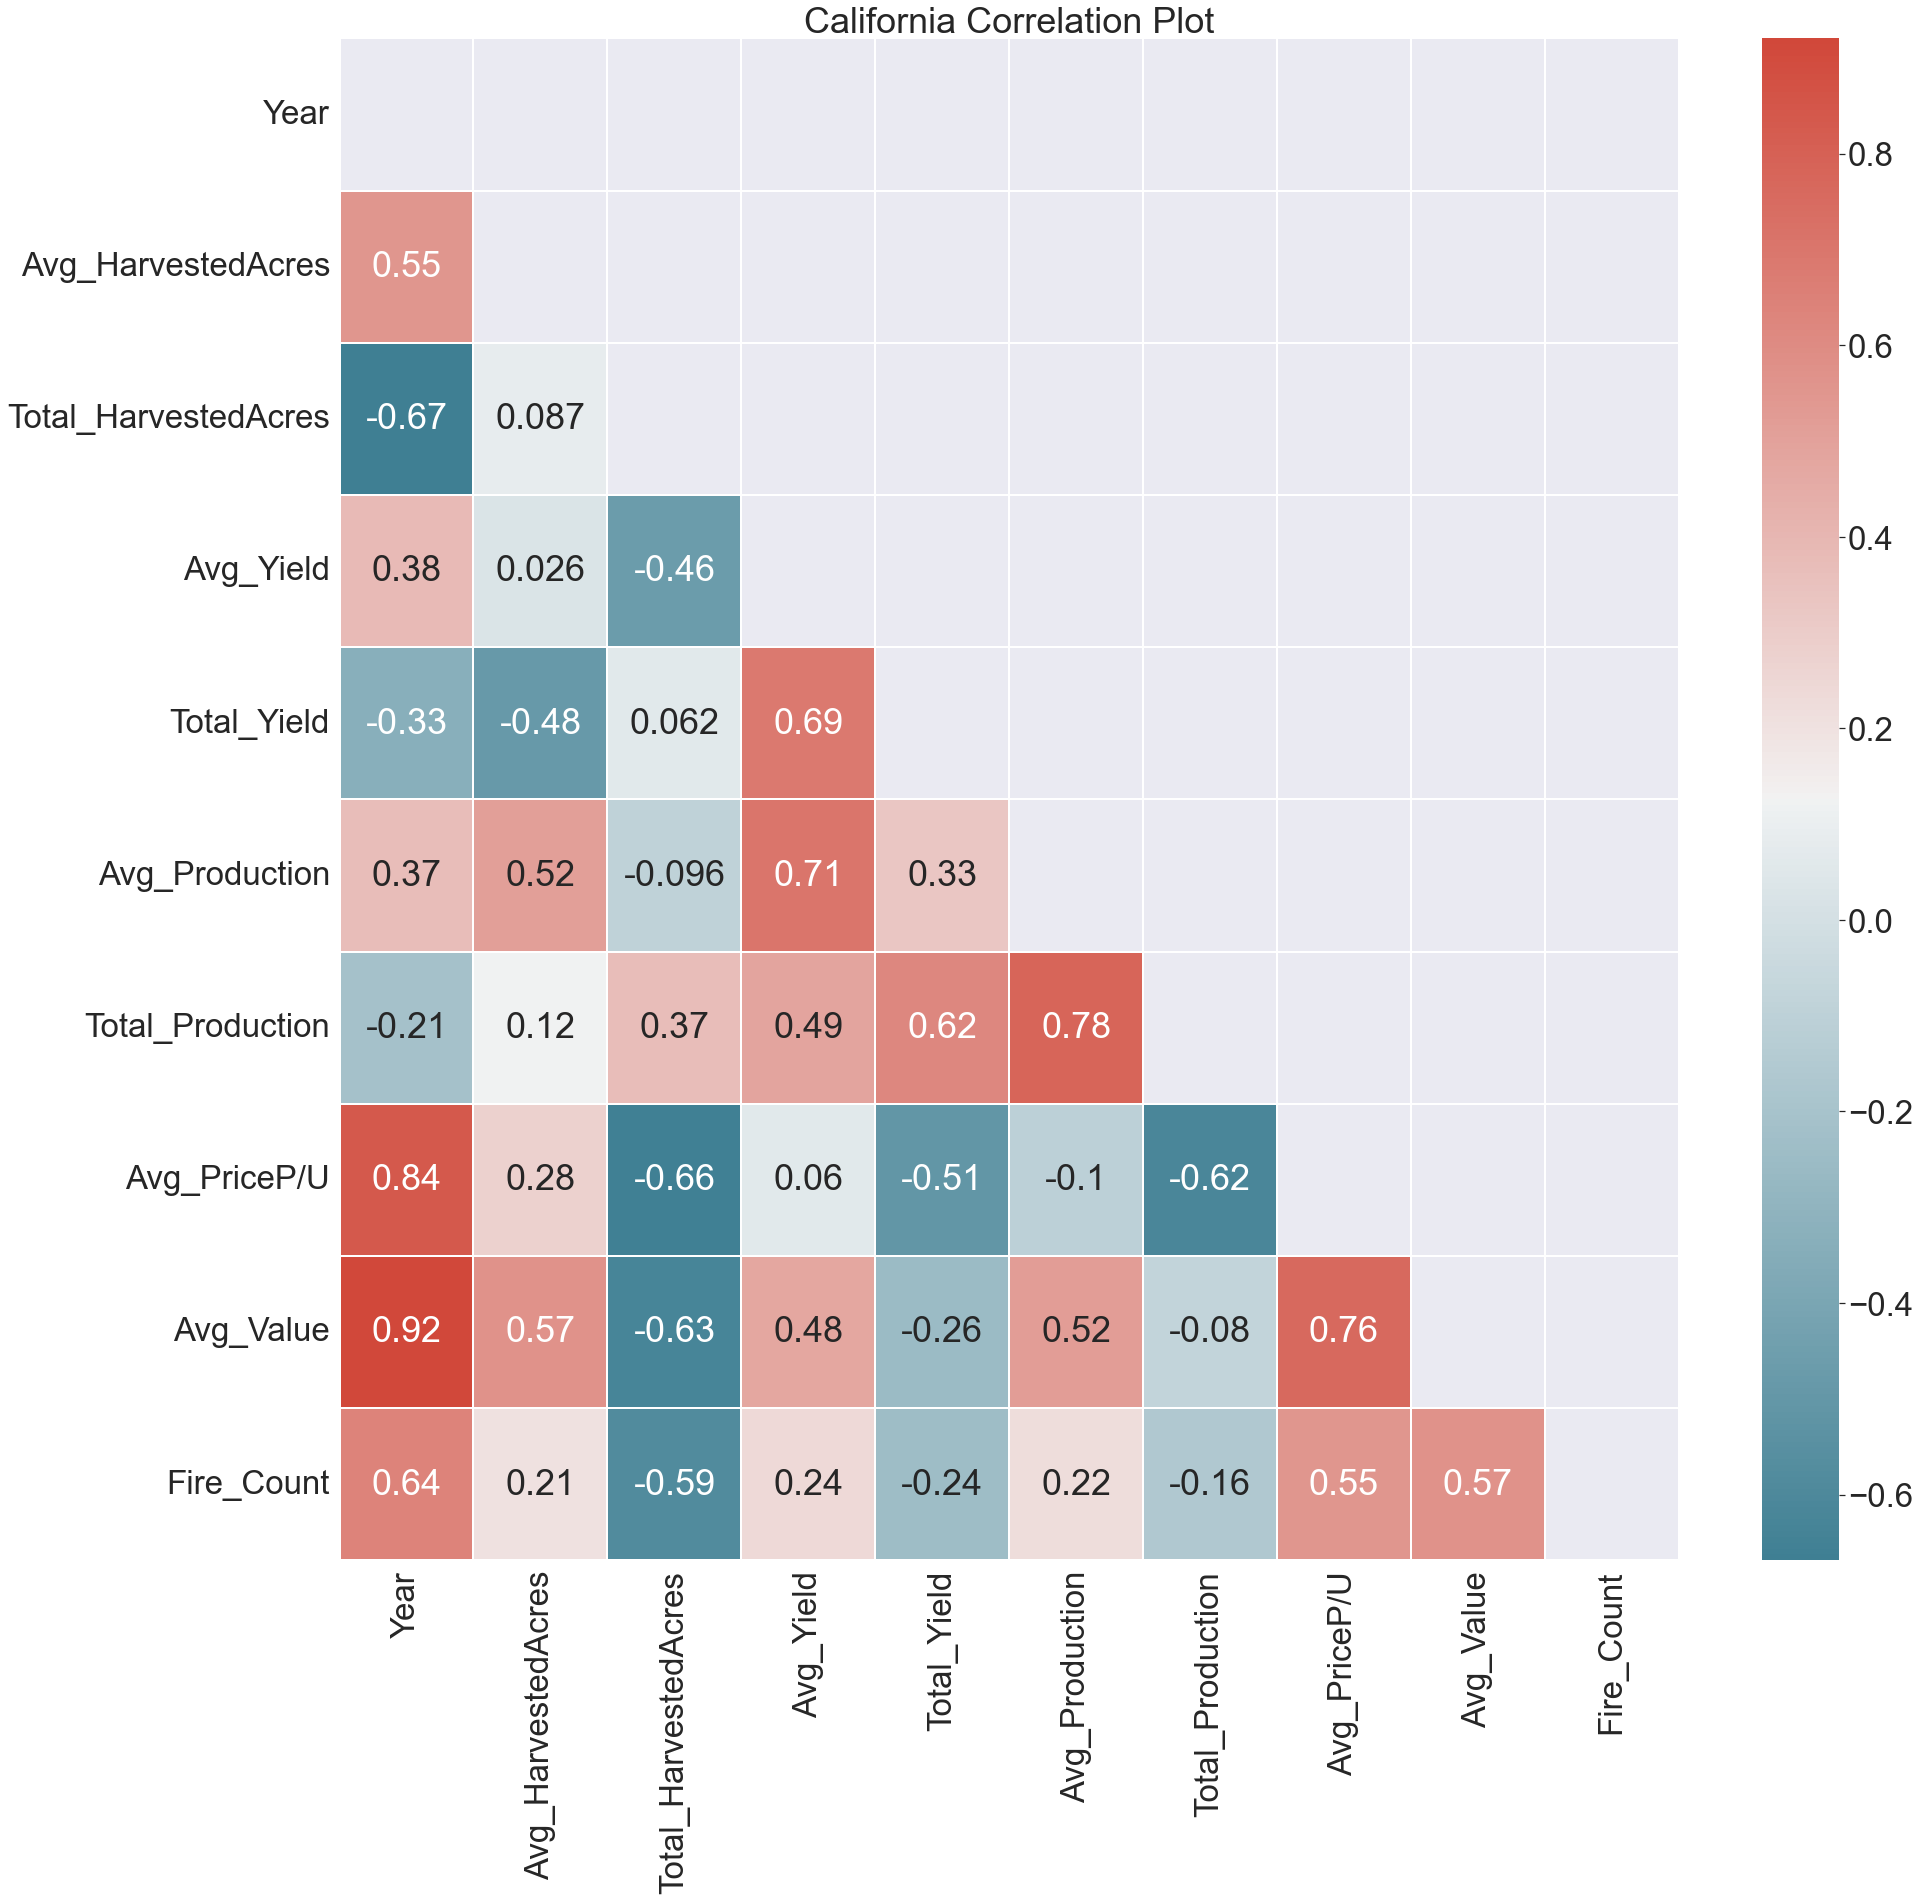

In [55]:
#plotting the heatmap for correlation
cmap = sb.diverging_palette(220, 15,as_cmap=True)
sb.set_style('darkgrid')
sb.set_palette('Set2')
sb.set(font_scale=3)
plt.title('California Correlation Plot')
plt.gcf().set_size_inches(30, 28)
# Generate a mask for the upper triangle
fcorr=adf_grouped.corr()
mask = np.zeros_like(fcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sb.heatmap(fcorr, annot=True,cmap=cmap,mask=mask,linewidths=.25)

### Analyzing US Avocado Prices 

In [56]:
usAvocadoPrices = pd.read_csv('Data/avocado.csv', sep = ',')

In [57]:
usAvocadoPrices.head()

Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   44638.81   
2           2  2015-12-13          0.93     118220.22   794.70  109149.67   
3           3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4           4  2015-11-29          1.28      51039.60   941.48   43838.39   

     4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0   48.16     8696.87     8603.62       93.25          0.0  conventional   
1   58.33     9505.56     9408.07       97.49          0.0  conventional   
2  130.50     8145.35     8042.21      103.14          0.0  conventional   
3   72.58     5811.16     5677.40      133.76          0.0  conventional   
4   75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Albany  
2  2015  Albany  
3  2015  Albany  
4  2015  Albany

In [58]:
usAvocadoPrices.tail()

Unnamed: 0        Date  AveragePrice  Total Volume     4046     4225  \
18244           7  2018-02-04          1.63      17074.83  2046.96  1529.20   
18245           8  2018-01-28          1.71      13888.04  1191.70  3431.50   
18246           9  2018-01-21          1.87      13766.76  1191.92  2452.79   
18247          10  2018-01-14          1.93      16205.22  1527.63  2981.04   
18248          11  2018-01-07          1.62      17489.58  2894.77  2356.13   

         4770  Total Bags  Small Bags  Large Bags  XLarge Bags     type  year  \
18244    0.00    13498.67    13066.82      431.85          0.0  organic  2018   
18245    0.00     9264.84     8940.04      324.80          0.0  organic  2018   
18246  727.94     9394.11     9351.80       42.31          0.0  organic  2018   
18247  727.01    10969.54    10919.54       50.00          0.0  organic  2018   
18248  224.53    12014.15    11988.14       26.01          0.0  organic  2018   

                 region  
18244  WestTexNewMexico  
18245  WestTexNewMexico  
18246  WestTexNewMexico  
18247  WestTexNewMexico  
18248  WestTexNewMexico

In [59]:
#drop irrelevant column
usAvocadoPrices.drop(columns = 'Unnamed: 0', inplace = True)
usAvocadoPrices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.8+ MB


In [60]:
#check year range
usAvocadoPrices['year'].unique()

array([2015, 2016, 2017, 2018])

In [61]:
#check region names and make updates
regions = usAvocadoPrices['region'].unique().tolist()
print(regions)

regionStates = ['New York', 'Georgia', 'Maryland', 'Idaho', 'Massachusetts', 'New York', 'California', 'North Carolina',
               'Illinois', 'Ohio', 'Ohio', 'Texas', 'Colorado', 'Michigan', 'Michigan', 'Michigan', 'Pennsylvania', 
                'Connecticut', 'Texas', 'Indiana', 'Florida', 'Nevada', 'California', 'Kentucky', 'Florida', 'Tennessee',
               'Tennessee', 'Louisiana', 'New York', 'Pennsylvania', 'Massachussetts', 'Florida', 'Pennsylvania', 'Arizona',
                'Pennsylvania','Kansas','Oregon', 'North Carolina', 'Virginia', 'Virginia', 'California', 'California', 'California', 
                'Washington','South Carolina', 'Los Angeles', 'Florida', 'Washington', 'Missouri', 'New York', 'Florida', 
                'NA','California', 'New Mexico']

cityStates = pd.DataFrame(data = regions, columns = ['region'])
cityStates.insert(1, 'State',regionStates)

['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', 'BuffaloRochester', 'California', 'Charlotte', 'Chicago', 'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver', 'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton', 'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville', 'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale', 'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork', 'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia', 'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland', 'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento', 'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina', 'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse', 'Tampa', 'TotalUS', 'West', 'WestTexNewMexico']


In [62]:
#Get gps data to create map visualizaton
gpsData = pd.read_csv('Data/gpsData.csv', sep = ',')
gpsData.head()

State State_Code   Latitude   Longitude
0     Alabama         AL  32.806671  -86.791130
1      Alaska         AK  61.370716 -152.404419
2     Arizona         AZ  33.729759 -111.431221
3    Arkansas         AR  34.969704  -92.373123
4  California         CA  36.116203 -119.681564

In [63]:
coordinates = cityStates.merge(gpsData, how = 'left', on = 'State')
coordinates.head()

region          State State_Code   Latitude   Longitude
0               Albany       New York         NY  42.165726  -74.948051
1              Atlanta        Georgia         GA  33.040619  -83.643074
2  BaltimoreWashington       Maryland         MD  39.063946  -76.802101
3                Boise          Idaho         ID  44.240459 -114.478828
4               Boston  Massachusetts         MA  42.230171  -71.530106

In [64]:
#create a new df
usAvocadoPrices = usAvocadoPrices.merge(coordinates, how = 'left', on = 'region')

states = usAvocadoPrices['State'].unique().tolist()

stateAvgPrices = pd.DataFrame()
stateAvgPrices['year'] = []
stateAvgPrices['State'] = []
stateAvgPrices['State_Code'] = []
stateAvgPrices['AveragePrice'] = []
stateAvgPrices['Latitude'] = []
stateAvgPrices['Longitude'] = []

In [65]:
for state in states:
    row = usAvocadoPrices[usAvocadoPrices['State'] == state]
    stateAvgPrice = row.groupby(['State', 'State_Code', 'year']).mean()
    stateAvgPrice.drop(columns = ['Total Volume', '4046', '4225', '4770', 'Total Bags',
                                  'Small Bags', 'Large Bags', 'XLarge Bags'], inplace = True)
    stateAvgPrice.reset_index(inplace = True)
    stateAvgPrices = pd.concat([stateAvgPrices, stateAvgPrice])
    
stateAvgPrices.head()

year     State State_Code  AveragePrice   Latitude  Longitude
0  2015.0  New York         NY      1.564231  42.165726 -74.948051
1  2016.0  New York         NY      1.570817  42.165726 -74.948051
2  2017.0  New York         NY      1.656226  42.165726 -74.948051
3  2018.0  New York         NY      1.371771  42.165726 -74.948051
0  2015.0   Georgia         GA      1.380577  33.040619 -83.643074

In [66]:
stateAvgPrices = stateAvgPrices[stateAvgPrices['State'] != 'NA']

In [67]:
fig = px.choropleth(stateAvgPrices, locations = 'State_Code',
                   locationmode = 'USA-states', scope = 'usa',
                   color = 'AveragePrice', color_continuous_scale ='greens')
fig.update_layout(
    title_text = 'Avocado State Average Prices for 2015-2018',
    geo_scope='usa', # limit map scope to USA
)
fig.show()


States with Low Avocado Average Prices

In [68]:
stateAvgPrices.sort_values(by = ['AveragePrice']).head(10)

year     State State_Code  AveragePrice   Latitude   Longitude
1  2016.0     Texas         TX      0.994038  31.054487  -97.563461
0  2015.0     Texas         TX      1.062981  31.054487  -97.563461
3  2018.0     Texas         TX      1.072500  31.054487  -97.563461
1  2016.0  Colorado         CO      1.093173  39.059811 -105.311104
1  2016.0      Ohio         OH      1.137356  40.388783  -82.764915
2  2017.0     Texas         TX      1.140519  31.054487  -97.563461
1  2016.0     Idaho         ID      1.141923  44.240459 -114.478828
3  2018.0   Arizona         AZ      1.155000  33.729759 -111.431221
0  2015.0   Arizona         AZ      1.157115  33.729759 -111.431221
3  2018.0   Indiana         IN      1.168333  39.849426  -86.258278

States with High Avocado Prices

In [69]:
stateAvgPrices.sort_values(by = ['AveragePrice'], ascending = False).head(10)

year           State State_Code  AveragePrice   Latitude  Longitude
2  2017.0     Connecticut         CT      1.888302  41.597782 -72.755371
1  2016.0     Connecticut         CT      1.851058  41.597782 -72.755371
2  2017.0  North Carolina         NC      1.769245  35.630066 -79.806419
0  2015.0     Connecticut         CT      1.747788  41.597782 -72.755371
2  2017.0        Illinois         IL      1.714811  40.349457 -88.986137
2  2017.0   Massachusetts         MA      1.679528  42.230171 -71.530106
2  2017.0        Maryland         MD      1.679434  39.063946 -76.802101
3  2018.0     Connecticut         CT      1.677500  41.597782 -72.755371
2  2017.0        New York         NY      1.656226  42.165726 -74.948051
2  2017.0         Florida         FL      1.624151  27.766279 -81.686783

# Analysis

## Time Series Analysis Using ARIMA
### Analyzing California Avocado Prices and Productions

#### Forecasting Average Avocado Prices in California

In [70]:
#get a copy of the average price per unit data to make predictions
grouped_df_model1 = grouped_df[['Average_PriceP/U']]

In [71]:
#convert price per ton to price per pound
grouped_df_model1['AvgPricePerPound'] = grouped_df_model1['Average_PriceP/U'] / 2000
grouped_df_model1

/var/folders/9j/4y0rr5217t16n6j3w89t3yp80000gn/T/ipykernel_2006/649706982.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Average_PriceP/U  AvgPricePerPound
Year                                    
1980       1304.454545          0.652227
1981        469.818182          0.234909
1982        724.500000          0.362250
1983        545.583333          0.272792
1984        450.833333          0.225417
1985        788.545455          0.394273
1986        954.727273          0.477364
1987        544.272727          0.272136
1988       1306.454545          0.653227
1989       1339.727273          0.669864
1990       1967.727273          0.983864
1991       1528.125000          0.764062
1992       1079.666667          0.539833
1993        757.500000          0.378750
1994       1589.800000          0.794900
1995       1377.400000          0.688700
1996       1472.000000          0.736000
1997       1689.000000          0.844500
1998       1841.500000          0.920750
1999       2058.500000          1.029250
2000       1962.900000          0.981450
2001       1813.900000          0.906950
2002       1922.700000          0.961350
2003       2210.128000          1.105064
2004       1736.645000          0.868322
2005       1839.714000          0.919857
2006       1164.803333          0.582402
2007       1867.721111          0.933861
2008       1872.877778          0.936439
2009       2137.445556          1.068723
2010       1527.276667          0.763638
2011       2593.525556          1.296763
2012       1689.737500          0.844869
2013       1866.396250          0.933198
2014       2189.772500          1.094886
2015       2385.227500          1.192614
2016       2110.448750          1.055224
2017       2929.408750          1.464704
2018       2337.045000          1.168523
2019       2916.120000          1.458060
2020       2551.941667          1.275971

/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



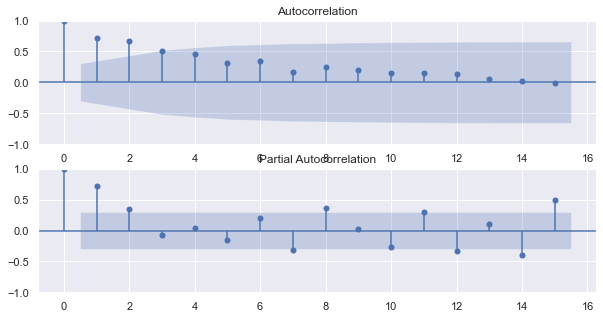

In [72]:
#create ACF and PACF plots to review the data
sb.set(font_scale=1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(grouped_df_model1['AvgPricePerPound'], lags=15, ax=ax1)
ax2 = plot_pacf(grouped_df_model1['AvgPricePerPound'], lags=15, ax=ax2)
plt.show()

In [73]:
# Check stationarity
result = adfuller(grouped_df_model1['AvgPricePerPound'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.152035
p-value: 0.693881
Critical Test Statistics Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


In [74]:
# Differencing
time_series_diff = grouped_df_model1['AvgPricePerPound'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.739859
p-value: 0.003586
Critical Test Statistics Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



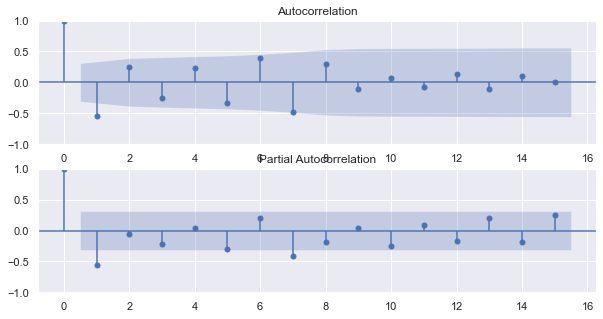

In [75]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [76]:
#Referenced code from MILLER (2015) 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load data
series = grouped_df_model1['AvgPricePerPound']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

# predict 2021 and 2022 values and attach results to end of predictions variable
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)


>Predicted=1.172, Expected=  1
>Predicted=1.149, Expected=  1
>Predicted=1.282, Expected=  1
>Predicted=1.365, Expected=  1
>Predicted=1.328, Expected=  1
RMSE: 0.166


In [77]:
#create a DF that includes both original and predicted results
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_CA1 = pd.DataFrame()
predictionDf_CA1['Year'] = list(range(1980, 2023))
predictionDf_CA1 = predictionDf_CA1.set_index('Year')
predictionDf_CA1['ForecastResult'] = ForecastResult
predictionDf_CA1['PricePerPound'] = list(X) + [None]*2

#check results
print(predictionDf_CA1.tail())

      ForecastResult  PricePerPound
Year                               
2018        1.281520       1.168522
2019        1.364771       1.458060
2020        1.328127       1.275971
2021        1.414768            NaN
2022        1.368488            NaN


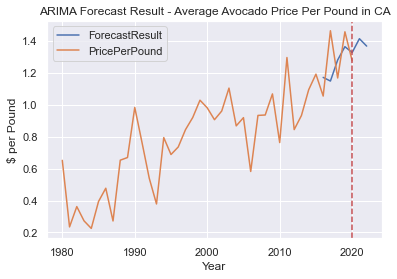

In [78]:
#plot data
predictionDf_CA1.plot()
plt.title('ARIMA Forecast Result - Average Avocado Price Per Pound in CA')
plt.axvline(x=2020, ls = '--', c='r')
plt.ylabel('$ per Pound')
plt.savefig('Forecast_CA_Price.png')

#### Forecasting Average Avocado Prices in California

In [79]:
#get a copy of the average price per unit data to make predictions
grouped_df_model2 = grouped_df[['Total_Production']]
grouped_df_model2

Total_Production
Year                  
1980           94992.0
1981          217254.0
1982          224058.0
1983          256303.0
1984          288289.0
1985          231040.0
1986          210412.0
1987          283313.0
1988          208111.0
1989          163836.0
1990          117782.0
1991          138245.0
1992          148603.0
1993          282004.0
1994          147134.0
1995          171143.0
1996          163008.0
1997          148992.0
1998          145104.0
1999          122759.0
2000          131500.0
2001          174310.0
2002          190572.0
2003          175899.0
2004          217126.0
2005          190340.0
2006          299052.0
2007          140496.0
2008          141012.0
2009          108182.0
2010          248171.0
2011          156687.0
2012          231529.0
2013          295066.0
2014          169279.0
2015          147632.0
2016          189231.0
2017          131346.0
2018          163192.0
2019          127080.0
2020          176039.0

/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



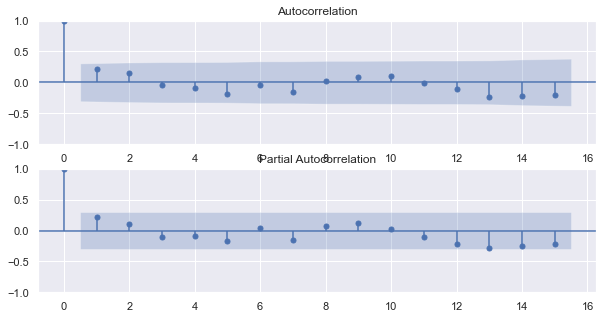

In [80]:
#create ACF and PACF plots
sb.set(font_scale=1)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(grouped_df_model2, lags=15, ax=ax1)
ax2 = plot_pacf(grouped_df_model2, lags=15, ax=ax2)
plt.show()

In [81]:
# Check stationarity: results suggest data is stationary 
result = adfuller(grouped_df_model2,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.116521
p-value: 0.000013
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


RMSE: 33510.202


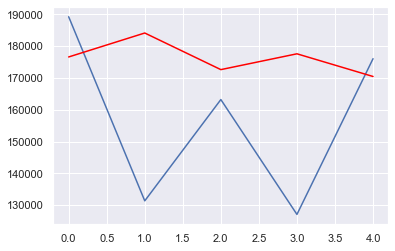

In [82]:
# load data
series = grouped_df_model2
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]

#make predictions
model = ARIMA(grouped_df_model2.values,order=(1,0,1))
model_fit=model.fit()
predictions = model_fit.predict(start = 36, end= 42, dynamic= False)

# report performance
predictions_for_eval = predictions[:-2]
mse = mean_squared_error(test, predictions_for_eval)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions_for_eval, color='red')
plt.show()


In [83]:
#make predictions 
model = ARIMA(grouped_df_model2.values,order=(1,0,1))
model_fit=model.fit()
predictions = model_fit.predict(start = 36, end= 42, dynamic= False)
print(predictions)

[176586.29501278 184116.99870408 172605.95368288 177578.72755667
 170448.18184732 180043.69771105 182707.60528835]


In [84]:
ForecastResult = [None]*(len(grouped_df_model2.values)-5)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_CA2 = pd.DataFrame()
predictionDf_CA2['Year'] = list(range(1980, 2023))
predictionDf_CA2 = predictionDf_CA2.set_index('Year')
predictionDf_CA2['ForecastResult'] = ForecastResult
predictionDf_CA2['Production'] = list(grouped_df_model2['Total_Production']) + [None]*2

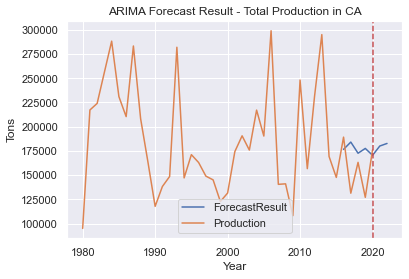

In [85]:
predictionDf_CA2.plot()
plt.title('ARIMA Forecast Result - Total Production in CA')
plt.axvline(x=2020, ls = '--', c='r')
plt.ylabel('Tons')
plt.savefig('Forecast_CA_Production.png')

### ARIMA: Forecasting Avocado Production in California by County

In [86]:
#prepare data for time series analysis graph
model_data1 = adf[['Year','County','Production','PriceP/U']]
model_data1 = model_data1.sort_values('Year')

In [87]:
#Create time series plot for counties that have productions every year
model_data1_TS = model_data1[model_data1['County'] == 'San Bernardino'][['Year']]
model_data1_TS['San Bernardino'] = model_data1[model_data1['County'] == 'San Bernardino'][['Production']]
model_data1_TS = model_data1_TS.reset_index(drop=True)
model_data1_TS['San Diego'] = model_data1[model_data1['County'] == 'San Diego'][['Production']].reset_index(drop=True)
model_data1_TS['San Luis Obispo'] = model_data1[model_data1['County'] == 'San Luis Obispo'][['Production']].reset_index(drop=True)
model_data1_TS['Santa Barbara'] = model_data1[model_data1['County'] == 'Santa Barbara'][['Production']].reset_index(drop=True)
model_data1_TS['Ventura'] = model_data1[model_data1['County'] == 'Ventura'][['Production']].reset_index(drop=True)

#set Year column as index
model_data1_TS = model_data1_TS.set_index('Year')
print(model_data1_TS)

      San Bernardino  San Diego  San Luis Obispo  Santa Barbara   Ventura
Year                                                                     
1980           487.0    49640.0            398.0        27050.0    8440.0
1981           420.0    81150.0            933.0        48418.0   52151.0
1982           320.0   131554.0           1197.0        35325.0   17847.0
1983           516.0   141450.0           1036.0        27670.0   39778.0
1984           510.0   160574.0           1812.0        27521.0   52070.0
1985           405.0   130795.0           3808.0        20906.0   35079.0
1986           510.0   132480.0           3471.0        13159.0   35855.0
1987           300.0   138168.0           2210.0        54786.0   38564.0
1988           338.0    91025.0           2346.0        27338.0   47257.0
1989           322.0    80942.0           4646.0        20739.0   36180.0
1990           840.0    54200.0           1671.0        17586.0   21084.0
1991            29.0    76254.0       

<Figure size 720x1080 with 0 Axes>

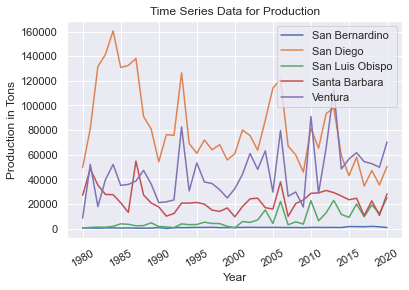

In [88]:
# Line plots of time series
sb.set(font_scale=1)
plt.gcf().set_size_inches(10, 15)

model_data1_TS.plot()
plt.title('Time Series Data for Production')
plt.ylabel('Production in Tons')
plt.xticks(rotation = 30)
plt.show()

#### Build Model for Each County

In [89]:
#### San Bernadino County

In [90]:
sb_df = model_data1[model_data1['County'] == 'San Bernardino']
sb_df1 = sb_df[['Year','Production']]
print(sb_df1)

     Year  Production
314  1980       487.0
312  1981       420.0
310  1982       320.0
308  1983       516.0
306  1984       510.0
304  1985       405.0
302  1986       510.0
300  1987       300.0
298  1988       338.0
296  1989       322.0
294  1990       840.0
292  1991        29.0
290  1992       726.0
288  1993       742.0
286  1994       798.0
284  1995       909.0
282  1996       899.0
280  1997      1020.0
278  1998       765.0
276  1999       771.0
274  2000       860.0
272  2001       904.0
270  2002       990.0
268  2003       917.0
266  2004       895.0
264  2005       966.0
262  2006       860.0
260  2007       820.0
258  2008       817.0
256  2009       720.0
254  2010       915.0
252  2011       912.0
250  2012       840.0
248  2013       917.0
246  2014       822.0
244  2015      1620.0
242  2016      1560.0
240  2017      1470.0
238  2018      1760.0
236  2019      1400.0
234  2020       799.0


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



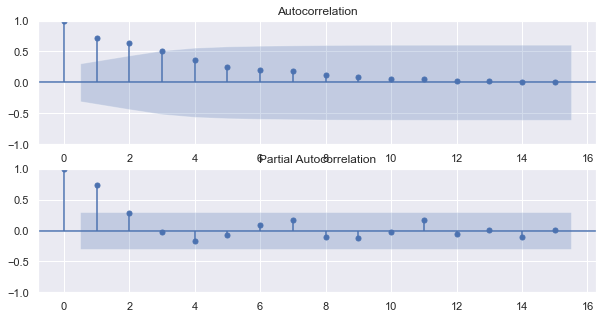

In [91]:
#create ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sb_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(sb_df1['Production'], lags=15, ax=ax2)
plt.show()

In [92]:
# Check stationary
result = adfuller(sb_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.765086
p-value: 0.397928
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


In [93]:
# Differencing
time_series_diff = sb_df1['Production'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.000762
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



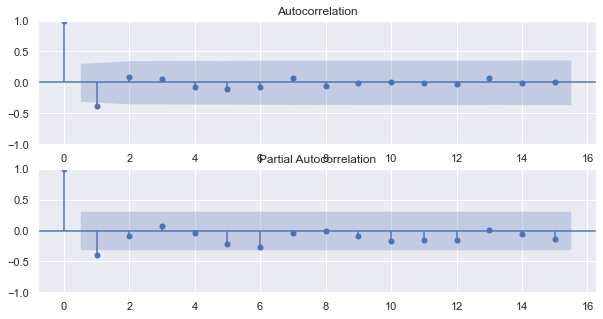

In [94]:
#create ACF and PACF plots again
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [95]:
# load data
series = sb_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,0))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

>Predicted=1447.841, Expected=1560
>Predicted=2033.460, Expected=1470
>Predicted=1901.502, Expected=1760
>Predicted=1645.442, Expected=1400
>Predicted=1565.827, Expected=799
RMSE: 446.846


In [96]:
#save prediction and original data in one dataframe
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_sb1 = pd.DataFrame()
predictionDf_sb1['Year'] = list(range(1980, 2023))
predictionDf_sb1 = predictionDf_sb1.set_index('Year')
predictionDf_sb1['ForecastResult'] = ForecastResult
predictionDf_sb1['Production'] = list(X) + [None]*2
print(predictionDf_sb1.tail())

      ForecastResult  Production
Year                            
2018     1901.501885      1760.0
2019     1645.441608      1400.0
2020     1565.827326       799.0
2021     1067.965981         NaN
2022      973.843903         NaN


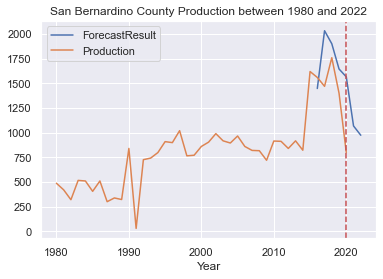

In [97]:
predictionDf_sb1.plot()
plt.title('San Bernardino County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [98]:
#### San Diego County

In [99]:
sd_df = model_data1[model_data1['County'] == 'San Diego']
sd_df1 = sd_df[['Year','Production']]
print(sd_df1)

     Year  Production
355  1980     49640.0
354  1981     81150.0
353  1982    131554.0
352  1983    141450.0
351  1984    160574.0
350  1985    130795.0
349  1986    132480.0
348  1987    138168.0
347  1988     91025.0
346  1989     80942.0
345  1990     54200.0
344  1991     76254.0
343  1992     75655.0
342  1993    126451.0
341  1994     68997.0
340  1995     61094.0
339  1996     71929.0
338  1997     63945.0
337  1998     68081.0
336  1999     55752.0
335  2000     60788.0
334  2001     80032.0
333  2002     75515.0
332  2003     63606.0
331  2004     87987.0
330  2005    114047.0
329  2006    121150.0
328  2007     67002.0
327  2008     59805.0
326  2009     45779.0
325  2010     81500.0
324  2011     65200.0
323  2012     93300.0
322  2013     98000.0
321  2014     59100.0
320  2015     42900.0
319  2016     58000.0
318  2017     34500.0
317  2018     47100.0
316  2019     35400.0
315  2020     50500.0


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



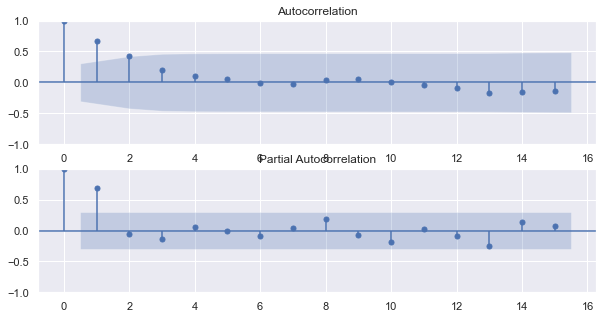

In [100]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sd_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(sd_df1['Production'], lags=15, ax=ax2)
plt.show()

In [101]:
# Check stationary
result = adfuller(sd_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.654728
p-value: 0.082205
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [102]:
# Differencing
time_series_diff = sd_df1['Production'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.963076
p-value: 0.000026
Critical Test Statistics Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



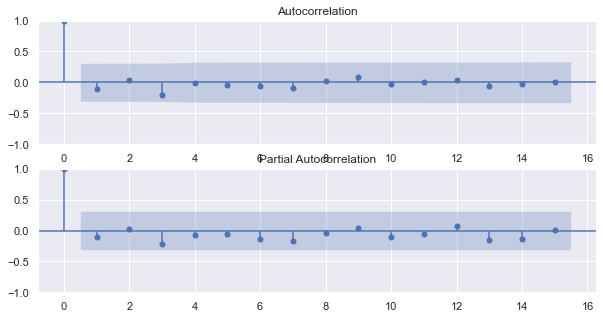

In [103]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [104]:

# load data
series = sd_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

>Predicted=42717.410, Expected=58000
>Predicted=57100.373, Expected=34500
>Predicted=34979.585, Expected=47100
>Predicted=45598.264, Expected=35400
>Predicted=35413.859, Expected=50500
RMSE: 15638.639


In [105]:
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_sd1 = pd.DataFrame()
predictionDf_sd1['Year'] = list(range(1980, 2023))
predictionDf_sd1 = predictionDf_sd1.set_index('Year')
predictionDf_sd1['ForecastResult'] = ForecastResult
predictionDf_sd1['Production'] = list(X) + [None]*2
print(predictionDf_sd1.tail())

      ForecastResult  Production
Year                            
2018    34979.585059     47100.0
2019    45598.264236     35400.0
2020    35413.859357     50500.0
2021    49142.437989         NaN
2022    48976.624635         NaN


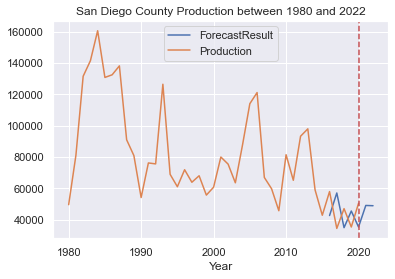

In [106]:
predictionDf_sd1.plot()
plt.title('San Diego County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [107]:
#### Ventura County

In [108]:
v_df = model_data1[model_data1['County'] == 'Ventura']
v_df1 = v_df[['Year','Production']]
print(v_df1)

     Year  Production
194  1980      8440.0
189  1981     52151.0
184  1982     17847.0
178  1983     39778.0
172  1984     52070.0
166  1985     35079.0
160  1986     35855.0
154  1987     38564.0
148  1988     47257.0
142  1989     36180.0
136  1990     21084.0
130  1991     21702.0
125  1992     23214.0
120  1993     82600.0
115  1994     30523.0
110  1995     53334.0
105  1996     37781.0
100  1997     36603.0
95   1998     31565.0
90   1999     24871.0
85   2000     32396.0
80   2001     43973.0
75   2002     60894.0
70   2003     48024.0
65   2004     63095.0
60   2005     29592.0
55   2006     79646.0
51   2007     26160.0
47   2008     29701.0
43   2009     17483.0
39   2010     91100.0
35   2011     28700.0
31   2012     65500.0
28   2013    113000.0
25   2014     48400.0
22   2015     56500.0
19   2016     61600.0
16   2017     54300.0
13   2018     52700.0
10   2019     49800.0
7    2020     70300.0


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



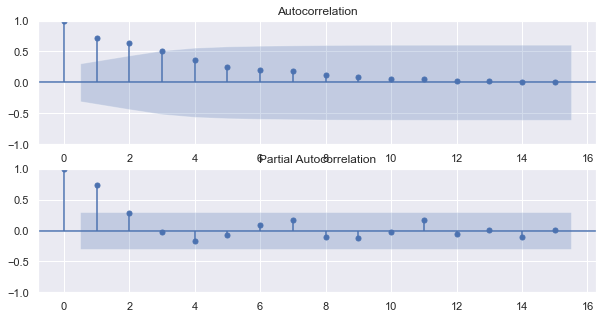

In [109]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sb_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(sb_df1['Production'], lags=15, ax=ax2)
plt.show()

In [110]:
# Check stationary
result = adfuller(v_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.786268
p-value: 0.998321
Critical Test Statistics Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621


In [111]:
# Differencing
time_series_diff = v_df1['Production'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.484031
p-value: 0.000210
Critical Test Statistics Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



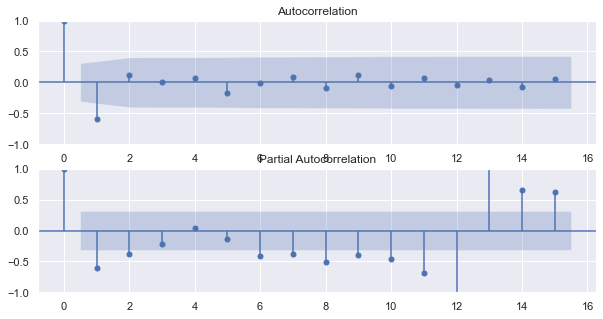

In [112]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [113]:
# load data
series = v_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,3))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,3))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

>Predicted=64937.282, Expected=61600
>Predicted=65111.549, Expected=54300


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



>Predicted=55737.653, Expected=52700
>Predicted=60033.115, Expected=49800
>Predicted=60899.560, Expected=70300
RMSE: 8128.214


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [114]:
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_v1 = pd.DataFrame()
predictionDf_v1['Year'] = list(range(1980, 2023))
predictionDf_v1 = predictionDf_v1.set_index('Year')
predictionDf_v1['ForecastResult'] = ForecastResult
predictionDf_v1['Production'] = list(X) + [None]*2
print(predictionDf_v1.tail())

      ForecastResult  Production
Year                            
2018    55737.652712     52700.0
2019    60033.114509     49800.0
2020    60899.560000     70300.0
2021    64048.163000         NaN
2022    63044.200764         NaN


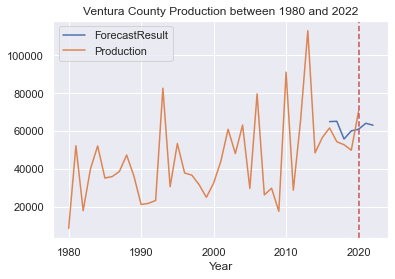

In [115]:
predictionDf_v1.plot()
plt.title('Ventura County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [116]:
#### Santa Barbara County

In [117]:
sbe_df = model_data1[model_data1['County'] == 'Santa Barbara']
sbe_df1 = sbe_df[['Year','Production']]
print(sbe_df1)

     Year  Production
193  1980     27050.0
188  1981     48418.0
182  1982     35325.0
176  1983     27670.0
170  1984     27521.0
164  1985     20906.0
158  1986     13159.0
152  1987     54786.0
146  1988     27338.0
140  1989     20739.0
134  1990     17586.0
129  1991     10078.0
124  1992     12211.0
119  1993     20687.0
114  1994     20629.0
109  1995     21228.0
104  1996     19771.0
99   1997     15002.0
94   1998     13888.0
89   1999     16746.0
84   2000      9496.0
79   2001     17884.0
74   2002     24136.0
69   2003     24638.0
64   2004     16970.0
59   2005     15801.0
54   2006     37871.0
50   2007      9910.0
46   2008     20290.0
42   2009     23236.0
38   2010     28600.0
34   2011     29000.0
30   2012     30900.0
27   2013     29200.0
24   2014     26400.0
21   2015     23400.0
18   2016     24600.0
15   2017     10500.0
12   2018     22500.0
9    2019     10700.0
6    2020     28200.0


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



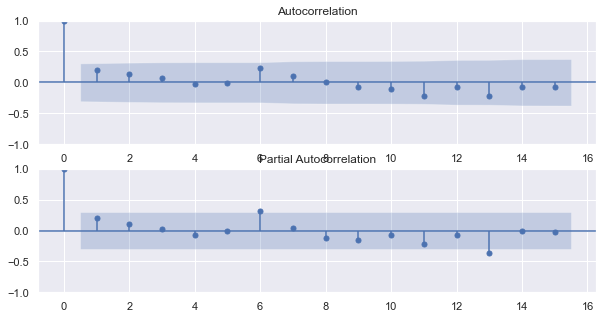

In [118]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sbe_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(sbe_df1['Production'], lags=15, ax=ax2)
plt.show()

In [119]:
# Check stationary
result = adfuller(sbe_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.034193
p-value: 0.000019
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [120]:
# load data
series = sbe_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

>Predicted=24510.219, Expected=24600
>Predicted=24000.484, Expected=10500
>Predicted=15727.630, Expected=22500
>Predicted=17078.945, Expected=10700
>Predicted=15452.769, Expected=28200
RMSE: 9287.830


In [121]:
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_sbe1 = pd.DataFrame()
predictionDf_sbe1['Year'] = list(range(1980, 2023))
predictionDf_sbe1 = predictionDf_sbe1.set_index('Year')
predictionDf_sbe1['ForecastResult'] = ForecastResult
predictionDf_sbe1['Production'] = list(X) + [None]*2
print(predictionDf_sbe1.tail())

      ForecastResult  Production
Year                            
2018    15727.629695     22500.0
2019    17078.945062     10700.0
2020    15452.768913     28200.0
2021    19841.554585         NaN
2022    23593.612734         NaN


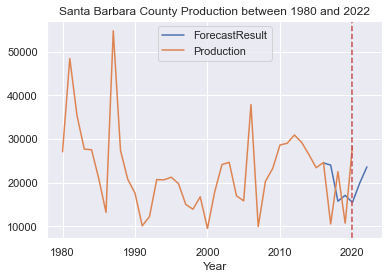

In [122]:
predictionDf_sbe1.plot()
plt.title('Santa Barbara County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [123]:
#### San Luis Obispo County

In [124]:
slo_df = model_data1[model_data1['County'] == 'San Luis Obispo']
slo_df1 = slo_df[['Year','Production']]
print(slo_df1)

     Year  Production
192  1980       398.0
187  1981       933.0
181  1982      1197.0
175  1983      1036.0
169  1984      1812.0
163  1985      3808.0
157  1986      3471.0
151  1987      2210.0
145  1988      2346.0
139  1989      4646.0
133  1990      1671.0
128  1991      1351.0
123  1992       699.0
118  1993      3768.0
113  1994      3156.0
108  1995      3254.0
103  1996      5181.0
98   1997      4133.0
93   1998      4013.0
88   1999      1791.0
83   2000       613.0
78   2001      5689.0
73   2002      4992.0
68   2003      6949.0
63   2004     15111.0
58   2005      4079.0
53   2006     22008.0
49   2007      3056.0
45   2008      5474.0
41   2009      3613.0
37   2010     22640.0
33   2011      6280.0
29   2012     12800.0
26   2013     22900.0
23   2014     11500.0
20   2015      9070.0
17   2016     19900.0
14   2017      9570.0
11   2018     19200.0
8    2019     12200.0
5    2020     25000.0


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



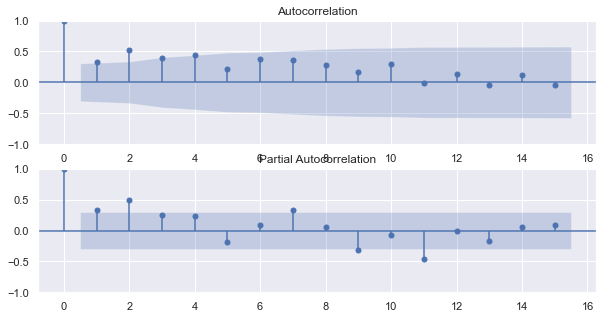

In [125]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(slo_df1['Production'], lags=15, ax=ax1)
ax2 = plot_pacf(slo_df1['Production'], lags=15, ax=ax2)
plt.show()

In [126]:
# Check stationary
result = adfuller(slo_df1['Production'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.110574
p-value: 0.995306
Critical Test Statistics Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


In [127]:
# Differencing
time_series_diff = slo_df1['Production'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.533715
p-value: 0.516772
Critical Test Statistics Values:
	1%: -3.670
	5%: -2.964
	10%: -2.621


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



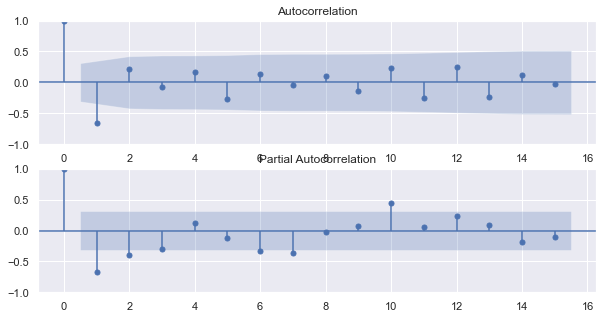

In [128]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [129]:
# load data
series = slo_df1['Production']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,3))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,3))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions.append(yhat)
	history.append(yhat)

/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



>Predicted=17046.881, Expected=19900
>Predicted=12088.998, Expected=9570


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



>Predicted=16535.032, Expected=19200
>Predicted=15430.218, Expected=12200


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



>Predicted=17235.336, Expected=25000
RMSE: 4296.790


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [130]:
ForecastResult = [None]*len(train)+ list(predictions)
#creating a dataframe for predicted values
predictionDf_slo1 = pd.DataFrame()
predictionDf_slo1['Year'] = list(range(1980, 2023))
predictionDf_slo1 = predictionDf_slo1.set_index('Year')
predictionDf_slo1['ForecastResult'] = ForecastResult
predictionDf_slo1['Production'] = list(X) + [None]*2
print(predictionDf_slo1.tail())

      ForecastResult  Production
Year                            
2018    16535.031521     19200.0
2019    15430.217742     12200.0
2020    17235.335583     25000.0
2021    12872.110544         NaN
2022    21489.766257         NaN


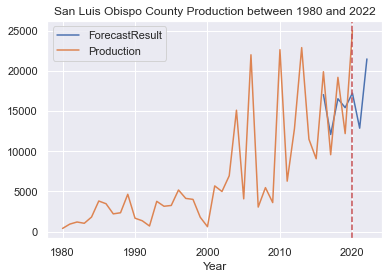

In [131]:
predictionDf_slo1.plot()
plt.title('San Luis Obispo County Production between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

### ARIMA: Forecasting Avocado Prices in California by County

In [132]:
#convert Price Per Ton to Price Per Pound
model_data1['PriceP/U'] = model_data1['PriceP/U']/2000

In [133]:
#prepare data for time series analysis graph
model_data2_TS = model_data1[model_data1['County'] == 'San Bernardino'][['Year']]
model_data2_TS['San Bernardino'] = model_data1[model_data1['County'] == 'San Bernardino'][['PriceP/U']]
model_data2_TS = model_data2_TS.reset_index(drop=True)
model_data2_TS['San Diego'] = model_data1[model_data1['County'] == 'San Diego'][['PriceP/U']].reset_index(drop=True)
model_data2_TS['San Luis Obispo'] = model_data1[model_data1['County'] == 'San Luis Obispo'][['PriceP/U']].reset_index(drop=True)
model_data2_TS['Santa Barbara'] = model_data1[model_data1['County'] == 'Santa Barbara'][['PriceP/U']].reset_index(drop=True)
model_data2_TS['Ventura'] = model_data1[model_data1['County'] == 'Ventura'][['PriceP/U']].reset_index(drop=True)

#set Year column as index
model_data2_TS = model_data2_TS.set_index('Year')
print(model_data2_TS)

      San Bernardino  San Diego  San Luis Obispo  Santa Barbara   Ventura
Year                                                                     
1980        0.264000   0.650000         0.965000       1.025000  0.940500
1981        0.126000   0.276500         0.260000       0.290000  0.260000
1982        0.107500   0.260000         0.465000       0.470000  0.450000
1983        0.121000   0.270000         0.312000       0.270000  0.312000
1984        0.090000   0.185000         0.270000       0.262000  0.271500
1985        0.307500   0.351000         0.425000       0.428500  0.400000
1986        0.123500   0.410000         0.522500       0.596500  0.632000
1987        0.081500   0.270000         0.262500       0.199000  0.271500
1988        0.550500   0.500000         0.805500       0.785500  0.613500
1989        0.369500   0.670000         0.825000       0.924500  0.763000
1990        0.400000   1.274500         1.125500       1.600500  1.265500
1991        0.407500   0.863000       

<Figure size 720x1080 with 0 Axes>

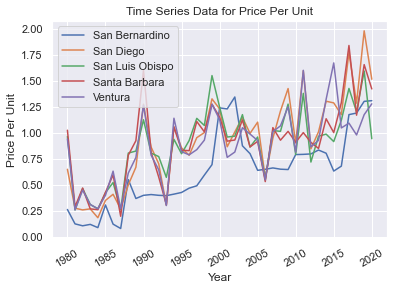

In [134]:
# Line plots of time series
sb.set(font_scale=1)
plt.gcf().set_size_inches(10, 15)

model_data2_TS.plot()
plt.title('Time Series Data for Price Per Unit')
plt.ylabel('Price Per Unit')
plt.xticks(rotation = 30)
plt.show()

In [135]:
### San Bernardino County

In [136]:
sb_df = model_data1[model_data1['County'] == 'San Bernardino']
sb_df2 = sb_df[['Year','PriceP/U']]
print(sb_df2)

     Year  PriceP/U
314  1980  0.264000
312  1981  0.126000
310  1982  0.107500
308  1983  0.121000
306  1984  0.090000
304  1985  0.307500
302  1986  0.123500
300  1987  0.081500
298  1988  0.550500
296  1989  0.369500
294  1990  0.400000
292  1991  0.407500
290  1992  0.400000
288  1993  0.397000
286  1994  0.411500
284  1995  0.427500
282  1996  0.469000
280  1997  0.491500
278  1998  0.594500
276  1999  0.694500
274  2000  1.239500
272  2001  1.229500
270  2002  1.344000
268  2003  0.875410
266  2004  0.800000
264  2005  0.640060
262  2006  0.650000
260  2007  0.662990
258  2008  0.650980
256  2009  0.647500
254  2010  0.791255
252  2011  0.793310
250  2012  0.797620
248  2013  0.834785
246  2014  0.804135
244  2015  0.633025
242  2016  0.680130
240  2017  1.174830
238  2018  1.189775
236  2019  1.302145
234  2020  1.308510


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



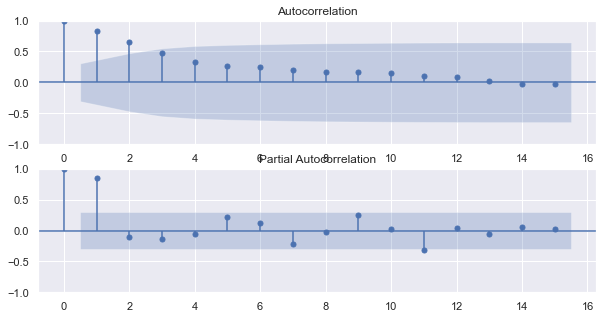

In [137]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sb_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(sb_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [138]:
# Check stationary
result = adfuller(sb_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.152243
p-value: 0.693795
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [139]:
# Differencing
time_series_diff = sb_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.648104
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



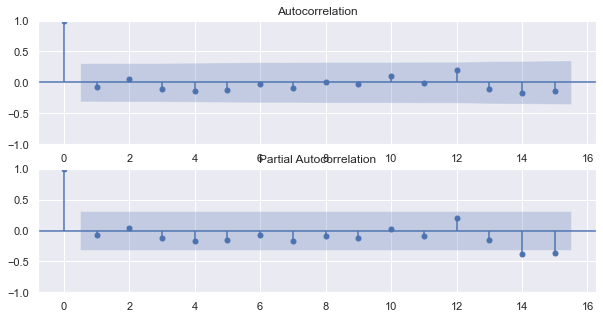

In [140]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [141]:
# load data
series = sb_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)

>Predicted=0.657, Expected=  1
>Predicted=0.689, Expected=  1
>Predicted=1.173, Expected=  1
>Predicted=1.215, Expected=  1
>Predicted=1.324, Expected=  1
RMSE: 0.221


In [142]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_sb2 = pd.DataFrame()
predictionDf_sb2['Year'] = list(range(1980, 2023))
predictionDf_sb2 = predictionDf_sb2.set_index('Year')
predictionDf_sb2['ForecastResult'] = ForecastResult
predictionDf_sb2['Price/Pound'] = list(X) + [None]*2
print(predictionDf_sb2.tail())

      ForecastResult  Price/Pound
Year                             
2018        1.172591     1.189775
2019        1.214846     1.302145
2020        1.324412     1.308510
2021        1.335927          NaN
2022        1.362218          NaN


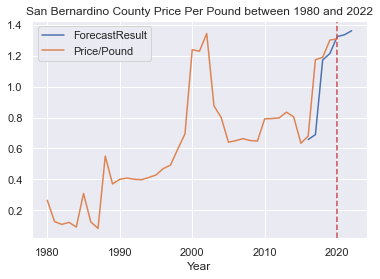

In [143]:
predictionDf_sb2.plot()
plt.title('San Bernardino County Price Per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [144]:
### San Diego County

In [145]:
sd_df = model_data1[model_data1['County'] == 'San Diego']
sd_df2 = sd_df[['Year','PriceP/U']]
print(sd_df2)

     Year  PriceP/U
355  1980  0.650000
354  1981  0.276500
353  1982  0.260000
352  1983  0.270000
351  1984  0.185000
350  1985  0.351000
349  1986  0.410000
348  1987  0.270000
347  1988  0.500000
346  1989  0.670000
345  1990  1.274500
344  1991  0.863000
343  1992  0.703000
342  1993  0.304000
341  1994  1.057000
340  1995  0.855500
339  1996  0.784500
338  1997  0.953500
337  1998  1.002500
336  1999  1.326000
335  2000  1.230000
334  2001  0.866000
333  2002  1.008500
332  2003  1.149040
331  2004  0.994500
330  2005  1.102405
329  2006  0.566675
328  2007  0.948475
327  2008  1.209720
326  2009  1.425085
325  2010  0.902160
324  2011  1.596095
323  2012  0.846205
322  2013  1.009770
321  2014  1.303200
320  2015  1.287345
319  2016  1.174360
318  2017  1.770870
317  2018  1.284905
316  2019  1.979040
315  2020  1.514435


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



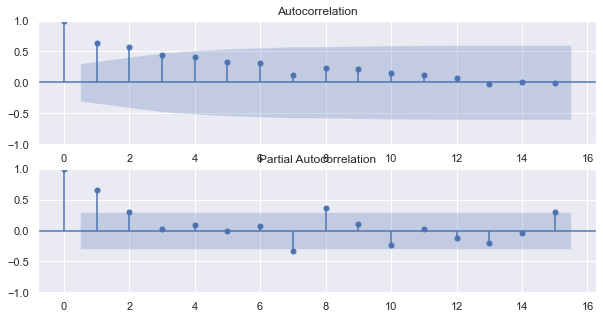

In [146]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sd_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(sd_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [147]:
# Check stationary
result = adfuller(sd_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.479124
p-value: 0.543812
Critical Test Statistics Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


In [148]:
# Differencing
time_series_diff = sd_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.752018
p-value: 0.003438
Critical Test Statistics Values:
	1%: -3.654
	5%: -2.957
	10%: -2.618


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



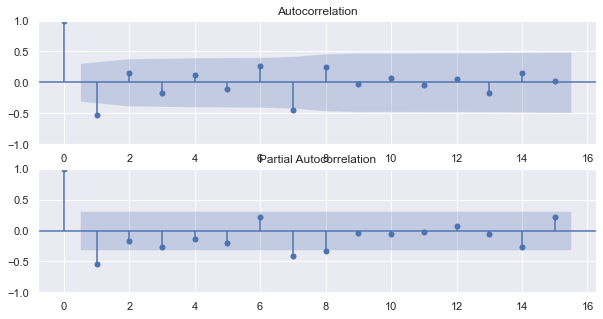

In [149]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [150]:
# load data
series = sd_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(2,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



>Predicted=1.313, Expected=  1
>Predicted=1.262, Expected=  2


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



>Predicted=1.536, Expected=  1
>Predicted=1.582, Expected=  2
>Predicted=1.627, Expected=  2
RMSE: 0.320


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [151]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_sd2 = pd.DataFrame()
predictionDf_sd2['Year'] = list(range(1980, 2023))
predictionDf_sd2 = predictionDf_sd2.set_index('Year')
predictionDf_sd2['ForecastResult'] = ForecastResult
predictionDf_sd2['Price/Unit'] = list(X) + [None]*2
print(predictionDf_sd2.tail())

      ForecastResult  Price/Unit
Year                            
2018        1.535532    1.284905
2019        1.582133    1.979040
2020        1.626794    1.514435
2021        1.872722         NaN
2022        1.646940         NaN


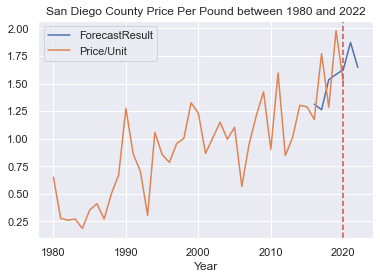

In [152]:
predictionDf_sd2.plot()
plt.title('San Diego County Price Per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [153]:
### Ventura County

In [154]:
v_df = model_data1[model_data1['County'] == 'Ventura']
v_df2 = v_df[['Year','PriceP/U']]
print(v_df2)

     Year  PriceP/U
194  1980  0.940500
189  1981  0.260000
184  1982  0.450000
178  1983  0.312000
172  1984  0.271500
166  1985  0.400000
160  1986  0.632000
154  1987  0.271500
148  1988  0.613500
142  1989  0.763000
136  1990  1.265500
130  1991  0.785500
125  1992  0.645000
120  1993  0.302000
115  1994  1.140000
110  1995  0.818500
105  1996  0.789000
100  1997  0.838500
95   1998  0.930000
90   1999  1.273500
85   2000  1.128000
80   2001  0.764500
75   2002  0.815500
70   2003  1.049060
65   2004  0.987890
60   2005  0.925975
55   2006  0.548620
51   2007  1.011295
47   2008  1.066900
43   2009  1.249130
39   2010  0.814175
35   2011  1.600155
31   2012  0.865000
28   2013  0.927980
25   2014  1.322085
22   2015  1.670955
19   2016  1.047080
16   2017  1.092820
13   2018  0.979620
10   2019  1.174510
7    2020  1.278285


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



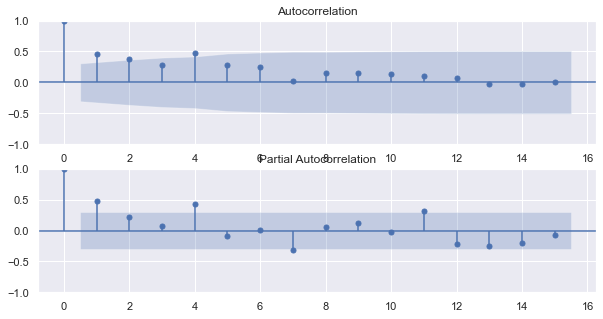

In [155]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(v_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(v_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [156]:
# Check stationary
result = adfuller(v_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.456596
p-value: 0.554863
Critical Test Statistics Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


In [157]:
# Differencing
time_series_diff = v_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.674454
p-value: 0.000094
Critical Test Statistics Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



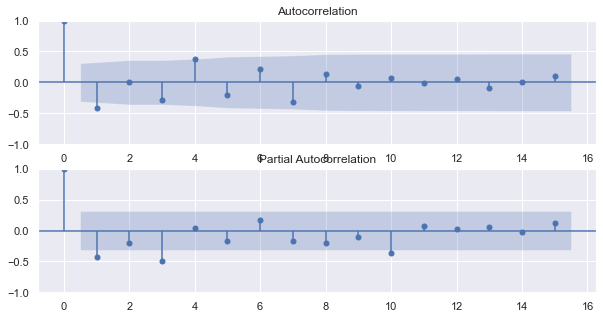

In [158]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [159]:

# load data
series = v_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)

/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



>Predicted=1.562, Expected=  1
>Predicted=1.293, Expected=  1
>Predicted=0.921, Expected=  1
>Predicted=1.136, Expected=  1
>Predicted=1.034, Expected=  1
RMSE: 0.272


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [160]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_v2 = pd.DataFrame()
predictionDf_v2['Year'] = list(range(1980, 2023))
predictionDf_v2 = predictionDf_v2.set_index('Year')
predictionDf_v2['ForecastResult'] = ForecastResult
predictionDf_v2['Price/Pound'] = list(X) + [None]*2
print(predictionDf_v2.tail())

      ForecastResult  Price/Pound
Year                             
2018        0.921237     0.979620
2019        1.135792     1.174510
2020        1.033585     1.278285
2021        1.373964          NaN
2022        1.310310          NaN


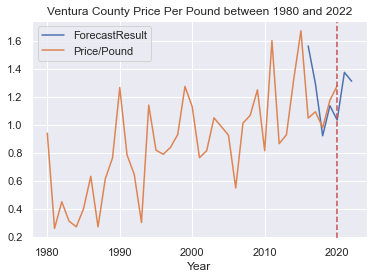

In [161]:
predictionDf_v2.plot()
plt.title('Ventura County Price Per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [162]:
### Santa Barbara County

In [163]:
sbe_df = model_data1[model_data1['County'] == 'Santa Barbara']
sbe_df2 = sbe_df[['Year','PriceP/U']]
print(sbe_df2)

     Year  PriceP/U
193  1980  1.025000
188  1981  0.290000
182  1982  0.470000
176  1983  0.270000
170  1984  0.262000
164  1985  0.428500
158  1986  0.596500
152  1987  0.199000
146  1988  0.785500
140  1989  0.924500
134  1990  1.600500
129  1991  0.812500
124  1992  0.575000
119  1993  0.311500
114  1994  1.056500
109  1995  0.833500
104  1996  0.828500
99   1997  1.108500
94   1998  1.009500
89   1999  1.275500
84   2000  1.150500
79   2001  0.920000
74   2002  0.931000
69   2003  1.123990
64   2004  0.864865
59   2005  0.918220
54   2006  0.531910
50   2007  1.050030
46   2008  0.929385
42   2009  1.014145
38   2010  0.910190
34   2011  1.002035
30   2012  0.908560
27   2013  0.850120
24   2014  1.135150
21   2015  1.002160
18   2016  1.290305
15   2017  1.838380
12   2018  1.169265
9    2019  1.654720
6    2020  1.421295


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



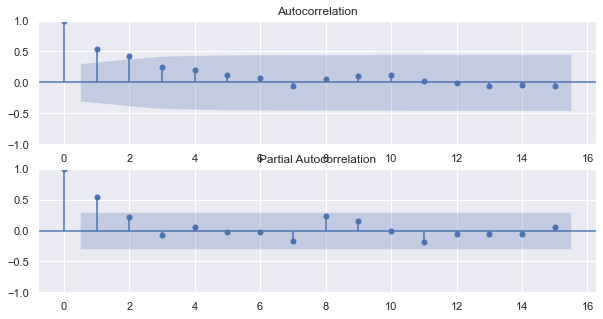

In [164]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(sbe_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(sbe_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [165]:
# Check stationary
result = adfuller(sbe_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.166084
p-value: 0.022034
Critical Test Statistics Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [166]:
# Differencing
time_series_diff = sbe_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.232192
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



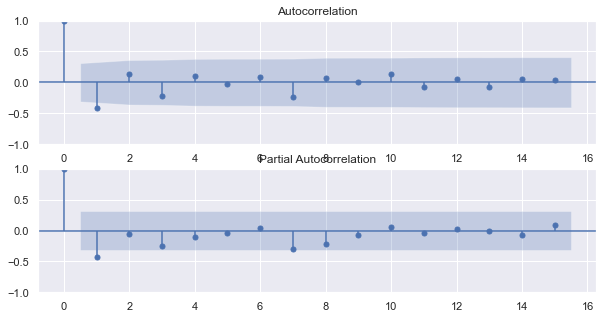

In [167]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [168]:
# load data
series = sbe_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)

>Predicted=1.063, Expected=  1
>Predicted=1.191, Expected=  2
>Predicted=1.680, Expected=  1
>Predicted=1.467, Expected=  2
>Predicted=1.465, Expected=  1
RMSE: 0.392


In [169]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_sbe2 = pd.DataFrame()
predictionDf_sbe2['Year'] = list(range(1980, 2023))
predictionDf_sbe2 = predictionDf_sbe2.set_index('Year')
predictionDf_sbe2['ForecastResult'] = ForecastResult
predictionDf_sbe2['Price/Pound'] = list(X) + [None]*2
print(predictionDf_sbe2.tail())

      ForecastResult  Price/Pound
Year                             
2018        1.679819     1.169265
2019        1.467300     1.654720
2020        1.465191     1.421295
2021        1.552033          NaN
2022        1.518788          NaN


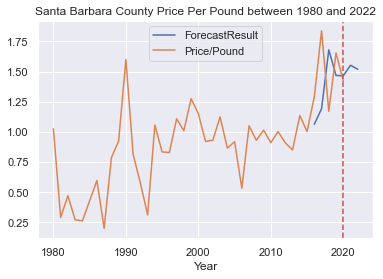

In [170]:
predictionDf_sbe2.plot()
plt.title('Santa Barbara County Price Per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

In [171]:
### San Luis Obispo County

In [172]:
slo_df = model_data1[model_data1['County'] == 'San Luis Obispo']
slo_df2 = slo_df[['Year','PriceP/U']]
print(slo_df2)

     Year  PriceP/U
192  1980  0.965000
187  1981  0.260000
181  1982  0.465000
175  1983  0.312000
169  1984  0.270000
163  1985  0.425000
157  1986  0.522500
151  1987  0.262500
145  1988  0.805500
139  1989  0.825000
133  1990  1.125500
128  1991  0.805500
123  1992  0.772000
118  1993  0.572500
113  1994  0.937500
108  1995  0.799000
103  1996  0.926500
98   1997  1.139000
93   1998  1.070500
88   1999  1.549500
83   2000  1.248000
78   2001  0.959500
73   2002  0.968000
68   2003  1.174630
63   2004  0.863115
58   2005  0.959915
53   2006  0.550300
49   2007  1.021595
45   2008  1.014385
41   2009  1.275670
37   2010  0.792005
33   2011  1.378980
29   2012  0.719490
26   2013  0.967225
23   2014  0.987565
20   2015  0.915820
17   2016  1.121305
14   2017  1.426070
11   2018  1.201695
8    2019  1.593240
5    2020  0.943380


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



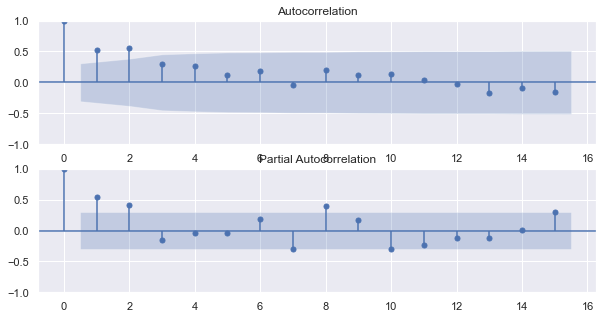

In [173]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(slo_df2['PriceP/U'], lags=15, ax=ax1)
ax2 = plot_pacf(slo_df2['PriceP/U'], lags=15, ax=ax2)
plt.show()

In [174]:
# Check stationary
result = adfuller(slo_df2['PriceP/U'],autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.785900
p-value: 0.387484
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


In [175]:
# Differencing
time_series_diff = slo_df2['PriceP/U'].diff()
time_series_diff.dropna(inplace=True)

# Check stationary again
result = adfuller(time_series_diff,autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.223096
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


/opt/anaconda3/envs/spyder-env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



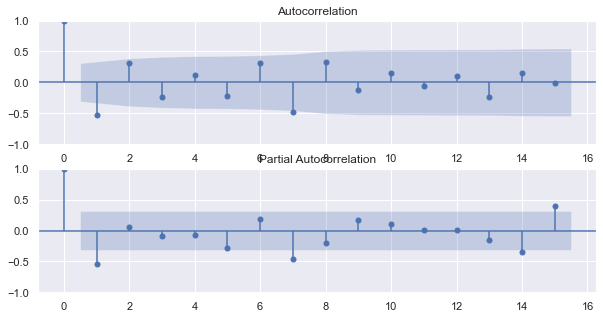

In [176]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=False, sharey=False)
ax1 = plot_acf(time_series_diff, lags=15, ax=ax1)
ax2 = plot_pacf(time_series_diff, lags=15, ax=ax2)
plt.show()

In [177]:
# load data
series = slo_df2['PriceP/U']
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions2 = list()
for i in range(len(test)):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions2)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

#Make predictions for 2021 and 2022
for i in range(2):
	# difference data
	diff = difference(history, 1)
	# predict
	model = ARIMA(diff, order=(1,1,2))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, 1)
	predictions2.append(yhat)
	history.append(yhat)

>Predicted=0.964, Expected=  1
>Predicted=1.015, Expected=  1
>Predicted=1.302, Expected=  1
>Predicted=1.363, Expected=  2
>Predicted=1.386, Expected=  1
RMSE: 0.301


In [178]:
ForecastResult = [None]*len(train)+ list(predictions2)
#creating a dataframe for predicted values
predictionDf_slo2 = pd.DataFrame()
predictionDf_slo2['Year'] = list(range(1980, 2023))
predictionDf_slo2 = predictionDf_slo2.set_index('Year')
predictionDf_slo2['ForecastResult'] = ForecastResult
predictionDf_slo2['Price/Pound'] = list(X) + [None]*2
print(predictionDf_slo2.tail())

      ForecastResult  Price/Pound
Year                             
2018        1.301721     1.201695
2019        1.362508     1.593240
2020        1.385578     0.943380
2021        1.383258          NaN
2022        1.091273          NaN


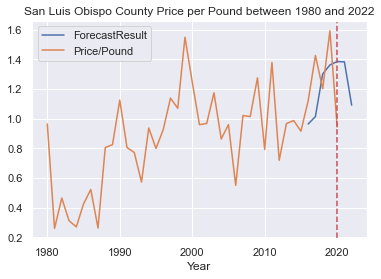

In [179]:
predictionDf_slo2.plot()
plt.title('San Luis Obispo County Price per Pound between 1980 and 2022')
plt.axvline(x=2020, ls = '--', c='r')

## Time Series Analysis Using Prophet

In [180]:
#Stationarity
#Ho: It is non-stationary
#H1: It is stationary
#p-value <.05, we reject Ho, >.05 we accept the Ho

def adfuller_test(feature):
    result=adfuller(feature)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("There is strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary")
    else:
        print("There is weak evidence against null hypothesis,indicating it is non-stationary ")


In [181]:
print(adfuller_test(ventura['Production']))
print(adfuller_test(SanBern['Production']))
print(adfuller_test(SanBarb['Production']))
print(adfuller_test(SanLO['Production']))
print(adfuller_test(SanDie['Production']))
print(adfuller_test(adf_grouped['Total_Production']))
print(adfuller_test(adf_grouped['Fire_Count']))

ADF Test Statistic : 1.7862682752896777
p-value : 0.9983213899882127
#Lags Used : 10
Number of Observations : 30
There is weak evidence against null hypothesis,indicating it is non-stationary 
None
ADF Test Statistic : -1.7650857393580923
p-value : 0.3979281747418138
#Lags Used : 1
Number of Observations : 39
There is weak evidence against null hypothesis,indicating it is non-stationary 
None
ADF Test Statistic : -5.0341931972624785
p-value : 1.8982785949462717e-05
#Lags Used : 0
Number of Observations : 40
There is strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary
None
ADF Test Statistic : 1.1105735582686942
p-value : 0.995305860949425
#Lags Used : 7
Number of Observations : 33
There is weak evidence against null hypothesis,indicating it is non-stationary 
None
ADF Test Statistic : -2.654728143780781
p-value : 0.08220519462377202
#Lags Used : 0
Number of Observations : 40
There is weak evidence against null hypothesis,indicating it is non-stat

In [182]:
#Log Transformation to make data stationary
ventura[["Production"
         , "HarvestedAcres"
         ,"Avg_Temp"
         ,"Fire_Count"]] = ventura[["Production"
                                    , "HarvestedAcres"
                                    ,"Avg_Temp"
                                    ,"Fire_Count"]].apply(np.log)
SanBern[["Production"
         , "HarvestedAcres"
         ,"Avg_Temp"
         ,"Fire_Count"]] = SanBern[["Production"
                                    , "HarvestedAcres"
                                    ,"Avg_Temp"
                                    ,"Fire_Count"]].apply(np.log)
SanBarb[["Production"
         , "HarvestedAcres"
         ,"Avg_Temp"
         ,"Fire_Count"]] = SanBarb[["Production"
                                    , "HarvestedAcres"
                                    ,"Avg_Temp"
                                    ,"Fire_Count"]].apply(np.log)
SanLO[["Production"
         , "HarvestedAcres"
         ,"Avg_Temp"
         ,"Fire_Count"]] = SanLO[["Production"
                                    , "HarvestedAcres"
                                    ,"Avg_Temp"
                                    ,"Fire_Count"]].apply(np.log)
SanDie[["Production"
         , "HarvestedAcres"
         ,"Avg_Temp"
         ,"Fire_Count"]] = SanDie[["Production"
                                    , "HarvestedAcres"
                                    ,"Avg_Temp"
                                    ,"Fire_Count"]].apply(np.log)
adf_grouped[["Total_Production"
         , "Total_HarvestedAcres"
         ,"Fire_Count"]] = adf_grouped[["Total_Production"
                                    , "Total_HarvestedAcres"
                                    ,"Fire_Count"]].apply(np.log)

In [183]:
# Checking for Stationarity After Differencing
#All regressors are stationary, output is not

print(adfuller_test(ventura['Avg_Temp'])) 
print(adfuller_test(SanBern['Avg_Temp']))
print(adfuller_test(SanBarb['Avg_Temp']))
print(adfuller_test(SanLO['Avg_Temp']))
print(adfuller_test(SanDie['Avg_Temp']))

print(adfuller_test(ventura['Avg_Prec'])) 
print(adfuller_test(SanBern['Avg_Prec']))
print(adfuller_test(SanBarb['Avg_Prec']))
print(adfuller_test(SanLO['Avg_Prec']))
print(adfuller_test(SanDie['Avg_Prec']))

print(adfuller_test(ventura['Fire_Count'])) 
print(adfuller_test(SanBern['Fire_Count']))
print(adfuller_test(SanBarb['Fire_Count']))
print(adfuller_test(SanLO['Fire_Count']))
print(adfuller_test(SanDie['Fire_Count']))
print(adfuller_test(adf_grouped['Fire_Count']))
print(adfuller_test(ventura['Production']))
print(adfuller_test(SanBern['Production']))
print(adfuller_test(SanBarb['Production'])) 
print(adfuller_test(SanLO['Production']))
print(adfuller_test(SanDie['Production']))
print(adfuller_test(adf_grouped['Total_Production'])) 

ADF Test Statistic : -3.489544565495736
p-value : 0.008259707096706946
#Lags Used : 0
Number of Observations : 40
There is strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary
None
ADF Test Statistic : -4.295480072073832
p-value : 0.00045228667810276566
#Lags Used : 0
Number of Observations : 40
There is strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary
None
ADF Test Statistic : -3.489544565495736
p-value : 0.008259707096706946
#Lags Used : 0
Number of Observations : 40
There is strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary
None
ADF Test Statistic : -3.489544565495736
p-value : 0.008259707096706946
#Lags Used : 0
Number of Observations : 40
There is strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary
None
ADF Test Statistic : -3.0918923705771566
p-value : 0.02715903658829823
#Lags Used : 0
Number of Observations : 40
Ther

### Prophet Analysis: Total Production of California Avocado Industry
(Five Counties with full full 41-year records)

In [184]:
#making dfs with Prophet nomenclature for total production and total harvested acres
a=adf_grouped.rename(columns={'Year':'ds'})
a1 = a.rename(columns={'Total_Production': 'y'})
a2=a1.rename(columns={'y':'Total_Production','Total_HarvestedAcres':'y'})
a1['ds'] = pd.to_datetime(a1['ds'], format='%Y').dt.strftime('%Y')
a2['ds'] = pd.to_datetime(a2['ds'],format='%Y').dt.strftime('%Y')

In [185]:
#Getting years 1980-2014 for train set & 2015-2020 for test set
a1train=a1.loc[(a1['ds'] < '2015')]
a1train.reset_index(drop=True)
a1test=a1.loc[(a1['ds']>='2015')]
a1test.reset_index(drop=True)

a2train=a2.loc[(a1['ds'] < '2015')]
a2train.reset_index(drop=True)
a2test=a2.loc[(a1['ds']>='2015')]
a2test.reset_index(drop=True)

ds  Avg_HarvestedAcres          y  Avg_Yield  Total_Yield  \
0  2015         7683.428571  10.892731   2.674286        18.72   
1  2016         7161.428571  10.822375   4.162857        29.14   
2  2017         6590.000000  10.739219   2.901429        20.31   
3  2018         6981.857143  10.796980   3.870000        27.09   
4  2019         6401.714286  10.710231   3.674286        25.72   
5  2020         6900.500000  10.631109   4.385000        26.31   

   Avg_Production  Total_Production  Avg_PriceP/U     Avg_Value  Fire_Count  
0    20641.857143         11.880986   2337.484286  5.597857e+07    5.733341  
1    26340.000000         12.124754   2139.391429  5.886557e+07    5.855072  
2    18460.000000         11.769272   2872.018571  5.057443e+07    6.408529  
3    22945.714286         11.986797   2325.541429  5.262543e+07    6.016157  
4    18154.285714         11.752572   2916.120000  5.415257e+07    5.743003  
5    29339.833333         12.078461   2551.941667  7.750950e+07    6.212606

In [186]:
#Prophet Analysis TOTAL PRODUCTION
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
#fit the model to each zipcode (group)
m.fit(a1train)
#makes df
future = m.make_future_dataframe(periods=20,freq ='Y')
forecast = m.predict(future)
ca_production=forecast[['ds','yhat','yhat_lower','yhat_upper']]
ca_production

19:53:51 - cmdstanpy - INFO - Chain [1] start processing
19:53:53 - cmdstanpy - INFO - Chain [1] done processing


ds       yhat  yhat_lower  yhat_upper
0  1980-01-01  11.474968   11.219649   11.741410
1  1981-01-01  12.252462   11.981910   12.517176
2  1982-01-01  12.355260   12.070077   12.629914
3  1983-01-01  12.449554   12.180144   12.726000
4  1984-01-01  12.535151   12.268424   12.790916
5  1985-01-01  12.379236   12.125591   12.628406
6  1986-01-01  12.368952   12.106458   12.628174
7  1987-01-01  12.351333   12.071617   12.612615
8  1988-01-01  12.325066   12.073033   12.556063
9  1989-01-01  11.997371   11.737158   12.263354
10 1990-01-01  11.700245   11.445972   11.988971
11 1991-01-01  11.825142   11.578470   12.096248
12 1992-01-01  11.941784   11.690429   12.202094
13 1993-01-01  12.494744   12.249637   12.750914
14 1994-01-01  11.953571   11.692433   12.202136
15 1995-01-01  12.022638   11.774131   12.294150
16 1996-01-01  11.999973   11.744880   12.283149
17 1997-01-01  11.914259   11.656777   12.190569
18 1998-01-01  11.856180   11.597027   12.136457
19 1999-01-01  11.716556   11.441028   11.991694
20 2000-01-01  11.870807   11.616097   12.130688
21 2001-01-01  12.012546   11.717187   12.277819
22 2002-01-01  12.130196   11.866038   12.401835
23 2003-01-01  12.132106   11.863735   12.400901
24 2004-01-01  12.232947   11.971777   12.494613
25 2005-01-01  12.210018   11.951011   12.476635
26 2006-01-01  12.523919   12.260491   12.773157
27 2007-01-01  11.790079   11.528387   12.062393
28 2008-01-01  11.867520   11.597188   12.147196
29 2009-01-01  11.932365   11.672968   12.185037
30 2010-01-01  12.026473   11.750689   12.292622
31 2011-01-01  12.112293   11.851139   12.373643
32 2012-01-01  12.189651   11.933768   12.464496
33 2013-01-01  12.254069   12.004574   12.516101
34 2014-01-01  12.348544   12.093565   12.606761
35 2014-12-31  12.369352   11.905306   12.777986
36 2015-12-31  12.411316   11.194913   13.514419
37 2016-12-31  12.580204   10.393406   14.482210
38 2017-12-31  12.639619    9.290724   15.550122
39 2018-12-31  12.689883    8.236873   16.757819
40 2019-12-31  12.730866    6.817921   18.110198
41 2020-12-31  12.902027    5.732681   19.549415
42 2021-12-31  12.960908    4.161217   21.273561
43 2022-12-31  13.010415    2.819176   22.539538
44 2023-12-31  13.050416    1.243863   24.284536
45 2024-12-31  13.223849   -0.298587   26.802452
46 2025-12-31  13.282197   -1.867624   28.831547
47 2026-12-31  13.330946   -3.771337   30.719359
48 2027-12-31  13.369966   -5.755672   32.562969
49 2028-12-31  13.545672   -8.099794   35.236152
50 2029-12-31  13.603486  -10.226849   37.831928
51 2030-12-31  13.651477  -12.749397   39.366695
52 2031-12-31  13.689516  -14.927557   42.460156
53 2032-12-31  13.867495  -16.966914   45.438206
54 2033-12-31  13.924776  -18.853224   47.663610

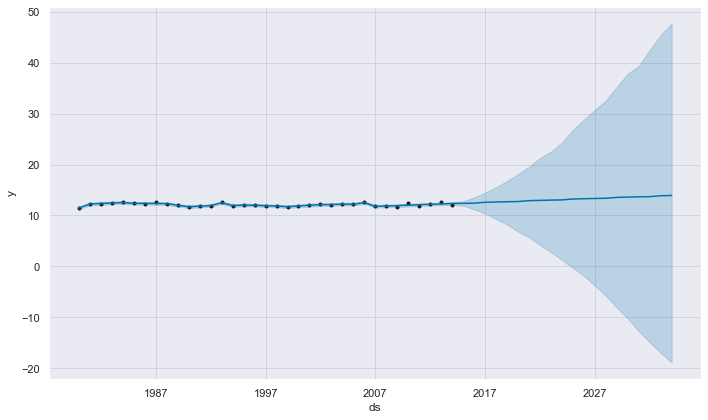

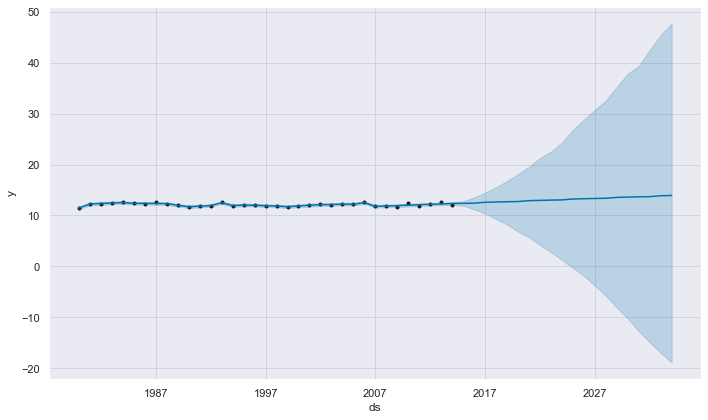

In [187]:
m.plot(ca_production)

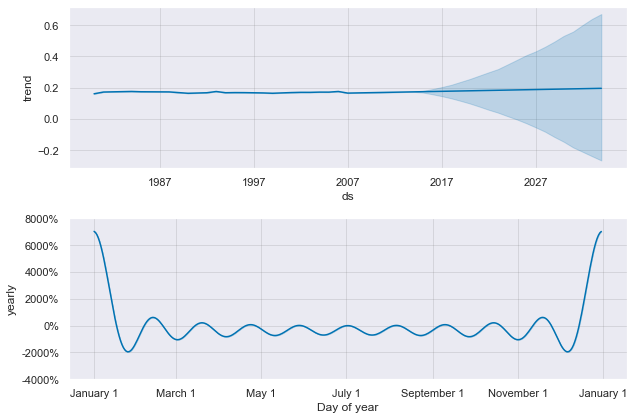

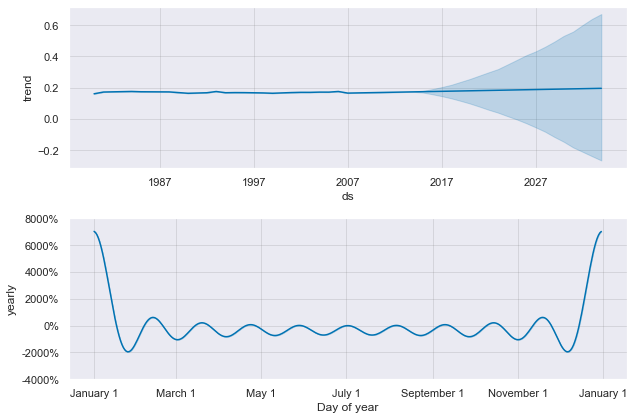

In [188]:
m.plot_components(forecast)

In [189]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted production and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2014-12-31')& (forecast['ds']<='2019-12-31')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')
mse=mean_squared_error(np.exp(a1test.y),np.exp(metrics.yhat))
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
144444.8443219684


In [190]:
print(np.exp(ca_production.yhat))

0     9.627541e+04
1     2.094965e+05
2     2.321780e+05
3     2.551364e+05
4     2.779372e+05
5     2.378120e+05
6     2.353790e+05
7     2.312682e+05
8     2.252724e+05
9     1.623275e+05
10    1.206013e+05
11    1.366450e+05
12    1.535504e+05
13    2.669307e+05
14    1.553709e+05
15    1.664812e+05
16    1.627504e+05
17    1.493815e+05
18    1.409527e+05
19    1.225845e+05
20    1.430296e+05
21    1.648096e+05
22    1.853861e+05
23    1.857405e+05
24    2.054477e+05
25    2.007906e+05
26    2.748329e+05
27    1.319369e+05
28    1.425603e+05
29    1.521109e+05
30    1.671209e+05
31    1.820967e+05
32    1.967425e+05
33    2.098333e+05
34    2.306240e+05
35    2.354731e+05
36    2.455647e+05
37    2.907457e+05
38    3.085438e+05
39    3.244489e+05
40    3.380219e+05
41    4.011244e+05
42    4.254523e+05
43    4.470451e+05
44    4.652899e+05
45    5.534073e+05
46    5.866580e+05
47    6.159653e+05
48    6.404753e+05
49    7.635028e+05
50    8.089452e+05
51    8.487138e+05
52    8.8161

### Prophet Analysis: California Avocado Production w/ State-wide Fire Count Regressor

In [191]:
#Prophet Analysis for Total Production w/ Fire Count Regressor
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Fire_Count')
#fit the model to trainset
m.fit(a1train)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y') #period limited to how much fire count data we have
future['Fire_Count'] = a['ds']

forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:53:55 - cmdstanpy - INFO - Chain [1] start processing
19:53:57 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat  yhat_lower  yhat_upper
0   1980  141.728888  141.478472  141.979139
1   1981  151.728987  151.478052  151.977083
2   1982  153.092399  152.849143  153.347194
3   1983  154.448391  154.183810  154.714096
4   1984  155.562737  155.304729  155.825609
5   1985  153.698337  153.437085  153.961774
6   1986  153.448623  153.185986  153.706296
7   1987  153.189884  152.939162  153.469954
8   1988  152.922174  152.663693  153.181354
9   1989  149.340088  149.090975  149.585645
10  1990  145.774490  145.514029  146.040544
11  1991  147.353326  147.094858  147.602331
12  1992  148.924226  148.663585  149.189814
13  1993  155.829994  155.566451  156.094707
14  1994  148.816437  148.543657  149.076751
15  1995  149.802549  149.554602  150.061262
16  1996  149.318090  149.061546  149.585108
17  1997  148.752046  148.503738  149.022319
18  1998  148.158537  147.912519  148.431920
19  1999  146.096535  145.835041  146.349118
20  2000  148.193455  147.940052  148.448077
21  2001  150.304457  150.057369  150.561855
22  2002  151.500901  151.258048  151.753827
23  2003  151.267812  151.007616  151.530628
24  2004  152.907598  152.656567  153.167391
25  2005  152.582208  152.316535  152.834271
26  2006  156.479382  156.217483  156.763854
27  2007  147.283266  147.023840  147.546751
28  2008  148.375164  148.098602  148.643259
29  2009  149.477503  149.218144  149.727433
30  2010  150.588011  150.343080  150.849969
31  2011  151.691089  151.424938  151.943133
32  2012  152.786562  152.503362  153.033674
33  2013  153.892668  153.616115  154.122349
34  2014  155.007214  154.734879  155.234787
35  2015  156.025767  150.519346  160.771594
36  2016  157.089293  140.987134  172.155182
37  2017  158.304193  129.354708  185.077740
38  2018  159.387088  115.365890  198.704535
39  2019  160.461689   97.989804  214.064219
40  2020  161.527866   80.327845  232.211637

In [192]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted production and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')] 
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')
mse=mean_squared_error(np.exp(a1test.y),np.exp(metrics.yhat))
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
6.150563494215411e+69


### Prophet Analysis: Forecasting Baseline Production in Ventura 

In [193]:
v1=ventura
v1 = v1.rename(columns={'Year':'ds','Production': 'y',})
v1['ds'] = pd.to_datetime(v1['ds'],format='%Y').dt.strftime('%Y')
v1=v1.reset_index()
v1.head()

index    ds  CountyCode  HarvestedAcres  Yield          y  PriceP/U  \
0    194  1980         111        9.298076   0.77   9.040738    1881.0   
1    189  1981         111        9.400961   4.31  10.861899     520.0   
2    184  1982         111        9.453130   1.40   9.789591     900.0   
3    178  1983         111        9.657331   2.54  10.591069     624.0   
4    172  1984         111        9.695910   3.20  10.860344     543.0   

        Value  Avg_Temp Avg_Prec  Fire_Count  
0  15879000.0  4.172848     0.06    5.746203  
1  27100000.0  4.191169     0.03    5.602119  
2  16063000.0  4.163560     0.03    4.976734  
3  24822000.0  4.186620     0.07    5.068904  
4  28258000.0  4.183576     0.02    5.379897

In [194]:
#Getting years 1980-2014 for train set & 2015-2020 for test set
v1train=v1.loc[(v1['ds'] < '2015')]
v1train.reset_index(drop=True)
v1test=v1.loc[(v1['ds']>='2015')]
v1test.reset_index(drop=True)

index    ds  CountyCode  HarvestedAcres  Yield          y  PriceP/U  \
0     22  2015         111        9.878170   2.90  10.941996   3341.91   
1     19  2016         111        9.825526   3.33  11.028417   2094.16   
2     16  2017         111        9.764225   3.12  10.902280   2185.64   
3     13  2018         111        9.746834   3.08  10.872371   1959.24   
4     10  2019         111        9.711116   3.02  10.815770   2349.02   
5      7  2020         111        9.705037   4.29  11.160527   2556.57   

         Value  Avg_Temp Avg_Prec  Fire_Count  
0  188818000.0  4.225373     0.01    5.733341  
1  129000000.0  4.198705     0.02    5.855072  
2  118680000.0  4.203199     0.04    6.408529  
3  103252000.0  4.206184     0.02    6.016157  
4  116981000.0  4.182050     0.06    5.743003  
5  179727000.0  4.186620     0.02    6.212606

In [195]:
#Prophet Analysis
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
#fit the model to each zipcode (group)
m.fit(v1train)
#makes df
future = m.make_future_dataframe(periods=10,freq ='Y')
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:53:58 - cmdstanpy - INFO - Chain [1] start processing
19:53:58 - cmdstanpy - INFO - Chain [1] done processing


ds       yhat  yhat_lower  yhat_upper
0  1980-01-01  10.139122    9.232409   11.096792
1  1981-01-01  10.375344    9.442618   11.265328
2  1982-01-01  10.282249    9.283460   11.209493
3  1983-01-01  10.227473    9.355112   11.185033
4  1984-01-01  10.211323    9.284217   11.103798
5  1985-01-01  10.449095    9.430219   11.383540
6  1986-01-01  10.355210    9.393895   11.210206
7  1987-01-01  10.299917    9.382766   11.251585
8  1988-01-01  10.283524    9.393246   11.162651
9  1989-01-01  10.522847    9.551960   11.415404
10 1990-01-01  10.428170    9.358992   11.380446
11 1991-01-01  10.372360    9.435057   11.294543
12 1992-01-01  10.355725    9.423181   11.341796
13 1993-01-01  10.596599    9.666092   11.463914
14 1994-01-01  10.501131    9.576637   11.423299
15 1995-01-01  10.444803    9.514767   11.376557
16 1996-01-01  10.427927    9.510649   11.392778
17 1997-01-01  10.670351    9.725307   11.595818
18 1998-01-01  10.574091    9.691363   11.457566
19 1999-01-01  10.517247    9.625752   11.443226
20 2000-01-01  10.500128    9.597387   11.413413
21 2001-01-01  10.744102    9.789682   11.691802
22 2002-01-01  10.647051    9.766608   11.599553
23 2003-01-01  10.589690    9.660127   11.521994
24 2004-01-01  10.572329    9.632378   11.477983
25 2005-01-01  10.817854    9.815342   11.822233
26 2006-01-01  10.720012    9.791364   11.676826
27 2007-01-01  10.662133    9.721900   11.622866
28 2008-01-01  10.644530    9.705927   11.607585
29 2009-01-01  10.891606    9.935264   11.778390
30 2010-01-01  10.792972    9.835294   11.739686
31 2011-01-01  10.734576    9.873050   11.709593
32 2012-01-01  10.716731    9.717636   11.678364
33 2013-01-01  10.965357   10.047758   11.936159
34 2014-01-01  10.865933    9.958551   11.772167
35 2014-12-31  10.908547    9.919823   11.879586
36 2015-12-31  11.054590   10.117119   11.986781
37 2016-12-31  10.811911    9.958099   11.718667
38 2017-12-31  10.876126    9.969716   11.773112
39 2018-12-31  10.981671   10.063806   11.922691
40 2019-12-31  11.128569   10.238857   12.084557
41 2020-12-31  10.884145    9.862717   11.813272
42 2021-12-31  10.948668   10.027809   11.849500
43 2022-12-31  11.054795   10.105171   11.923899
44 2023-12-31  11.202549   10.221529   12.077507

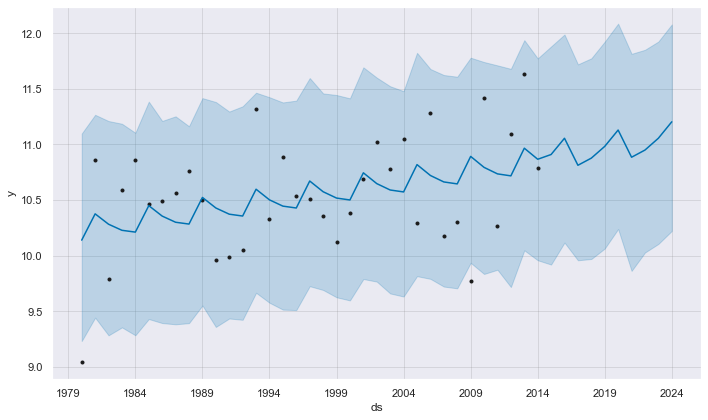

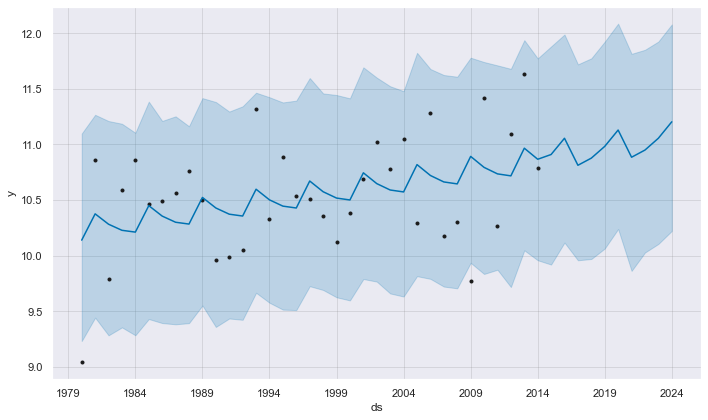

In [196]:
m.plot(forecast)

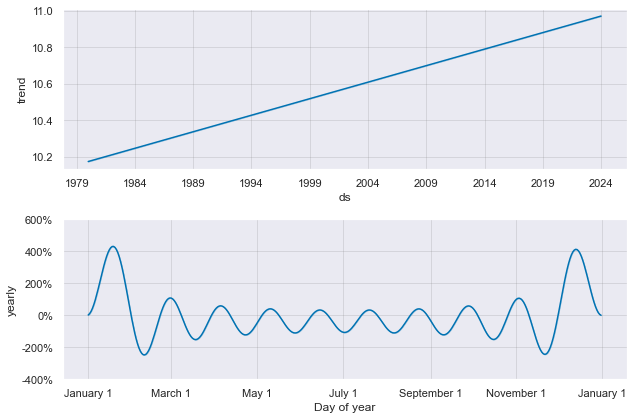

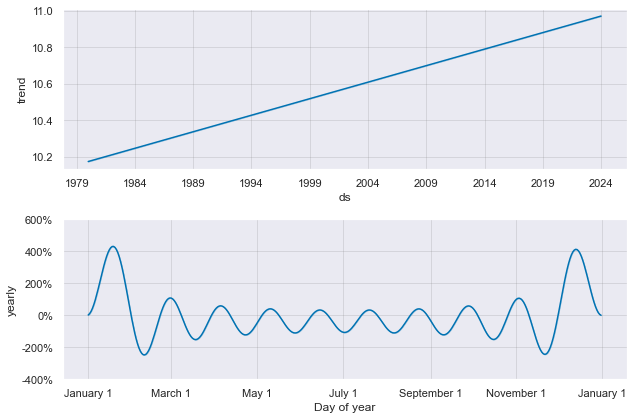

In [197]:
m.plot_components(forecast)

In [198]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted production and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2014-12-31')& (forecast['ds']<='2019-12-31')] #technically 2015 forecast
metrics
#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')
mse=mean_squared_error(np.exp(v1test.y),np.exp(metrics.yhat))
rmse=np.sqrt(mse)
print(rmse)


The Root Mean Squared Error is:
4355.553036838548


### Prophet Analysis: Forecasting Ventura W/ Regressors

In [199]:
#Prophet Analysis for Ventura Production
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Avg_Temp')
#fit the model to trainset
m.fit(v1train)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y')
future['Avg_Temp'] = v1['ds']

forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:00 - cmdstanpy - INFO - Chain [1] start processing
19:54:00 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
0   1980  2749.554961  2748.667422  2750.455730
1   1981  2756.109974  2755.170255  2756.995272
2   1982  2762.328136  2761.393172  2763.238205
3   1983  2768.584733  2767.615634  2769.569249
4   1984  2774.880049  2773.939423  2775.776423
5   1985  2781.456574  2780.536760  2782.357510
6   1986  2787.693866  2786.692662  2788.530125
7   1987  2793.969835  2793.108613  2794.872466
8   1988  2800.284765  2799.387145  2801.202511
9   1989  2806.882803  2805.896479  2807.763420
10  1990  2813.139225  2812.098198  2814.091521
11  1991  2819.434566  2818.512283  2820.249624
12  1992  2825.769111  2824.855165  2826.668605
13  1993  2832.388660  2831.457330  2833.282979
14  1994  2838.664213  2837.722522  2839.603160
15  1995  2844.978927  2844.127905  2845.884461
16  1996  2851.333086  2850.381139  2852.268017
17  1997  2857.974147  2857.073314  2858.924887
18  1998  2864.268830  2863.326639  2865.138952
19  1999  2870.602916  2869.712782  2871.500614
20  2000  2876.976689  2876.083261  2877.914793
21  2001  2883.639262  2882.731122  2884.555858
22  2002  2889.953076  2888.911349  2890.891451
23  2003  2896.306534  2895.415069  2897.318487
24  2004  2902.699922  2901.737719  2903.567492
25  2005  2909.384007  2908.420733  2910.267672
26  2006  2915.716951  2914.819427  2916.644998
27  2007  2922.089781  2921.180789  2923.028800
28  2008  2928.502784  2927.458255  2929.417203
29  2009  2935.208381  2934.313442  2936.092738
30  2010  2941.560455  2940.621253  2942.501253
31  2011  2947.952657  2946.972916  2948.828245
32  2012  2954.385274  2953.488717  2955.307909
33  2013  2961.112383  2960.139050  2962.011651
34  2014  2967.483588  2966.554043  2968.345667
35  2015  2973.927563  2972.966520  2974.770061
36  2016  2980.523469  2979.650735  2981.451848
37  2017  2986.840510  2985.946578  2987.737013
38  2018  2993.374673  2992.455839  2994.316602
39  2019  2999.949982  2999.030983  3000.869100
40  2020  3006.566471  3005.643306  3007.480798

In [200]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted production and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(np.exp(v1test.y),np.exp(metrics.yhat,dtype=np.float128))
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)


The Root Mean Squared Error is:
2.218975890233986158e+1305


In [201]:
#Prophet Analysis for Ventura Production w/ Precipitation Regress
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Avg_Prec')
#fit the model to trainset
m.fit(v1train)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y')
future['Avg_Prec'] = v1['ds']

forecast = m.predict(future)
forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:01 - cmdstanpy - INFO - Chain [1] start processing
19:54:01 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat  yhat_lower  yhat_upper
0   1980 -248.822230 -249.733218 -247.832556
1   1981 -249.185390 -250.059050 -248.237580
2   1982 -249.874356 -250.809388 -248.923097
3   1983 -250.526978 -251.488636 -249.644789
4   1984 -251.142957 -252.066756 -250.232905
5   1985 -251.506442 -252.478443 -250.575729
6   1986 -252.198081 -253.115591 -251.223570
7   1987 -252.853110 -253.773092 -251.930172
8   1988 -253.471227 -254.402416 -252.520449
9   1989 -253.835036 -254.786499 -252.871589
10  1990 -254.529348 -255.393344 -253.584459
11  1991 -255.186783 -256.070438 -254.300049
12  1992 -255.807040 -256.772932 -254.832021
13  1993 -256.171174 -257.134926 -255.246320
14  1994 -256.868159 -257.800684 -255.957091
15  1995 -257.528000 -258.412251 -256.665451
16  1996 -258.150396 -259.048253 -257.253580
17  1997 -258.514854 -259.387770 -257.604609
18  1998 -259.214512 -260.120465 -258.312956
19  1999 -259.876760 -260.804346 -258.877066
20  2000 -260.501295 -261.359343 -259.536117
21  2001 -260.866077 -261.838628 -259.994548
22  2002 -261.568408 -262.474364 -260.681171
23  2003 -262.233063 -263.107936 -261.296204
24  2004 -262.859736 -263.730929 -261.947305
25  2005 -263.224843 -264.156098 -262.269383
26  2006 -263.929848 -264.819362 -262.968424
27  2007 -264.596909 -265.564850 -263.681943
28  2008 -265.225794 -266.135997 -264.247522
29  2009 -265.591298 -266.549330 -264.661420
30  2010 -266.299049 -267.185565 -265.350278
31  2011 -266.968590 -267.916580 -266.022600
32  2012 -267.599615 -268.480042 -266.720490
33  2013 -267.965444 -268.878483 -267.023817
34  2014 -268.675868 -269.603262 -267.737708
35  2015 -269.259571 -270.196613 -268.285717
36  2016 -269.734859 -270.673222 -268.800261
37  2017 -270.575123 -271.513729 -269.618921
38  2018 -271.130078 -271.964072 -270.126354
39  2019 -271.645748 -272.545244 -270.665736
40  2020 -272.122107 -273.058691 -271.219974

In [202]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted production and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(v1test.y,metrics.yhat)
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
281.70001923490577


### Prophet Analysis: Forecasting Baseline Production in San Bernardino

In [203]:
SB=SanBern
SB = SB.rename(columns={'Year':'ds','Production': 'y',})
SB['ds'] = pd.to_datetime(SB['ds'],format='%Y').dt.strftime('%Y')
SB=SB.reset_index()

In [204]:
#Getting years 1980-2014 for train set & 2015-2020 for test set
SBtrain=SB.loc[(SB['ds'] < '2015')]
SBtrain.reset_index(drop=True)
SBtest=SB.loc[(SB['ds']>='2015')]
SBtest.reset_index(drop=True)

index    ds  CountyCode  HarvestedAcres  Yield         y  PriceP/U  \
0    244  2015          71        6.224558   3.21  7.390181   1266.05   
1    242  2016          71        6.224558   3.09  7.352441   1360.26   
2    240  2017          71        6.167516   3.08  7.293018   2349.66   
3    238  2018          71        6.124683   3.85  7.473069   2379.55   
4    236  2019          71        5.983936   3.53  7.244228   2604.29   
5    234  2020          71        5.913503   2.16  6.683361   2617.02   

       Value  Avg_Temp Avg_Prec  Fire_Count  
0  2051000.0  4.231204     0.02    5.733341  
1  2122000.0  4.228293     0.03    5.855072  
2  3454000.0  4.225373     0.02    6.408529  
3  4188000.0  4.216562     0.02    6.016157  
4  3646000.0  4.185099     0.04    5.743003  
5  2091000.0  4.218036     0.02    6.212606

In [205]:
#Prophet Analysis
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
#fit the model to each zipcode (group)
m.fit(SBtrain)
#makes df
future = m.make_future_dataframe(periods=10,freq ='Y')
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:01 - cmdstanpy - INFO - Chain [1] start processing
19:54:01 - cmdstanpy - INFO - Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper
0  1980-01-01  5.870581    4.763661    6.862415
1  1981-01-01  5.962693    4.934754    7.046549
2  1982-01-01  5.965154    4.937925    7.032685
3  1983-01-01  5.976822    4.977772    7.090225
4  1984-01-01  5.997878    4.890430    7.062101
5  1985-01-01  6.091288    5.013054    7.123650
6  1986-01-01  6.093113    5.021845    7.167086
7  1987-01-01  6.104348    5.054142    7.179419
8  1988-01-01  6.125174    5.156927    7.135948
9  1989-01-01  6.219883    5.157991    7.329528
10 1990-01-01  6.221071    5.155023    7.252861
11 1991-01-01  6.231874    5.163460    7.248574
12 1992-01-01  6.252471    5.254235    7.320288
13 1993-01-01  6.348479    5.345417    7.376378
14 1994-01-01  6.349030    5.286597    7.427803
15 1995-01-01  6.359399    5.256842    7.410489
16 1996-01-01  6.379767    5.267987    7.475895
17 1997-01-01  6.477074    5.386763    7.582660
18 1998-01-01  6.476987    5.400926    7.524283
19 1999-01-01  6.486856    5.427783    7.517770
20 2000-01-01  6.506928    5.484260    7.578842
21 2001-01-01  6.605464    5.483742    7.726052
22 2002-01-01  6.604634    5.553509    7.625324
23 2003-01-01  6.614023    5.594300    7.688827
24 2004-01-01  6.633818    5.502709    7.727604
25 2005-01-01  6.733596    5.641400    7.763978
26 2006-01-01  6.732123    5.724500    7.756438
27 2007-01-01  6.741075    5.637927    7.874396
28 2008-01-01  6.760637    5.757369    7.824328
29 2009-01-01  6.861709    5.791013    7.980699
30 2010-01-01  6.859602    5.770219    7.898932
31 2011-01-01  6.868123    5.823397    7.951796
32 2012-01-01  6.887457    5.798261    7.945723
33 2013-01-01  6.989822    5.941353    8.014132
34 2014-01-01  6.987081    5.959128    8.032087
35 2014-12-31  7.011855    5.899638    8.035584
36 2015-12-31  7.075855    5.986340    8.119089
37 2016-12-31  7.044559    5.900515    8.216116
38 2017-12-31  7.086163    5.965727    8.184013
39 2018-12-31  7.139207    6.006298    8.165697
40 2019-12-31  7.203789    6.153333    8.189178
41 2020-12-31  7.171353    6.117807    8.272903
42 2021-12-31  7.213135    6.128542    8.225889
43 2022-12-31  7.266560    6.228650    8.415231
44 2023-12-31  7.331723    6.276815    8.479708

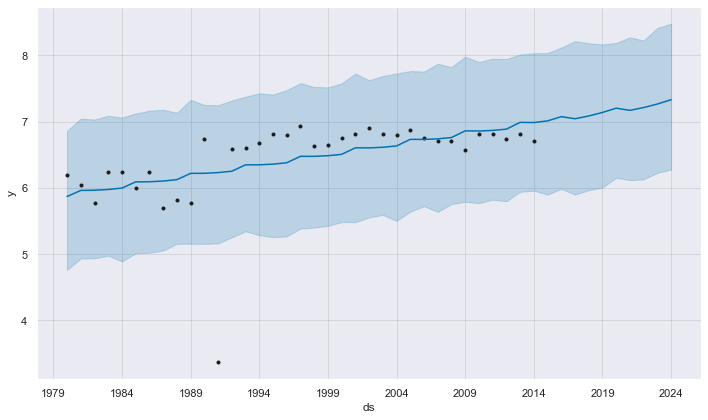

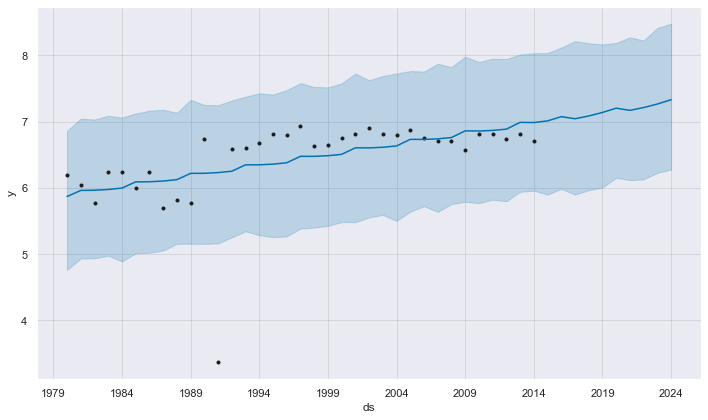

In [206]:
m.plot(forecast)

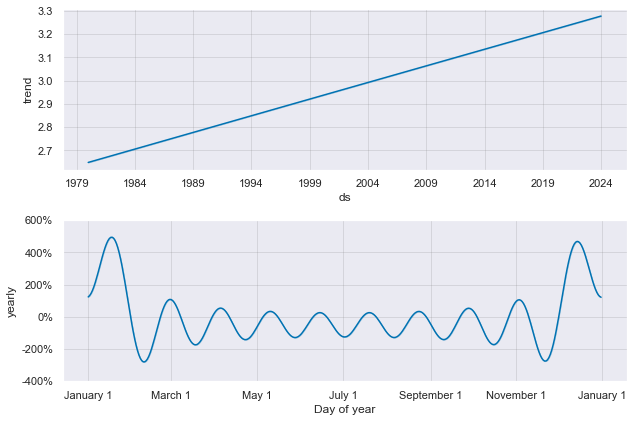

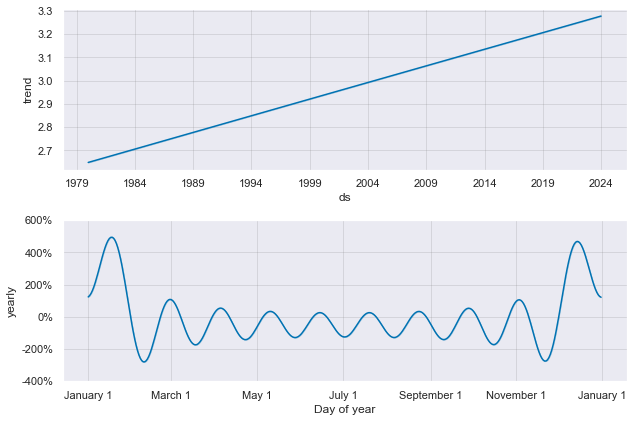

In [207]:
m.plot_components(forecast)

In [208]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted price and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2014-12-31')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(np.exp(SBtest.y),np.exp(metrics.yhat,dtype=np.float128))
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
436.46430571072700194


### Prophet Analysis: Forecasting San Bernardino W/ Regressors

In [209]:
#Prophet Analysis for San Bernardino Production
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Avg_Temp')

#fit the model to trainset
m.fit(SBtrain)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y')
future['Avg_Temp'] = SB['ds']

forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:03 - cmdstanpy - INFO - Chain [1] start processing
19:54:04 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
0   1980  1308.086214  1307.016988  1309.222797
1   1981  1315.607442  1314.480089  1316.801216
2   1982  1323.010346  1321.911551  1324.058567
3   1983  1330.433201  1329.304967  1331.484673
4   1984  1337.876246  1336.863975  1338.976213
5   1985  1345.426253  1344.347724  1346.537659
6   1986  1352.855698  1351.737635  1353.839649
7   1987  1360.305370  1359.152237  1361.362523
8   1988  1367.775509  1366.727784  1368.833044
9   1989  1375.354294  1374.132578  1376.401896
10  1990  1382.810281  1381.752077  1383.800439
11  1991  1390.286770  1389.192210  1391.446519
12  1992  1397.784002  1396.724171  1398.883292
13  1993  1405.391567  1404.347038  1406.439293
14  1994  1412.874095  1411.763311  1413.907576
15  1995  1420.377401  1419.327486  1421.492300
16  1996  1427.901725  1426.834063  1428.972634
17  1997  1435.538070  1434.485045  1436.626735
18  1998  1443.047139  1441.924847  1444.086438
19  1999  1450.577262  1449.518898  1451.706723
20  2000  1458.128679  1457.015599  1459.129535
21  2001  1465.793803  1464.716142  1466.878142
22  2002  1473.327402  1472.247616  1474.365735
23  2003  1480.882329  1479.796583  1481.988191
24  2004  1488.458825  1487.416401  1489.533069
25  2005  1496.150704  1495.104551  1497.207942
26  2006  1503.710837  1502.670801  1504.736303
27  2007  1511.292572  1510.232826  1512.427955
28  2008  1518.896153  1517.796650  1519.965117
29  2009  1526.616803  1525.612283  1527.633511
30  2010  1534.203470  1533.070001  1535.211551
31  2011  1541.812014  1540.696647  1542.934369
32  2012  1549.442680  1548.408010  1550.643916
33  2013  1557.192101  1556.112820  1558.223621
34  2014  1564.805301  1563.822108  1565.863144
35  2015  1572.469421  1571.357031  1573.589894
36  2016  1580.190441  1579.094792  1581.287214
37  2017  1587.778770  1586.753461  1588.890698
38  2018  1595.481935  1594.416145  1596.554807
39  2019  1603.208058  1602.123152  1604.311220
40  2020  1610.957263  1609.854877  1612.080117

In [210]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted production and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(np.exp(SBtest.y),np.exp(metrics.yhat,dtype=np.float128))
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
1.740902406534556572e+699


In [211]:
#Prophet Analysis for San Bernardino Production
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)

m.add_regressor(name='Avg_Prec')
#fit the model to trainset
m.fit(SBtrain)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y')

future['Avg_Prec'] = SB['ds']
forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:04 - cmdstanpy - INFO - Chain [1] start processing
19:54:04 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
0   1980   8731.299705   8730.234844   8732.401789
1   1981   8786.779516   8785.713007   8787.886133
2   1982   8842.062565   8840.993524   8843.176579
3   1983   8897.408956   8896.315795   8898.486296
4   1984   8952.818935   8951.789020   8953.871334
5   1985   9008.506039   9007.458964   9009.733697
6   1986   9063.993574   9062.935059   9065.108480
7   1987   9119.544736   9118.505658   9120.605443
8   1988   9175.159773   9174.108565   9176.193501
9   1989   9231.054170   9229.984665   9232.126145
10  1990   9286.746190   9285.596248   9287.849267
11  1991   9342.502124   9341.448845   9343.594010
12  1992   9398.322219   9397.297367   9399.378824
13  1993   9454.423909   9453.337240   9455.425095
14  1994   9510.320417   9509.307120   9511.278987
15  1995   9566.281123   9565.235071   9567.441176
16  1996   9622.306275   9621.206990   9623.496582
17  1997   9678.615258   9677.483010   9679.651436
18  1998   9734.703112   9733.641845   9735.830257
19  1999   9790.802375   9789.668838   9791.912773
20  2000   9846.877799   9845.818114   9848.003413
21  2001   9903.238708   9902.155934   9904.370045
22  2002   9959.314858   9958.278622   9960.435978
23  2003  10015.423496  10014.313697  10016.561041
24  2004  10071.596882  10070.575374  10072.722118
25  2005  10128.057580  10127.079814  10129.088899
26  2006  10184.305147  10183.244285  10185.369582
27  2007  10240.617504  10239.564910  10241.745227
28  2008  10296.994902  10295.941327  10298.116443
29  2009  10353.661839  10352.597678  10354.684824
30  2010  10410.112850  10409.005035  10411.264551
31  2011  10466.628938  10465.566111  10467.708405
32  2012  10523.210351  10522.140235  10524.271680
33  2013  10580.083527  10579.054611  10581.255133
34  2014  10636.737986  10635.730127  10637.889787
35  2015  10693.348653  10692.357214  10694.401182
36  2016  10750.193337  10749.077801  10751.254124
37  2017  10807.094496  10806.029274  10808.207053
38  2018  10864.011791  10863.016630  10865.140056
39  2019  10920.995285  10919.970647  10922.082318
40  2020  10978.045119  10976.946193  10979.182842

In [212]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted production and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(SBtest.y,metrics.yhat)
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.around(np.sqrt(mse),5)
print(rmse)

The Root Mean Squared Error is:
10828.81361


### Prophet Analysis: Forecasting Baseline Production in Santa Barbara

In [213]:
SBRB=SanBarb
SBRB = SBRB.rename(columns={'Year':'ds','Production': 'y',})
SBRB['ds'] = pd.to_datetime(SBRB['ds'],format='%Y').dt.strftime('%Y')
SBRB=SBRB.reset_index()

In [214]:
#Getting years 1980-2014 for train set & 2015-2020 for test set
SBRBtrain=SBRB.loc[(SBRB['ds'] < '2015')]
SBRBtrain.reset_index(drop=True)
SBRBtest=SBRB.loc[(SBRB['ds']>='2015')]
SBRBtest.reset_index(drop=True)

index    ds  CountyCode  HarvestedAcres  Yield          y  PriceP/U  \
0     21  2015          83        8.781095   3.59  10.060491   2004.32   
1     18  2016          83        8.513185   4.94  10.110502   2580.61   
2     15  2017          83        8.359369   2.46   9.259131   3676.76   
3     12  2018          83        8.503094   4.56  10.021271   2338.53   
4      9  2019          83        8.596004   1.98   9.277999   3309.44   
5      6  2020          83        8.660427   4.89  10.247077   2842.59   

        Value  Avg_Temp Avg_Prec  Fire_Count  
0  46901000.0  4.225373     0.01    5.733341  
1  63483000.0  4.198705     0.02    5.855072  
2  38606000.0  4.203199     0.04    6.408529  
3  52617000.0  4.206184     0.02    6.016157  
4  35411000.0  4.182050     0.06    5.743003  
5  80161000.0  4.186620     0.02    6.212606

In [215]:
#Prophet Analysis
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
#fit the model to each zipcode (group)
m.fit(SBRBtrain)
#makes df
future = m.make_future_dataframe(periods=10,freq ='Y')
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:05 - cmdstanpy - INFO - Chain [1] start processing
19:54:06 - cmdstanpy - INFO - Chain [1] done processing


ds       yhat  yhat_lower  yhat_upper
0  1980-01-01  10.445520    9.812645   11.092534
1  1981-01-01  10.487377    9.855020   11.119421
2  1982-01-01  10.390903    9.785117   11.024106
3  1983-01-01  10.286006    9.673732   10.924058
4  1984-01-01  10.172906    9.520506   10.839182
5  1985-01-01  10.211870    9.555131   10.858212
6  1986-01-01  10.116126    9.499798   10.743316
7  1987-01-01  10.012194    9.409844   10.662310
8  1988-01-01   9.900292    9.269931   10.534737
9  1989-01-01   9.936281    9.297126   10.553283
10 1990-01-01   9.841188    9.183028   10.486018
11 1991-01-01   9.738141    9.095764   10.371875
12 1992-01-01   9.687975    9.093935   10.346096
13 1993-01-01   9.783139    9.142933   10.437578
14 1994-01-01   9.749551    9.144496   10.381697
15 1995-01-01   9.707710    9.109978   10.324681
16 1996-01-01   9.657677    9.037205   10.274219
17 1997-01-01   9.752519    9.120619   10.359571
18 1998-01-01   9.719012    9.084038   10.322406
19 1999-01-01   9.677279    9.056892   10.258339
20 2000-01-01   9.666500    9.026213   10.282373
21 2001-01-01   9.801082    9.189648   10.405786
22 2002-01-01   9.806878    9.221893   10.416366
23 2003-01-01   9.804128    9.196478   10.398786
24 2004-01-01   9.792795    9.196213   10.387218
25 2005-01-01   9.928717    9.291938   10.578576
26 2006-01-01   9.934174    9.337021   10.562934
27 2007-01-01   9.930978    9.276136   10.541118
28 2008-01-01   9.938681    9.319330   10.565732
29 2009-01-01  10.096006    9.481054   10.733190
30 2010-01-01  10.120766    9.485655   10.758130
31 2011-01-01  10.136592    9.467480   10.756161
32 2012-01-01  10.143396    9.508150   10.715472
33 2013-01-01  10.302894    9.679492   10.909326
34 2014-01-01  10.327106    9.690911   10.936234
35 2014-12-31  10.108986    9.421924   10.719403
36 2015-12-31  10.079077    9.472656   10.728680
37 2016-12-31  10.344745    9.724747   10.969566
38 2017-12-31  10.332046    9.697427   10.936463
39 2018-12-31  10.309967    9.694299   10.933796
40 2019-12-31  10.278473    9.629408   10.920782
41 2020-12-31  10.548388    9.892212   11.191151
42 2021-12-31  10.534443    9.881687   11.169030
43 2022-12-31  10.510948    9.888847   11.116427
44 2023-12-31  10.477869    9.788180   11.131648

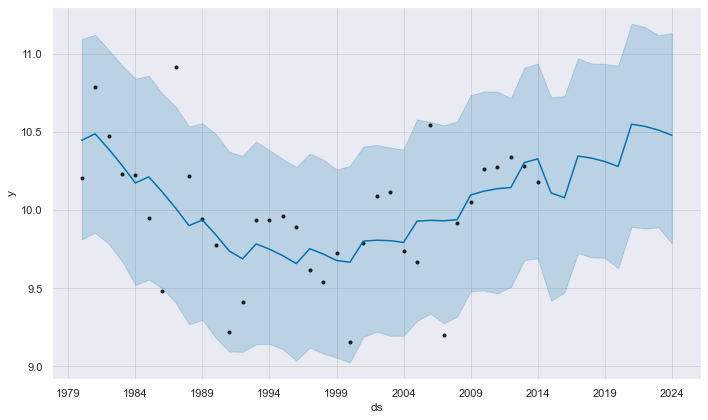

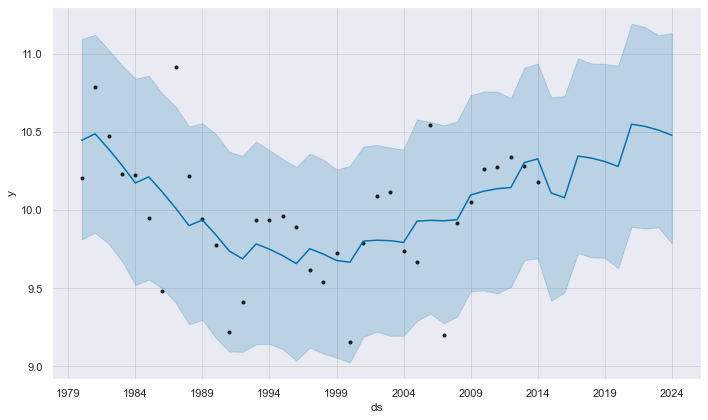

In [216]:
m.plot(forecast)

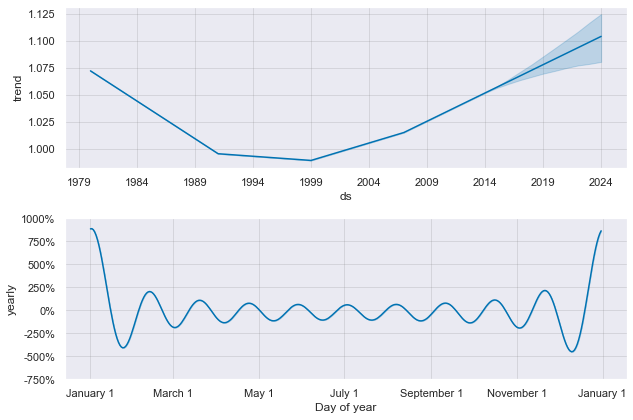

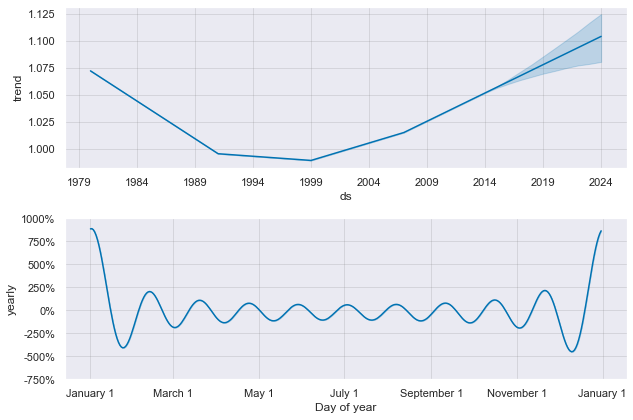

In [217]:
m.plot_components(forecast)

In [218]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted price and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2014-12-31')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(np.exp(SBRBtest.y),np.exp(metrics.yhat,dtype=np.float128))
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
12025.954987769957307


### Prophet Analysis: Forecasting Production in Santa Barbara w/ Regressors

In [219]:
#Prophet Analysis for VSanta Barbara Production w/ Temp Regressor
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Avg_Temp')

#fit the model to trainset
m.fit(SBRBtrain)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y') 
future['Avg_Temp'] = SBRB['ds']

forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:08 - cmdstanpy - INFO - Chain [1] start processing
19:54:09 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
0   1980 -9000.206104 -9000.823888 -8999.638275
1   1981 -8946.242083 -8946.852986 -8945.651723
2   1982 -8892.496249 -8893.103717 -8891.893092
3   1983 -8838.698921 -8839.352552 -8838.022020
4   1984 -8784.849910 -8785.464836 -8784.210405
5   1985 -8730.651843 -8731.251659 -8730.014315
6   1986 -8676.671207 -8677.322085 -8676.055150
7   1987 -8622.638872 -8623.263905 -8622.029938
8   1988 -8568.554646 -8569.151154 -8567.933589
9   1989 -8513.966490 -8514.607094 -8513.365034
10  1990 -8459.591328 -8460.208180 -8458.918243
11  1991 -8405.164096 -8405.823055 -8404.527958
12  1992 -8400.766484 -8401.420942 -8400.126560
13  1993 -8396.212212 -8396.786868 -8395.643383
14  1994 -8391.782344 -8392.428888 -8391.177177
15  1995 -8387.323478 -8387.931504 -8386.713917
16  1996 -8382.474767 -8383.080353 -8381.858218
17  1997 -8377.286303 -8377.911698 -8376.695984
18  1998 -8372.222868 -8372.832647 -8371.601090
19  1999 -8367.157405 -8367.753055 -8366.523492
20  2000 -8392.654447 -8393.234985 -8392.052177
21  2001 -8418.107374 -8418.761456 -8417.493419
22  2002 -8443.674997 -8444.292076 -8443.043895
23  2003 -8469.271528 -8469.867880 -8468.702400
24  2004 -8494.896987 -8495.525568 -8494.284174
25  2005 -8520.477350 -8521.065060 -8519.872040
26  2006 -8546.130707 -8546.785534 -8545.481451
27  2007 -8571.813050 -8572.387998 -8571.221713
28  2008 -8639.432102 -8640.017122 -8638.819568
29  2009 -8707.160801 -8707.758390 -8706.507238
30  2010 -8774.891299 -8775.540698 -8774.252875
31  2011 -8842.693097 -8843.337043 -8842.089967
32  2012 -8910.566325 -8911.213453 -8909.920571
33  2013 -8978.545831 -8979.188582 -8977.933520
34  2014 -9046.530063 -9047.137419 -9045.926814
35  2015 -9114.615708 -9121.023400 -9107.508320
36  2016 -9182.775716 -9201.898092 -9160.618662
37  2017 -9250.912393 -9287.872551 -9211.776261
38  2018 -9319.183436 -9377.555264 -9259.296170
39  2019 -9387.526442 -9467.837290 -9305.287663
40  2020 -9455.941493 -9563.507447 -9352.847926

In [220]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted price and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(np.exp(SBRBtest.y),np.exp(metrics.yhat,dtype=np.float128))
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
21130.349421310256472


In [221]:
#Prophet Analysis for Santa Barbara Production w/ Precipitation Regressor
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Avg_Prec')
#fit the model to trainset
m.fit(SBRBtrain)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y')
future['Avg_Prec'] = SBRB['ds']
forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:10 - cmdstanpy - INFO - Chain [1] start processing
19:54:14 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
0   1980 -4439.140127 -4439.768677 -4438.506205
1   1981 -4410.966463 -4411.553101 -4410.319621
2   1982 -4382.969105 -4383.614180 -4382.389304
3   1983 -4354.949203 -4355.582397 -4354.323878
4   1984 -4326.906543 -4327.495848 -4326.232937
5   1985 -4298.612983 -4299.239663 -4297.983840
6   1986 -4270.492504 -4271.131172 -4269.855096
7   1987 -4242.349248 -4242.954730 -4241.708659
8   1988 -4214.183003 -4214.784631 -4213.547031
9   1989 -4185.724638 -4186.368186 -4185.063342
10  1990 -4157.436207 -4158.037642 -4156.825693
11  1991 -4129.124718 -4129.759684 -4128.487002
12  1992 -4129.434180 -4130.069520 -4128.797988
13  1993 -4129.606022 -4130.265224 -4128.995343
14  1994 -4129.896038 -4130.537485 -4129.268351
15  1995 -4130.161185 -4130.783920 -4129.513775
16  1996 -4130.210779 -4130.830912 -4129.597127
17  1997 -4130.122036 -4130.712427 -4129.475837
18  1998 -4130.151703 -4130.765376 -4129.512629
19  1999 -4130.187171 -4130.800901 -4129.554965
20  2000 -4144.752537 -4145.398185 -4144.143255
21  2001 -4159.233542 -4159.836903 -4158.540350
22  2002 -4173.808068 -4174.425355 -4173.172368
23  2003 -4188.403209 -4189.044278 -4187.778330
24  2004 -4203.018997 -4203.675119 -4202.446810
25  2005 -4217.548918 -4218.180660 -4216.955996
26  2006 -4232.173676 -4232.786817 -4231.534837
27  2007 -4246.819143 -4247.425788 -4246.238677
28  2008 -4270.750049 -4271.373990 -4270.134073
29  2009 -4294.627816 -4295.218422 -4294.032587
30  2010 -4318.585959 -4319.221986 -4317.986969
31  2011 -4342.574329 -4343.188131 -4341.968194
32  2012 -4366.593012 -4367.191758 -4366.026764
33  2013 -4390.555935 -4391.207858 -4389.943262
34  2014 -4414.601524 -4415.159688 -4414.014776
35  2015 -4438.831606 -4441.839650 -4436.054422
36  2016 -4462.972150 -4471.398153 -4454.055772
37  2017 -4486.920975 -4503.137203 -4472.195544
38  2018 -4511.088594 -4536.349620 -4488.840362
39  2019 -4535.286870 -4569.888640 -4502.548852
40  2020 -4559.515840 -4603.421230 -4517.145287

In [222]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted price and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(SBRBtest.y,metrics.yhat)
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
4509.120058646632


### Prophet Analysis: Forecasting Baseline Production in San Luis Obispo

In [223]:
SLO=SanLO
SLO = SLO.rename(columns={'Year':'ds','Production': 'y',})
SLO['ds'] = pd.to_datetime(SLO['ds'],format='%Y').dt.strftime('%Y')
SLO=SLO.reset_index()

In [224]:
#Getting years 1980-2014 for train set & 2015-2020 for test set
SLOtrain=SLO.loc[(SLO['ds'] < '2015')]
SLOtrain.reset_index(drop=True)
SLOtest=SLO.loc[(SLO['ds']>='2015')]
SLOtest.reset_index(drop=True)

index    ds  CountyCode  HarvestedAcres  Yield          y  PriceP/U  \
0     20  2015          79        8.321178   2.21   9.112728   1831.64   
1     17  2016          79        8.296547   4.96   9.898475   2242.61   
2     14  2017          79        8.313852   2.35   9.166388   2852.14   
3     11  2018          79        8.333270   4.62   9.862666   2403.39   
4      8  2019          79        8.398410   2.75   9.409191   3186.48   
5      5  2020          79        8.352319   5.90  10.126631   1886.76   

        Value  Avg_Temp Avg_Prec  Fire_Count  
0  16613000.0  4.225373     0.01    5.733341  
1  44628000.0  4.198705     0.02    5.855072  
2  27295000.0  4.203199     0.04    6.408529  
3  46145000.0  4.206184     0.02    6.016157  
4  38875000.0  4.182050     0.06    5.743003  
5  47169000.0  4.186620     0.02    6.212606

In [225]:
#Prophet Analysis
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
#fit the model to each zipcode (group)
m.fit(SLOtrain)
#makes df
future = m.make_future_dataframe(periods=10,freq ='Y')
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:15 - cmdstanpy - INFO - Chain [1] start processing
19:54:15 - cmdstanpy - INFO - Chain [1] done processing


ds      yhat  yhat_lower  yhat_upper
0  1980-01-01  6.696821    5.387545    7.964970
1  1981-01-01  7.252941    6.054456    8.488595
2  1982-01-01  7.180786    5.953171    8.390415
3  1983-01-01  7.087066    5.855638    8.380529
4  1984-01-01  6.971448    5.768634    8.386618
5  1985-01-01  7.547348    6.346056    8.744749
6  1986-01-01  7.469338    6.140125    8.713247
7  1987-01-01  7.369022    6.168829    8.668874
8  1988-01-01  7.246074    5.980717    8.520837
9  1989-01-01  7.841756    6.569044    8.982529
10 1990-01-01  7.757891    6.444842    9.014779
11 1991-01-01  7.650978    6.488279    8.848584
12 1992-01-01  7.520701    6.273021    8.718524
13 1993-01-01  8.136164    6.797359    9.348476
14 1994-01-01  8.046443    6.798385    9.317654
15 1995-01-01  7.932934    6.658413    9.188249
16 1996-01-01  7.795327    6.572632    9.027966
17 1997-01-01  8.430571    7.212874    9.646529
18 1998-01-01  8.334996    7.137795    9.566638
19 1999-01-01  8.214890    7.000008    9.571883
20 2000-01-01  8.069954    6.847675    9.316106
21 2001-01-01  8.724979    7.505528   10.043282
22 2002-01-01  8.623549    7.381237    9.867048
23 2003-01-01  8.496846    7.260020    9.815133
24 2004-01-01  8.344580    7.076732    9.567457
25 2005-01-01  9.019387    7.777801   10.341518
26 2006-01-01  8.912101    7.692109   10.120266
27 2007-01-01  8.778802    7.548817   10.056976
28 2008-01-01  8.619207    7.399964    9.959079
29 2009-01-01  9.313794    8.069631   10.636849
30 2010-01-01  9.200654    7.987288   10.368819
31 2011-01-01  9.060758    7.832324   10.405494
32 2012-01-01  8.893833    7.616885   10.179179
33 2013-01-01  9.608202    8.284369   10.859606
34 2014-01-01  9.489206    8.261650   10.715067
35 2014-12-31  8.228932    6.958682    9.499084
36 2015-12-31  7.952202    6.830692    9.181015
37 2016-12-31  8.966233    7.826588   10.209748
38 2017-12-31  8.735874    7.513320   10.009760
39 2018-12-31  8.477280    7.296552    9.788740
40 2019-12-31  8.190402    6.923585    9.478571
41 2020-12-31  9.232807    8.019517   10.511294
42 2021-12-31  8.993685    7.750842   10.290368
43 2022-12-31  8.725628    7.596439   10.024499
44 2023-12-31  8.428602    7.232461    9.702197

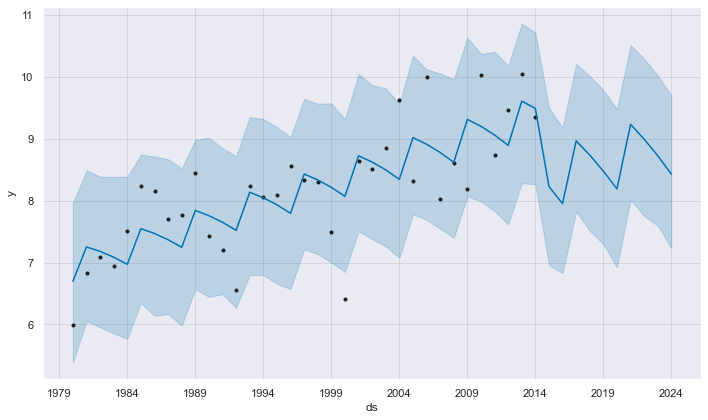

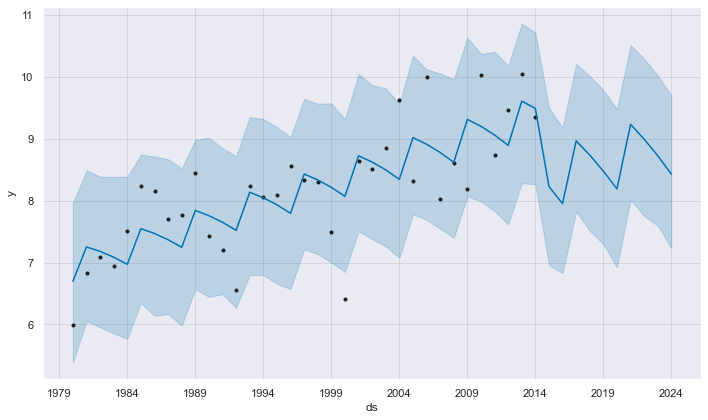

In [226]:
m.plot(forecast)

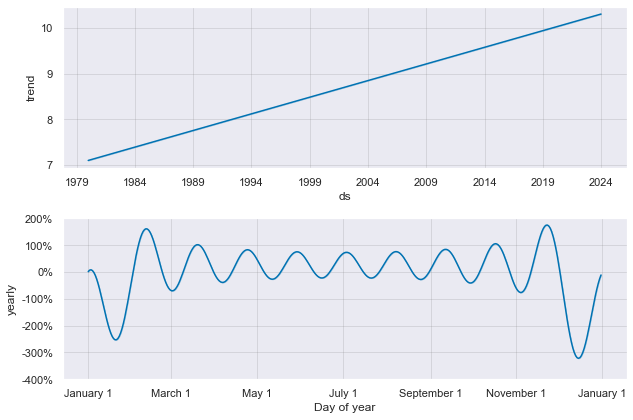

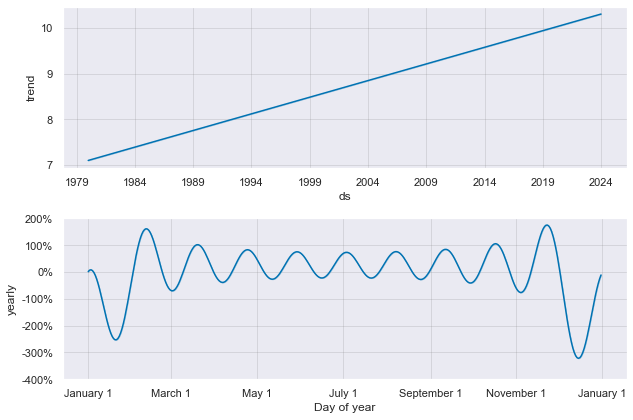

In [227]:
m.plot_components(forecast)

In [228]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted price and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2014-12-31')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(np.exp(SLOtest.y),np.exp(metrics.yhat,dtype=np.float128))
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
12930.16964070125699


### Prophet Analysis: Forecasting Production in San Luis Obispo w/ Regressors

In [229]:
#Prophet Analysis for San Luis Obispo Production w/ Temp regress
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Avg_Temp')

#fit the model to trainset
m.fit(SLOtrain)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y')
future['Avg_Temp'] = SLO['ds']

forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:17 - cmdstanpy - INFO - Chain [1] start processing
19:54:17 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
0   1980  -7372.638827  -7373.801839  -7371.485547
1   1981  -7451.062691  -7452.303574  -7449.756254
2   1982  -7529.982570  -7531.239491  -7528.723941
3   1983  -7608.992067  -7610.251832  -7607.688325
4   1984  -7688.091281  -7689.434463  -7686.841993
5   1985  -7766.800007  -7767.970405  -7765.595612
6   1986  -7846.029646  -7847.365614  -7844.838437
7   1987  -7925.349328  -7926.654372  -7924.086528
8   1988  -8004.759140  -8006.199914  -8003.484167
9   1989  -8083.752726  -8085.105495  -8082.535101
10  1990  -8163.292127  -8164.520516  -8162.104188
11  1991  -8242.921993  -8244.215616  -8241.648690
12  1992  -8322.642403  -8323.965673  -8321.365887
13  1993  -8401.920850  -8403.149858  -8400.660938
14  1994  -8481.770012  -8483.063840  -8480.551994
15  1995  -8561.710060  -8562.852441  -8560.464483
16  1996  -8641.741068  -8642.970956  -8640.404312
17  1997  -8721.304375  -8722.590243  -8720.036453
18  1998  -8801.463298  -8802.725514  -8800.240476
19  1999  -8881.713531  -8882.884726  -8880.440910
20  2000  -8962.055137  -8963.334360  -8960.762380
21  2001  -9041.903307  -9043.032711  -9040.618261
22  2002  -9122.371992  -9123.618379  -9121.109564
23  2003  -9202.932409  -9204.160603  -9201.648293
24  2004  -9283.584613  -9284.839951  -9282.434601
25  2005  -9363.717645  -9365.039257  -9362.538845
26  2006  -9444.496092  -9445.782462  -9443.278017
27  2007  -9525.366694  -9526.659937  -9524.132414
28  2008  -9606.329496  -9607.722652  -9605.106945
29  2009  -9686.747389  -9688.035035  -9685.579094
30  2010  -9767.835598  -9769.034067  -9766.608437
31  2011  -9849.016383  -9850.193015  -9847.752307
32  2012  -9930.289783  -9931.529522  -9929.009841
33  2013 -10010.992537 -10012.205185 -10009.773460
34  2014 -10092.390507 -10093.549116 -10091.148024
35  2015 -10174.665557 -10175.947531 -10173.369031
36  2016 -10256.309135 -10257.613030 -10255.084400
37  2017 -10337.142496 -10338.464610 -10335.953680
38  2018 -10418.912505 -10420.131342 -10417.508468
39  2019 -10500.775428 -10502.005684 -10499.452159
40  2020 -10582.731159 -10583.975519 -10581.506990

In [230]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted production and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(np.exp(SLOtest.y),np.exp(metrics.yhat,dtype=np.float128))
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
16893.488883787940734


In [231]:
#Prophet Analysis for San Luis Obispo Production w/ Precipitation Regressor
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Avg_Prec')

#fit the model to trainset
m.fit(SLOtrain)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y')
future['Avg_Prec'] = SLO['ds']

forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:17 - cmdstanpy - INFO - Chain [1] start processing
19:54:18 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
0   1980  1005.517193  1004.324776  1006.776114
1   1981  1016.875540  1015.661123  1018.107202
2   1982  1027.585288  1026.306070  1028.858239
3   1983  1038.284279  1037.001020  1039.481816
4   1984  1048.972192  1047.803962  1050.233576
5   1985  1060.391978  1059.163235  1061.650503
6   1986  1071.137293  1069.807958  1072.337922
7   1987  1081.871127  1080.636722  1083.157766
8   1988  1092.593167  1091.409537  1093.858652
9   1989  1104.074393  1102.851371  1105.321156
10  1990  1114.855276  1113.552059  1116.163810
11  1991  1125.623953  1124.368757  1126.861555
12  1992  1136.380120  1135.129613  1137.629863
13  1993  1147.922786  1146.711956  1149.140311
14  1994  1158.739237  1157.516283  1159.907461
15  1995  1169.542757  1168.391659  1170.834898
16  1996  1180.333050  1179.127059  1181.587514
17  1997  1191.937156  1190.711548  1193.246116
18  1998  1202.789175  1201.584114  1204.105227
19  1999  1213.627538  1212.324296  1214.788706
20  2000  1224.451959  1223.237008  1225.670930
21  2001  1236.117504  1234.882045  1237.405233
22  2002  1247.005091  1245.736637  1248.146810
23  2003  1257.878297  1256.553154  1259.085089
24  2004  1268.736845  1267.460599  1269.980526
25  2005  1280.463830  1279.215531  1281.720895
26  2006  1291.386985  1290.147459  1292.649312
27  2007  1302.295034  1301.004480  1303.541140
28  2008  1313.187709  1311.936024  1314.529283
29  2009  1324.976134  1323.762381  1326.243796
30  2010  1335.934857  1334.805858  1337.132132
31  2011  1346.877749  1345.583250  1348.120496
32  2012  1357.804551  1356.559359  1359.045417
33  2013  1369.654416  1368.414461  1370.897974
34  2014  1380.648707  1379.398847  1381.908356
35  2015  1390.486570  1389.239954  1391.677300
36  2016  1401.347428  1400.128593  1402.668815
37  2017  1413.531293  1412.218510  1414.742362
38  2018  1424.458061  1423.212178  1425.748911
39  2019  1435.367581  1434.145212  1436.690963
40  2020  1446.259814  1444.990790  1447.626002

In [232]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted production and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(SLOtest.y,metrics.yhat)
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
1409.1061379450937


### Prophet Analysis: Forecasting Baseline Production in San Diego

In [233]:
sd=SanDie
sd = sd.rename(columns={'Year':'ds','Production': 'y',})
sd['ds'] = pd.to_datetime(sd['ds'],format='%Y').dt.strftime('%Y')
sd=sd.reset_index()

In [234]:
#Getting years 1980-2014 for train set & 2015-2020 for test set
sdtrain=sd.loc[(sd['ds'] < '2015')]
sdtrain.reset_index(drop=True)
sdtest=sd.loc[(sd['ds']>='2015')]
sdtest.reset_index(drop=True)

index    ds  CountyCode  HarvestedAcres  Yield          y  PriceP/U  \
0    320  2015          73        9.814656   2.34  10.666627   2574.69   
1    319  2016          73        9.781320   3.28  10.968198   2348.72   
2    318  2017          73        9.615805   2.30  10.448715   3541.74   
3    317  2018          73        9.781320   2.66  10.760028   2569.81   
4    316  2019          73        9.609116   2.38  10.474467   3958.08   
5    315  2020          73        9.574983   3.51  10.829729   3028.87   

         Value  Avg_Temp Avg_Prec  Fire_Count  
0  110454000.0  4.212128     0.03    5.733341  
1  136226000.0  4.194190     0.03    5.855072  
2  122190000.0  4.191169     0.02    6.408529  
3  121038000.0  4.194190     0.02    6.016157  
4  140116000.0  4.165114     0.04    5.743003  
5  152958000.0  4.189655     0.02    6.212606

In [235]:
#Prophet Analysis
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
#fit the model to each zipcode (group)
m.fit(sdtrain)
#makes df
future = m.make_future_dataframe(periods=10,freq ='Y')
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:18 - cmdstanpy - INFO - Chain [1] start processing
19:54:20 - cmdstanpy - INFO - Chain [1] done processing


ds       yhat  yhat_lower  yhat_upper
0  1980-01-01  10.821796   10.600086   11.043469
1  1981-01-01  11.294259   11.085388   11.516087
2  1982-01-01  11.779655   11.569058   12.005670
3  1983-01-01  11.873911   11.647989   12.092373
4  1984-01-01  11.960030   11.761021   12.190176
5  1985-01-01  11.819324   11.593056   12.022196
6  1986-01-01  11.845411   11.631767   12.075270
7  1987-01-01  11.683294   11.472527   11.891673
8  1988-01-01  11.512466   11.294366   11.726136
9  1989-01-01  11.270325   11.067288   11.502626
10 1990-01-01  10.938349   10.711036   11.142868
11 1991-01-01  11.203468   10.989690   11.421630
12 1992-01-01  11.271689   11.059736   11.492315
13 1993-01-01  11.709138   11.495887   11.917239
14 1994-01-01  11.160648   10.966110   11.375258
15 1995-01-01  11.038971   10.822459   11.241262
16 1996-01-01  11.154664   10.936796   11.374419
17 1997-01-01  11.084646   10.872987   11.302817
18 1998-01-01  11.099584   10.871835   11.302283
19 1999-01-01  10.910785   10.688761   11.134320
20 2000-01-01  11.107111   10.902008   11.339352
21 2001-01-01  11.234117   11.027035   11.438873
22 2002-01-01  11.212770   11.014320   11.434632
23 2003-01-01  11.084588   10.865903   11.303303
24 2004-01-01  11.393105   11.195382   11.594512
25 2005-01-01  11.630363   11.408448   11.841049
26 2006-01-01  11.685466   11.487760   11.907532
27 2007-01-01  11.011570   10.787454   11.246087
28 2008-01-01  11.065566   10.840758   11.288606
29 2009-01-01  11.050704   10.837530   11.273909
30 2010-01-01  11.120237   10.906873   11.327236
31 2011-01-01  11.182146   10.957613   11.389271
32 2012-01-01  11.236317   11.006609   11.452336
33 2013-01-01  11.220570   11.007652   11.440200
34 2014-01-01  11.290517   11.084820   11.514827
35 2014-12-31  11.351418   10.897394   11.751276
36 2015-12-31  11.373698   10.238323   12.563020
37 2016-12-31  11.453455    9.498514   13.580774
38 2017-12-31  11.491786    8.600438   14.786709
39 2018-12-31  11.521976    7.375081   16.191429
40 2019-12-31  11.543952    5.955752   17.607039
41 2020-12-31  11.624262    4.465139   19.376873
42 2021-12-31  11.662528    2.698911   20.936073
43 2022-12-31  11.692534    0.845334   22.943859
44 2023-12-31  11.714205   -0.858146   24.873072

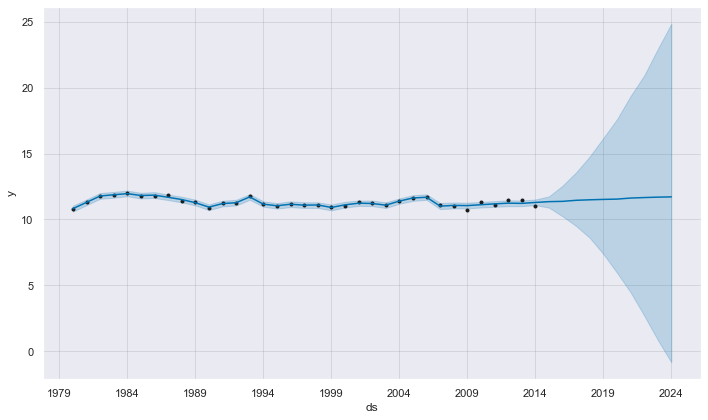

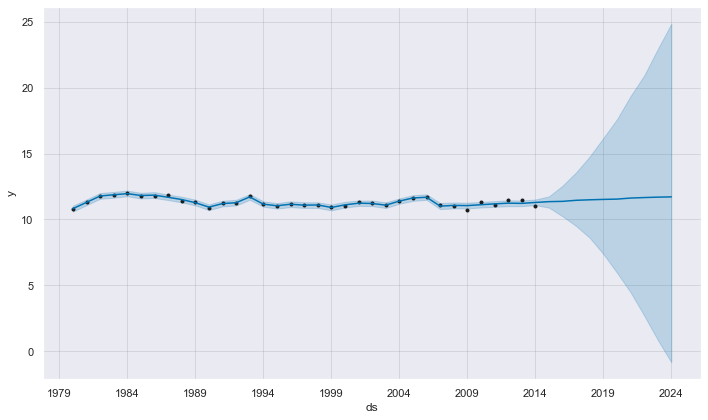

In [236]:
m.plot(forecast)

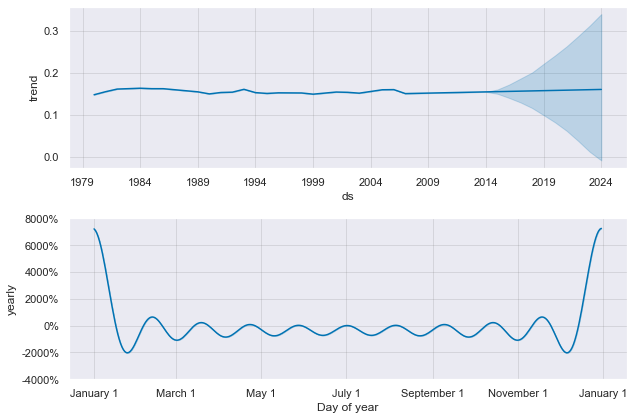

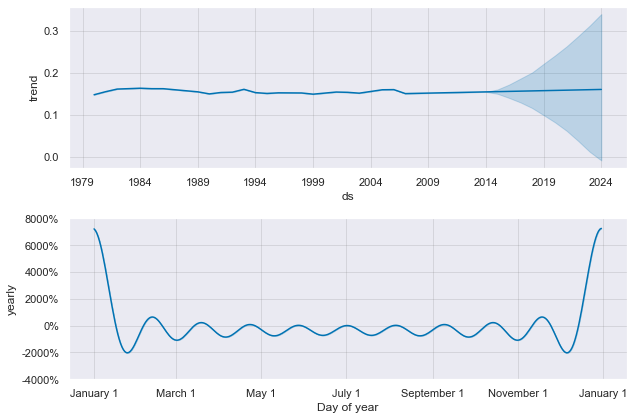

In [237]:
m.plot_components(forecast)

In [238]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted price and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2014-12-31')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(np.exp(sdtest.y),np.exp(metrics.yhat,dtype=np.float128))
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
51369.822933551080585


### Prophet Analysis: Forecasting Production in San Diego w/ Regressors

In [239]:
#Prophet Analysis for Ventura Production w/ Temp Regressor
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Avg_Temp')

#fit the model to trainset
m.fit(sdtrain)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y')
future['Avg_Temp'] = sd['ds']

forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:22 - cmdstanpy - INFO - Chain [1] start processing
19:54:22 - cmdstanpy - INFO - Chain [1] done processing


ds         yhat   yhat_lower   yhat_upper
0   1980  4170.854893  4170.297012  4171.427782
1   1981  4168.978346  4168.405679  4169.572347
2   1982  4166.945183  4166.384983  4167.570005
3   1983  4164.899820  4164.261334  4165.468358
4   1984  4162.842339  4162.248724  4163.401056
5   1985  4160.948713  4160.377857  4161.553675
6   1986  4158.899136  4158.327977  4159.485720
7   1987  4156.837392  4156.233862  4157.394558
8   1988  4154.763562  4154.146823  4155.346521
9   1989  4152.852856  4152.283812  4153.435360
10  1990  4150.786867  4150.216870  4151.355275
11  1991  4148.708742  4148.128350  4149.342967
12  1992  4146.618563  4146.060570  4147.180948
13  1993  4144.690779  4144.124454  4145.283850
14  1994  4142.608567  4142.016378  4143.191579
15  1995  4140.532573  4139.975278  4141.118953
16  1996  4138.514872  4137.939807  4139.054431
17  1997  4136.765405  4136.224586  4137.318344
18  1998  4134.993289  4134.409653  4135.586885
19  1999  4133.313785  4132.682902  4133.876626
20  2000  4131.675653  4131.100527  4132.209643
21  2001  4130.200340  4129.598039  4130.776197
22  2002  4128.577015  4127.979077  4129.175227
23  2003  4126.951401  4126.357813  4127.490598
24  2004  4125.314310  4124.731946  4125.891283
25  2005  4123.839454  4123.262724  4124.402815
26  2006  4122.210963  4121.590878  4122.807486
27  2007  4120.570947  4119.936635  4121.140096
28  2008  4118.919482  4118.286096  4119.484672
29  2009  4117.429608  4116.851227  4118.038479
30  2010  4115.786687  4115.198054  4116.370133
31  2011  4114.132268  4113.521002  4114.701434
32  2012  4112.466428  4111.932482  4113.036339
33  2013  4110.961538  4110.411878  4111.564643
34  2014  4109.304185  4108.659923  4109.897032
35  2015  4107.401361  4106.787319  4107.991880
36  2016  4105.690880  4105.139073  4106.314855
37  2017  4104.263633  4103.633863  4104.875868
38  2018  4102.560919  4101.899134  4103.185498
39  2019  4100.847123  4100.183065  4101.488418
40  2020  4099.122376  4098.389406  4099.829128

In [240]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted price and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(np.exp(sdtest.y),np.exp(metrics.yhat,dtype=np.float128))
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
2.7546249351274493226e+1783


In [241]:
#Prophet Analysis for Ventura Production w/ Precipitation Regressor
#Will use the sample (train subset) and st (test subset)

#This will instantiate a Prophet model, fit it to the DataFrame
#and predicts values which are returned in a forecast Dataframe
# Set the uncertainty interval to 95% (the Prophet default is 80%)
    
# define the model
m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
m.add_regressor(name='Avg_Prec')

#fit the model to trainset
m.fit(sdtrain)
#makes df
future = m.make_future_dataframe(periods=6,freq ='Y')
future['Avg_Prec'] = sd['ds']

forecast = m.predict(future)

forecast['ds'] = forecast['ds'] + pd.Timedelta(days=4) #pushes 12/31 dates to proper year
forecast['ds']=pd.to_datetime(forecast['ds'], format='%Y').dt.strftime('%Y') #fixes date to year onl
forecast[['ds','yhat','yhat_lower','yhat_upper']]

19:54:22 - cmdstanpy - INFO - Chain [1] start processing
19:54:24 - cmdstanpy - INFO - Chain [1] done processing


ds          yhat    yhat_lower    yhat_upper
0   1980   8995.956105   8995.735226   8996.163892
1   1981   9453.023297   9452.809547   9453.242927
2   1982   9800.136098   9799.925792   9800.366769
3   1983   9861.923904   9861.723325   9862.132095
4   1984  10038.914954  10038.711986  10039.136993
5   1985   9951.990224   9951.767287   9952.199148
6   1986   9922.629685   9922.408113   9922.828410
7   1987   9789.653091   9789.443475   9789.873128
8   1988   9656.529535   9656.310948   9656.740977
9   1989   9546.743004   9546.519734   9546.958993
10  1990   9220.606596   9220.389874   9220.821285
11  1991   9367.297276   9367.093624   9367.511155
12  1992   9425.161353   9424.935441   9425.364668
13  1993   9778.830537   9778.636370   9779.049939
14  1994   9388.080518   9387.866401   9388.296517
15  1995   9206.514010   9206.287116   9206.732413
16  1996   9435.657711   9435.435387   9435.874515
17  1997   9368.702036   9368.488318   9368.921986
18  1998   9301.342871   9301.134546   9301.554651
19  1999   9233.903647   9233.687585   9234.125690
20  2000   9389.623692   9389.420643   9389.830013
21  2001   9545.886413   9545.678127   9546.081284
22  2002   9552.083100   9551.870300   9552.294852
23  2003   9359.829471   9359.626987   9360.042461
24  2004   9585.132744   9584.923431   9585.352752
25  2005   9811.238449   9811.032340   9811.448938
26  2006   9932.464231   9932.252585   9932.674466
27  2007   9353.173598   9352.975422   9353.375152
28  2008   9390.839820   9390.637841   9391.054653
29  2009   9428.607291   9428.401179   9428.822991
30  2010   9466.354715   9466.147800   9466.554214
31  2011   9504.127287   9503.911088   9504.335348
32  2012   9541.924916   9541.694978   9542.153194
33  2013   9579.823666   9579.607411   9580.045068
34  2014   9617.702716   9617.490460   9617.907480
35  2015   9655.467382   9335.510044   9964.933266
36  2016   9693.364525   8721.178304  10655.917782
37  2017   9731.489746   7954.190569  11491.043143
38  2018   9769.468446   7033.455351  12501.521906
39  2019   9807.471881   5960.714933  13662.065706
40  2020   9845.499997   4976.877956  14782.606782

In [242]:
#Metrics for Measuring Modeling Accuracy Against Test Set

#Get yhat aka predicted price and y the actual value for test set
metrics=forecast.loc[(forecast['ds']>='2015')& (forecast['ds']<='2020')] #technically 2015 forecast
metrics

#MSE & RMSE
#Needed to transform actual and predicted back to actual values from previous log transformation
print('The Root Mean Squared Error is:')


mse=mean_squared_error(sdtest.y,metrics.yhat)
#Needed to change dtype because exp() of predicted values were exceeding float64
rmse=np.sqrt(mse)
print(rmse)

The Root Mean Squared Error is:
9739.985511374713


### Forecasting Average State Prices for Avocados

In [243]:
#creating a dataframe for Forecast values
avocadosForecast = pd.DataFrame()
avocadosForecast['year'] = []
avocadosForecast['State'] = []
avocadosForecast['State_Code'] = []
avocadosForecast['AveragePrice'] = []
avocadosForecast['UpperUncertainty'] = []
avocadosForecast['LowerUncertainty'] = []
avocadosForecast['Latitude'] = []
avocadosForecast['Longitude'] = []


19:54:25 - cmdstanpy - INFO - Chain [1] start processing
19:54:25 - cmdstanpy - INFO - Chain [1] done processing
19:54:25 - cmdstanpy - INFO - Chain [1] start processing
19:54:25 - cmdstanpy - INFO - Chain [1] done processing
19:54:25 - cmdstanpy - INFO - Chain [1] start processing
19:54:25 - cmdstanpy - INFO - Chain [1] done processing
19:54:26 - cmdstanpy - INFO - Chain [1] start processing
19:54:26 - cmdstanpy - INFO - Chain [1] done processing
19:54:26 - cmdstanpy - INFO - Chain [1] start processing
19:54:26 - cmdstanpy - INFO - Chain [1] done processing


States with Higher Average Avocado Prices:  Massachusetts


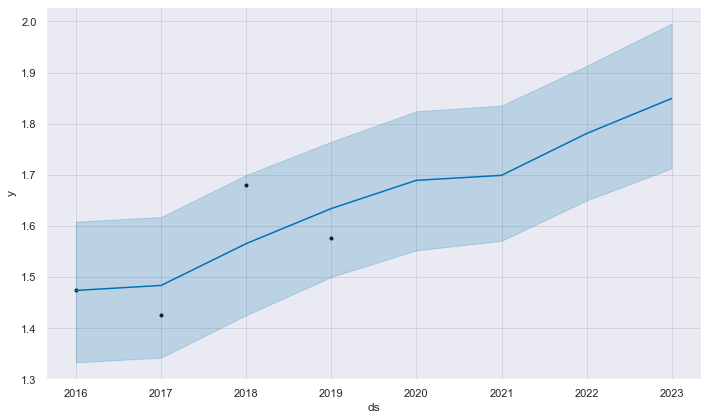

19:54:27 - cmdstanpy - INFO - Chain [1] start processing
19:54:27 - cmdstanpy - INFO - Chain [1] done processing
19:54:27 - cmdstanpy - INFO - Chain [1] start processing
19:54:27 - cmdstanpy - INFO - Chain [1] done processing


States with Higher Average Avocado Prices:  North Carolina


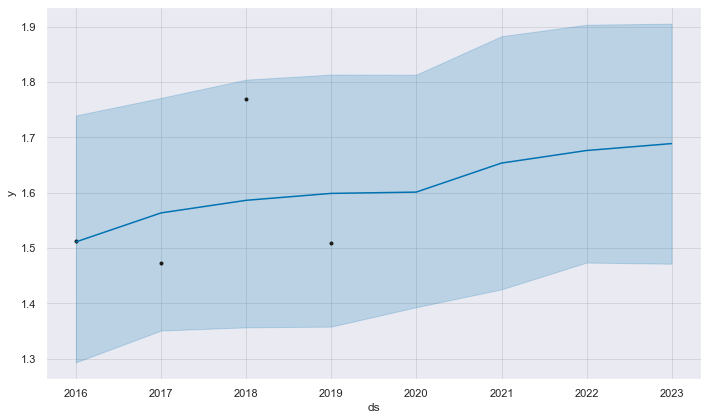

19:54:28 - cmdstanpy - INFO - Chain [1] start processing
19:54:28 - cmdstanpy - INFO - Chain [1] done processing


States with Higher Average Avocado Prices:  Illinois


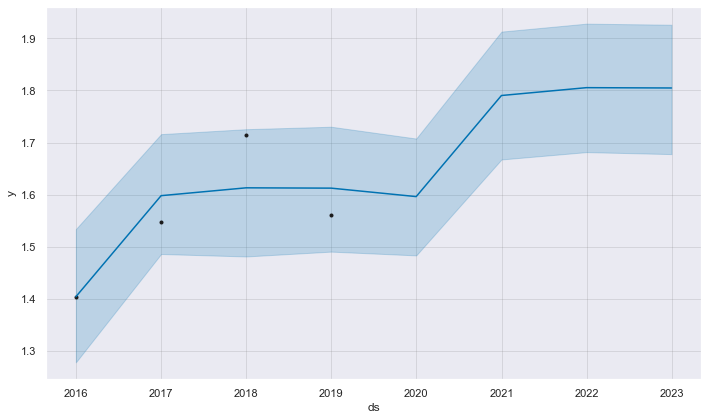

19:54:29 - cmdstanpy - INFO - Chain [1] start processing
19:54:29 - cmdstanpy - INFO - Chain [1] done processing
19:54:29 - cmdstanpy - INFO - Chain [1] start processing
19:54:29 - cmdstanpy - INFO - Chain [1] done processing
19:54:30 - cmdstanpy - INFO - Chain [1] start processing
19:54:30 - cmdstanpy - INFO - Chain [1] done processing
19:54:30 - cmdstanpy - INFO - Chain [1] start processing
19:54:30 - cmdstanpy - INFO - Chain [1] done processing
19:54:30 - cmdstanpy - INFO - Chain [1] start processing
19:54:30 - cmdstanpy - INFO - Chain [1] done processing
19:54:31 - cmdstanpy - INFO - Chain [1] start processing
19:54:31 - cmdstanpy - INFO - Chain [1] done processing


States with Higher Average Avocado Prices:  Connecticut


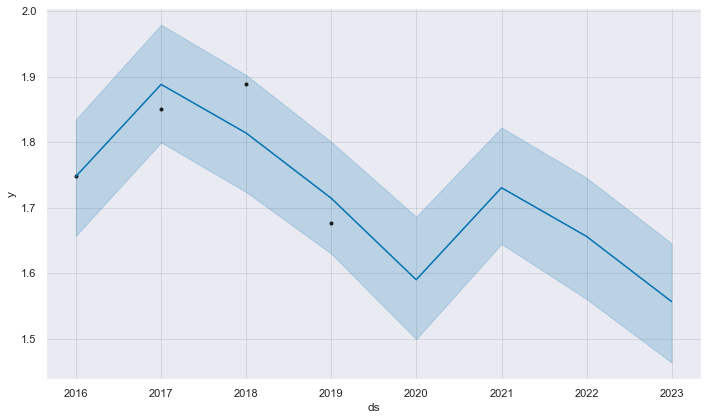

19:54:32 - cmdstanpy - INFO - Chain [1] start processing
19:54:32 - cmdstanpy - INFO - Chain [1] done processing
19:54:32 - cmdstanpy - INFO - Chain [1] start processing
19:54:32 - cmdstanpy - INFO - Chain [1] done processing
19:54:33 - cmdstanpy - INFO - Chain [1] start processing
19:54:33 - cmdstanpy - INFO - Chain [1] done processing
19:54:33 - cmdstanpy - INFO - Chain [1] start processing
19:54:33 - cmdstanpy - INFO - Chain [1] done processing
19:54:34 - cmdstanpy - INFO - Chain [1] start processing
19:54:34 - cmdstanpy - INFO - Chain [1] done processing
19:54:34 - cmdstanpy - INFO - Chain [1] start processing
19:54:34 - cmdstanpy - INFO - Chain [1] done processing
19:54:34 - cmdstanpy - INFO - Chain [1] start processing
19:54:35 - cmdstanpy - INFO - Chain [1] done processing
19:54:35 - cmdstanpy - INFO - Chain [1] start processing
19:54:35 - cmdstanpy - INFO - Chain [1] done processing
19:54:35 - cmdstanpy - INFO - Chain [1] start processing
19:54:35 - cmdstanpy - INFO - Chain [1]

In [244]:
uniqueStates = stateAvgPrices['State'].unique()
#only data for 28 States - data for 2015-2018

for state in uniqueStates:
    statedf = stateAvgPrices[stateAvgPrices['State']== state]
    prophetdf = statedf.drop(['State', 'State_Code', 'Latitude', 'Longitude'], axis = 1)
    prophetdf['year'] = prophetdf['year'].apply(lambda x: '12/31/' + str(int(x)))
    prophetdf = prophetdf.rename(columns = {'year' : 'ds', 'AveragePrice' : 'y'})
    model = Prophet(interval_width = 0.95)
    model.fit(prophetdf)
    #forecasting for four years
    futureDates = model.make_future_dataframe(periods = 4, freq = 'y')
    forecast = model.predict(futureDates) 
    pred = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
    if state in ['Connecticut', 'North Carolina', 'Illinois', 'Massachusetts']:
        print('States with Higher Average Avocado Prices: ', state)
        model.plot(forecast, uncertainty = True)
        plt.show()
    pred = pred.rename(columns = {'ds':'year', 'yhat': 'AveragePrice', 
                                 "yhat_upper" : 'UpperUncertainty', 
                                 "yhat_lower" : 'LowerUncertainty'})
    pred['State'] = state
    pred['State_Code'] = statedf['State_Code'].values[0]
    pred['Latitude'] = statedf['Latitude'].values[0]
    pred['Longitude'] = statedf['Longitude'].values[0]
    avocadosForecast = pd.concat([avocadosForecast, pred])
    

In [245]:
avocadosForecast.head(9)

year     State State_Code  AveragePrice  UpperUncertainty  \
0  2015-12-31 00:00:00  New York         NY      1.564225          1.701100   
1  2016-12-31 00:00:00  New York         NY      1.630283          1.764548   
2  2017-12-31 00:00:00  New York         NY      1.537194          1.677904   
3  2018-12-31 00:00:00  New York         NY      1.431475          1.555856   
4  2019-12-31 00:00:00  New York         NY      1.313183          1.448902   
5  2020-12-31 00:00:00  New York         NY      1.379241          1.517173   
6  2021-12-31 00:00:00  New York         NY      1.286152          1.434527   
7  2022-12-31 00:00:00  New York         NY      1.180433          1.327603   
0  2015-12-31 00:00:00   Georgia         GA      1.380555          1.519894   

   LowerUncertainty   Latitude  Longitude  
0          1.428696  42.165726 -74.948051  
1          1.495996  42.165726 -74.948051  
2          1.403967  42.165726 -74.948051  
3          1.282614  42.165726 -74.948051  
4          1.170955  42.165726 -74.948051  
5          1.237483  42.165726 -74.948051  
6          1.142365  42.165726 -74.948051  
7          1.034210  42.165726 -74.948051  
0          1.246556  33.040619 -83.643074

In [246]:
avocadosForecast.tail(9)

year       State State_Code  AveragePrice  UpperUncertainty  \
7  2022-12-31 00:00:00    Missouri         MO      1.730207          1.925638   
0  2015-12-31 00:00:00  New Mexico         NM      1.259305          1.259305   
1  2016-12-31 00:00:00  New Mexico         NM      1.246620          1.246620   
2  2017-12-31 00:00:00  New Mexico         NM      1.281524          1.281524   
3  2018-12-31 00:00:00  New Mexico         NM      1.251235          1.251235   
4  2019-12-31 00:00:00  New Mexico         NM      1.193523          1.217341   
5  2020-12-31 00:00:00  New Mexico         NM      1.143173          1.218950   
6  2021-12-31 00:00:00  New Mexico         NM      1.140515          1.279882   
7  2022-12-31 00:00:00  New Mexico         NM      1.110226          1.314209   

   LowerUncertainty   Latitude   Longitude  
7          1.525951  38.456085  -92.288368  
0          1.259305  34.840515 -106.248482  
1          1.246620  34.840515 -106.248482  
2          1.281524  34.840515 -106.248482  
3          1.251235  34.840515 -106.248482  
4          1.167419  34.840515 -106.248482  
5          1.066307  34.840515 -106.248482  
6          1.014283  34.840515 -106.248482  
7          0.924920  34.840515 -106.248482

In [247]:
avocadosForecast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224 entries, 0 to 7
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   year              224 non-null    object 
 1   State             224 non-null    object 
 2   State_Code        224 non-null    object 
 3   AveragePrice      224 non-null    float64
 4   UpperUncertainty  224 non-null    float64
 5   LowerUncertainty  224 non-null    float64
 6   Latitude          224 non-null    float64
 7   Longitude         224 non-null    float64
dtypes: float64(5), object(3)
memory usage: 15.8+ KB


In [248]:
avocadosForecast['year'] = pd.to_datetime(avocadosForecast['year']).dt.year
avocadosForecast['AveragePrice'] = avocadosForecast['AveragePrice'].apply(lambda x: round(x,2)) 

In [249]:
#year 2019 forecasted prices
avocadosPrices2019 = avocadosForecast[avocadosForecast['year'] == 2019]
fig = px.choropleth(avocadosPrices2019, locations = 'State_Code',
                   locationmode = 'USA-states', scope = 'usa',
                   color = 'AveragePrice', color_continuous_scale ='greens')
fig.update_layout(
    title_text = 'Avocado State Average Prices Forecasted for 2019',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

In [250]:
#year 2020 forecasted prices
avocadosPrices2020 = avocadosForecast[avocadosForecast['year'] == 2020]
fig = px.choropleth(avocadosPrices2020, locations = 'State_Code',
                   locationmode = 'USA-states', scope = 'usa',
                   color = 'AveragePrice', color_continuous_scale ='greens')
fig.update_layout(
    title_text = 'Avocado State Average Prices Forecasted for 2020',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

In [251]:
#year 2021 forecasted prices
avocadosPrices2021 = avocadosForecast[avocadosForecast['year'] == 2021]
fig = px.choropleth(avocadosPrices2021, locations = 'State_Code',
                   locationmode = 'USA-states', scope = 'usa',
                   color = 'AveragePrice', color_continuous_scale ='greens')
fig.update_layout(
    title_text = 'Avocado State Average Prices Forecasted for 2021',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

In [252]:
#year 2022 forecasted prices
avocadosPrices2022 = avocadosForecast[avocadosForecast['year'] == 2022]
fig = px.choropleth(avocadosPrices2022, locations = 'State_Code',
                   locationmode = 'USA-states', scope = 'usa',
                   color = 'AveragePrice', color_continuous_scale ='greens')
fig.update_layout(
    title_text = 'Avocado State Average Prices Forecasted for 2022',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

## End